# DataLab Cup 2: CNN for Object Detection

## Dataset: PASCAL VOC2007

In [1]:
classes_name =  ["aeroplane", "bicycle", "bird", "boat", "bottle", 
                 "bus", "car", "cat", "chair", "cow", "diningtable", 
                 "dog", "horse", "motorbike", "person", "pottedplant", 
                 "sheep", "sofa", "train","tvmonitor"]

## Processed data format

In [2]:
training_data_file = open("./pascal_voc_training_data.txt", "r")
for i, line in enumerate(training_data_file):
    if i >5:
        break
    line = line.strip()
    print(line)

000005.jpg 263 211 324 339 8 165 264 253 372 8 5 244 67 374 8 241 194 295 299 8 277 186 312 220 8
000007.jpg 141 50 500 330 6
000009.jpg 69 172 270 330 12 150 141 229 284 14 285 201 327 331 14 258 198 297 329 14
000012.jpg 156 97 351 270 6
000016.jpg 92 72 305 473 1
000017.jpg 185 62 279 199 14 90 78 403 336 12


In [3]:
import tensorflow as tf
import numpy as np
import os
import shutil
from data_aug.data_aug import *
from data_aug.bbox_util import *
from tqdm import tqdm
from datetime import datetime
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import cv2

## Hyperparameters

In [4]:
# common params
IMAGE_SIZE = 448
BATCH_SIZE = 4
NUM_CLASSES = 20
MAX_OBJECTS_PER_IMAGE = 20

# dataset params
DATA_PATH = './pascal_voc_training_data.txt'
IMAGE_DIR = './VOCdevkit_train/VOC2007/JPEGImages/'

# combined data path/ combined image directory
COM_DATA_PATH = './pascal_voc_training_data_combined.txt'
COM_IMAGE_DIR = './VOCdevkit_train/VOC2007/JPEGImages_combined/'

# model params
CELL_SIZE = 7
BOXES_PER_CELL = 2
OBJECT_SCALE = 1
NOOBJECT_SCALE = 0.5
CLASS_SCALE = 1
COORD_SCALE = 5

# training params
LEARNING_RATE = 1e-5
EPOCHS = 40

## Check class object numbers

In [5]:
images = [] # [000005.jpg, 000007.jpg, ...] 共4974張
records = [] # [[263,211,324,339,8,165,264,253,372,8], [...], ...]
num_class = [] # [5,1,...]每張圖有多少個class，為了下方擴增dataset時加速。

with open(DATA_PATH, 'r') as f:
    for line in f:
        tokens = line.split()
        images.append(tokens[0])
        # 每筆record放 5*物件個數
        record = list(map(float, tokens[1:])) # [xmin, ymin, xmax, ymax, class] = [263,211,324,339,8, ...] 
    
        # 每筆record最多只塞 MAX_OBJECTS_PER_IMAGE個物件
        if len(record) > MAX_OBJECTS_PER_IMAGE*5:
            record = record[:MAX_OBJECTS_PER_IMAGE*5] 
        records.append(record)
        num_class.append(len(record) // 5)

# 把每筆record(一維)拆成一個一個的物件框框(二維) dim: row=n/5, col=5
# record = [1,2,3,4,5,6,7,8,9,10]
# box = [[1, 2, 3, 4, 5],
#        [6, 7, 8, 9,10]]

boxes_list = []
for record in records:
    boxes = np.array(record)
    boxes = boxes.reshape((-1, 5))
    boxes_list.append(boxes)
    
image2boxes = dict(zip(images, boxes_list))

# classes in record in records
# classes = [[8,8,8],[6]]

classes = []
for record in records:
    record_class = []
    for i in range(4, len(record), 5):
        record_class.append(int(record[i]))
    classes.append(record_class)

# print(len(classes)) # 4974
        
# 計算每個class的數量 
class_cnt = np.zeros(NUM_CLASSES, int)
for record_class in classes: 
    for c in record_class:
        class_cnt[c] += 1
    
for i, num in enumerate(class_cnt):
    print(f'{i:2d}) {classes_name[i]:12}: {num}')

 0) aeroplane   : 331
 1) bicycle     : 412
 2) bird        : 577
 3) boat        : 398
 4) bottle      : 612
 5) bus         : 271
 6) car         : 1634
 7) cat         : 389
 8) chair       : 1423
 9) cow         : 356
10) diningtable : 309
11) dog         : 536
12) horse       : 403
13) motorbike   : 387
14) person      : 5318
15) pottedplant : 603
16) sheep       : 353
17) sofa        : 419
18) train       : 328
19) tvmonitor   : 366


In [6]:
combined_images = []
class_cnt = np.zeros(NUM_CLASSES, int) # index:0-19 value: # of class
num_image = len(images) # 4974
image_no = np.zeros(num_image, int)

# 先將原本的dataset放進combined dataset
# 並計算對應的各class數目
for i in range(num_image):
    record_class = classes[i]
    combined_images.append(f'{image_no[i]}-{images[i]}')
    image_no[i] += 1
    for c in record_class:
        class_cnt[c] += 1
        
_MIN = 2000

# 先看圖片所含的各個class是否都超過_MIN
# 如果其中有一個class不到_MIN我就加進去並更新class_cnt
# It turns out that person, car and chair are still imbalanced.
# while True:
#     for i, v in enumerate(classes):
#         s = set(v)
#         for c in s:
#             if class_cnt[c] < _MIN:
#                 combined_images.append(f'{image_no[c]}-{images[i]}')
#                 image_no += 1
#                 for each_c in v:
#                     class_cnt[each_c] += 1
#     if (class_cnt >= _MIN).all():
#         break

# tag = np.zeros(num_image, int)
# while True:
#     for i, v in enumerate(classes): # v = [8,8,8,8,8]
#         s = set(v)
#         for c in s:
#             if tag[i] or class_cnt[c] >= _MIN:
#                 tag[i] = 1
#                 continue
#             else:
#                 combined_images.append(f'{image_no[c]}-{images[i]}')
#                 image_no += 1
#                 for each_c in v:
#                     class_cnt[each_c] += 1
#     if (class_cnt >= _MIN).all():
#         break

# 先按照每張圖片所包含的class數量排序，並維護好index。
# 再依序看每張圖片所含的各個class是否有任一個超過_MIN。
# 若有，則不加入dataset，並上tag，未來也不加入。
# 否則，加入combined並更新class_cnt。

indexed_list = list(enumerate(num_class))
sorted_indices = sorted(indexed_list, key=lambda x: x[1], reverse=True)
sorted_indices = [index for index, value in sorted_indices]

tag = np.zeros(num_image, int)
while True:
    for i in sorted_indices:
        if tag[i]:
            continue
        record_class = classes[i]
        if np.any(class_cnt[record_class] >= _MIN): # 這張圖片其中一個class已經超過_MIN
            tag[i] = 1 # 未來不再看這張圖片
            continue
        else:
            combined_images.append(f'{image_no[i]}-{images[i]}')
            image_no[i] += 1
            for c in record_class:
                class_cnt[c] += 1
                    
    if np.all(class_cnt >= _MIN):
        break
        
for i, num in enumerate(class_cnt):
    print(f'{i:2d}) {classes_name[i]:12}: {num}')
    
# print(combined_images[0])

 0) aeroplane   : 2000
 1) bicycle     : 2000
 2) bird        : 2000
 3) boat        : 2000
 4) bottle      : 2000
 5) bus         : 2001
 6) car         : 2003
 7) cat         : 2001
 8) chair       : 2002
 9) cow         : 2006
10) diningtable : 2000
11) dog         : 2000
12) horse       : 2000
13) motorbike   : 2000
14) person      : 5318
15) pottedplant : 2001
16) sheep       : 2010
17) sofa        : 2000
18) train       : 2000
19) tvmonitor   : 2000


In [7]:
def gen_combined_dataset():
    if os.path.exists(COM_IMAGE_DIR):
        shutil.rmtree(COM_IMAGE_DIR)

    if not os.path.exists(COM_IMAGE_DIR):
        os.mkdir(COM_IMAGE_DIR)

    with open(COM_DATA_PATH, 'w') as f:
        np.random.seed(514)
        trans = Sequence([# RandomRotate(10), 
                          # RandomTranslate(0.2), 
                          RandomHSV(20, 20, 20), 
                          RandomHorizontalFlip(1), 
                          RandomScale(0.2), 
                          RandomShear(0.2)])

        for name in combined_images: # 0-00005.jpg
            no, namenum = name.split('-')
            
            # './VOCdevkit_train/VOC2007/JPEGImages/' + 00005
            image_file = tf.io.read_file(os.path.join(IMAGE_DIR, namenum))
            
            image = tf.io.decode_jpeg(image_file, channels=3)
            
            bboxes = image2boxes.get(namenum)
            
            # 只對新加入的圖片進行
            if no != '0':
                image, bboxes = trans(image.numpy().copy(), bboxes.copy())
            
            # 將轉換後的image encode並寫入combined image directory (COM_IMAGE_DIR)
            image = tf.io.encode_jpeg(image)
            tf.io.write_file(os.path.join(COM_IMAGE_DIR, name), image)

            # 寫新的圖片檔名和 bounding box 進 combined data path (COM_DATA_PATH)
            new_record = name + ' '
            box_info = []
            for box in bboxes:
                for b in box:
                    box_info.append(str(b))
            new_record += ' '.join(box_info)
            new_record += '\n'
            f.write(new_record)

#             buff_list = [name] + [str(int(b)) for box in bboxes for b in box]
#             f.write(' '.join(buff_list) + '\n')

In [8]:
augment = False

if augment:
    gen_combined_dataset()

## Dataset Loader

In [9]:
class DatasetGenerator:
    """
    Load pascalVOC 2007 dataset and creates an input pipeline.
    - Reshapes images into 448 x 448
    - converts [0 1] to [-1 1]
    - shuffles the input
    - builds batches
    """

    def __init__(self):
        self.image_names = []
        self.record_list = []
        self.object_num_list = []
        # filling the record_list
        input_file = open(COM_DATA_PATH, 'r')

        for line in input_file:
            line = line.strip()
            ss = line.split(' ')
            self.image_names.append(ss[0])

            self.record_list.append([float(num) for num in ss[1:]])

            self.object_num_list.append(
                min(len(self.record_list[-1]) // 5, MAX_OBJECTS_PER_IMAGE))
            if len(self.record_list[-1]) < MAX_OBJECTS_PER_IMAGE * 5:
                # if there are objects less than MAX_OBJECTS_PER_IMAGE, pad the list
                self.record_list[-1] = self.record_list[-1] + \
                    [0., 0., 0., 0., 0.] * \
                    (MAX_OBJECTS_PER_IMAGE - len(self.record_list[-1]) // 5)

            elif len(self.record_list[-1]) > MAX_OBJECTS_PER_IMAGE * 5:
               # if there are objects more than MAX_OBJECTS_PER_IMAGE, crop the list
                self.record_list[-1] = self.record_list[-1][:MAX_OBJECTS_PER_IMAGE * 5]

    def _data_preprocess(self, image_name, raw_labels, object_num):
        image_file = tf.io.read_file(COM_IMAGE_DIR + image_name)
        image = tf.io.decode_jpeg(image_file, channels=3)

        h = tf.shape(image)[0]
        w = tf.shape(image)[1]

        width_ratio = IMAGE_SIZE * 1.0 / tf.cast(w, tf.float32)
        height_ratio = IMAGE_SIZE * 1.0 / tf.cast(h, tf.float32)

        image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
        # image = (image/255) * 2 - 1
        image = tf.keras.applications.densenet.preprocess_input(image)

        raw_labels = tf.cast(tf.reshape(raw_labels, [-1, 5]), tf.float32)

        xmin = raw_labels[:, 0]
        ymin = raw_labels[:, 1]
        xmax = raw_labels[:, 2]
        ymax = raw_labels[:, 3]
        class_num = raw_labels[:, 4]

        xcenter = (xmin + xmax) * 1.0 / 2.0 * width_ratio
        ycenter = (ymin + ymax) * 1.0 / 2.0 * height_ratio

        box_w = (xmax - xmin) * width_ratio
        box_h = (ymax - ymin) * height_ratio

        labels = tf.stack([xcenter, ycenter, box_w, box_h, class_num], axis=1)

        return image, labels, tf.cast(object_num, tf.int32)

    def generate(self):
        dataset = tf.data.Dataset.from_tensor_slices((self.image_names,
                                                      np.array(self.record_list),
                                                      np.array(self.object_num_list)))
        dataset = dataset.shuffle(100000)\
                         .map(self._data_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)\
                         .batch(BATCH_SIZE, drop_remainder=True)\
                         .prefetch(tf.data.experimental.AUTOTUNE)
        return dataset

## Pretrained model + YOLO

https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [12]:
def conv_leaky_relu(inputs, filters, size, stride):
    x = layers.Conv2D(filters, size, stride, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.1)(x)

    return x

In [11]:
img_inputs = keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

basemodel = tf.keras.applications.densenet.DenseNet121(include_top=False, weights="imagenet", input_tensor=img_inputs)
basemodel.trainable = False
x = conv_leaky_relu(basemodel.output, 1024, 3, 1)
x = conv_leaky_relu(x, 1024, 3, 1)
x = conv_leaky_relu(x, 1024, 3, 2)
x = conv_leaky_relu(x, 1024, 3, 1)
x = conv_leaky_relu(x, 1024, 3, 1)

x = layers.Flatten()(x)
x = layers.Dense(4096, kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01))(x)
x = layers.LeakyReLU(0.1)(x)
outputs = layers.Dense(1470, kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01))(x) # 7*7*30

final_model = keras.Model(inputs=img_inputs, outputs=outputs, name="DenseNet121_YOLO")

In [12]:
final_model.summary()

Model: "DenseNet121_YOLO"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 448, 448, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 454, 454, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 224, 224, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                   

 conv2_block3_concat (Concatena  (None, 112, 112, 16  0          ['conv2_block2_concat[0][0]',    
 te)                            0)                                'conv2_block3_2_conv[0][0]']    
                                                                                                  
 conv2_block4_0_bn (BatchNormal  (None, 112, 112, 16  640        ['conv2_block3_concat[0][0]']    
 ization)                       0)                                                                
                                                                                                  
 conv2_block4_0_relu (Activatio  (None, 112, 112, 16  0          ['conv2_block4_0_bn[0][0]']      
 n)                             0)                                                                
                                                                                                  
 conv2_block4_1_conv (Conv2D)   (None, 112, 112, 12  20480       ['conv2_block4_0_relu[0][0]']    
          

 conv3_block1_1_conv (Conv2D)   (None, 56, 56, 128)  16384       ['conv3_block1_0_relu[0][0]']    
                                                                                                  
 conv3_block1_1_bn (BatchNormal  (None, 56, 56, 128)  512        ['conv3_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block1_1_relu (Activatio  (None, 56, 56, 128)  0          ['conv3_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block1_2_conv (Conv2D)   (None, 56, 56, 32)   36864       ['conv3_block1_1_relu[0][0]']    
                                                                                                  
 conv3_blo

                                                                                                  
 conv3_block5_2_conv (Conv2D)   (None, 56, 56, 32)   36864       ['conv3_block5_1_relu[0][0]']    
                                                                                                  
 conv3_block5_concat (Concatena  (None, 56, 56, 288)  0          ['conv3_block4_concat[0][0]',    
 te)                                                              'conv3_block5_2_conv[0][0]']    
                                                                                                  
 conv3_block6_0_bn (BatchNormal  (None, 56, 56, 288)  1152       ['conv3_block5_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block6_0_relu (Activatio  (None, 56, 56, 288)  0          ['conv3_block6_0_bn[0][0]']      
 n)       

 lization)                                                                                        
                                                                                                  
 conv3_block10_0_relu (Activati  (None, 56, 56, 416)  0          ['conv3_block10_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv3_block10_1_conv (Conv2D)  (None, 56, 56, 128)  53248       ['conv3_block10_0_relu[0][0]']   
                                                                                                  
 conv3_block10_1_bn (BatchNorma  (None, 56, 56, 128)  512        ['conv3_block10_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv3_blo

 conv4_block2_0_bn (BatchNormal  (None, 28, 28, 288)  1152       ['conv4_block1_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_0_relu (Activatio  (None, 28, 28, 288)  0          ['conv4_block2_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_1_conv (Conv2D)   (None, 28, 28, 128)  36864       ['conv4_block2_0_relu[0][0]']    
                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 conv4_block6_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv4_block6_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block6_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv4_block6_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block6_2_conv (Conv2D)   (None, 28, 28, 32)   36864       ['conv4_block6_1_relu[0][0]']    
                                                                                                  
 conv4_block6_concat (Concatena  (None, 28, 28, 448)  0          ['conv4_block5_concat[0][0]',    
 te)      

 conv4_block10_2_conv (Conv2D)  (None, 28, 28, 32)   36864       ['conv4_block10_1_relu[0][0]']   
                                                                                                  
 conv4_block10_concat (Concaten  (None, 28, 28, 576)  0          ['conv4_block9_concat[0][0]',    
 ate)                                                             'conv4_block10_2_conv[0][0]']   
                                                                                                  
 conv4_block11_0_bn (BatchNorma  (None, 28, 28, 576)  2304       ['conv4_block10_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block11_0_relu (Activati  (None, 28, 28, 576)  0          ['conv4_block11_0_bn[0][0]']     
 on)                                                                                              
          

                                                                                                  
 conv4_block15_0_relu (Activati  (None, 28, 28, 704)  0          ['conv4_block15_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block15_1_conv (Conv2D)  (None, 28, 28, 128)  90112       ['conv4_block15_0_relu[0][0]']   
                                                                                                  
 conv4_block15_1_bn (BatchNorma  (None, 28, 28, 128)  512        ['conv4_block15_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block15_1_relu (Activati  (None, 28, 28, 128)  0          ['conv4_block15_1_bn[0][0]']     
 on)      

 lization)                                                                                        
                                                                                                  
 conv4_block19_1_relu (Activati  (None, 28, 28, 128)  0          ['conv4_block19_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block19_2_conv (Conv2D)  (None, 28, 28, 32)   36864       ['conv4_block19_1_relu[0][0]']   
                                                                                                  
 conv4_block19_concat (Concaten  (None, 28, 28, 864)  0          ['conv4_block18_concat[0][0]',   
 ate)                                                             'conv4_block19_2_conv[0][0]']   
                                                                                                  
 conv4_blo

 conv4_block23_concat (Concaten  (None, 28, 28, 992)  0          ['conv4_block22_concat[0][0]',   
 ate)                                                             'conv4_block23_2_conv[0][0]']   
                                                                                                  
 conv4_block24_0_bn (BatchNorma  (None, 28, 28, 992)  3968       ['conv4_block23_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block24_0_relu (Activati  (None, 28, 28, 992)  0          ['conv4_block24_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block24_1_conv (Conv2D)  (None, 28, 28, 128)  126976      ['conv4_block24_0_relu[0][0]']   
          

                                                                                                  
 conv5_block3_2_conv (Conv2D)   (None, 14, 14, 32)   36864       ['conv5_block3_1_relu[0][0]']    
                                                                                                  
 conv5_block3_concat (Concatena  (None, 14, 14, 608)  0          ['conv5_block2_concat[0][0]',    
 te)                                                              'conv5_block3_2_conv[0][0]']    
                                                                                                  
 conv5_block4_0_bn (BatchNormal  (None, 14, 14, 608)  2432       ['conv5_block3_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block4_0_relu (Activatio  (None, 14, 14, 608)  0          ['conv5_block4_0_bn[0][0]']      
 n)       

 ization)                                                                                         
                                                                                                  
 conv5_block8_0_relu (Activatio  (None, 14, 14, 736)  0          ['conv5_block8_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block8_1_conv (Conv2D)   (None, 14, 14, 128)  94208       ['conv5_block8_0_relu[0][0]']    
                                                                                                  
 conv5_block8_1_bn (BatchNormal  (None, 14, 14, 128)  512        ['conv5_block8_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_blo

 conv5_block12_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv5_block12_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block12_1_relu (Activati  (None, 14, 14, 128)  0          ['conv5_block12_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block12_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv5_block12_1_relu[0][0]']   
                                                                                                  
 conv5_block12_concat (Concaten  (None, 14, 14, 896)  0          ['conv5_block11_concat[0][0]',   
 ate)                                                             'conv5_block12_2_conv[0][0]']   
          

                                                                                                  
 conv5_block16_concat (Concaten  (None, 14, 14, 1024  0          ['conv5_block15_concat[0][0]',   
 ate)                           )                                 'conv5_block16_2_conv[0][0]']   
                                                                                                  
 bn (BatchNormalization)        (None, 14, 14, 1024  4096        ['conv5_block16_concat[0][0]']   
                                )                                                                 
                                                                                                  
 relu (Activation)              (None, 14, 14, 1024  0           ['bn[0][0]']                     
                                )                                                                 
                                                                                                  
 conv2d (C

## Define loss

In [13]:
# base boxes (for loss calculation)
base_boxes = np.zeros([CELL_SIZE, CELL_SIZE, 4])

# initializtion for each cell
for y in range(CELL_SIZE):
    for x in range(CELL_SIZE):
        base_boxes[y, x, :] = [IMAGE_SIZE / CELL_SIZE * x,
                               IMAGE_SIZE / CELL_SIZE * y, 0, 0]

base_boxes = np.resize(base_boxes, [CELL_SIZE, CELL_SIZE, 1, 4])
base_boxes = np.tile(base_boxes, [1, 1, BOXES_PER_CELL, 1])

In [13]:
def iou(boxes1, boxes2):
    """calculate ious
    Args:
      boxes1: 4-D tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 4]  ====> (x_center, y_center, w, h)
      boxes2: 1-D tensor [4] ===> (x_center, y_center, w, h)

    Return:
      iou: 3-D tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
      ====> iou score for each cell
    """

    #boxes1 : [4(xmin, ymin, xmax, ymax), cell_size, cell_size, boxes_per_cell]
    boxes1 = tf.stack([boxes1[:, :, :, 0] - boxes1[:, :, :, 2] / 2, boxes1[:, :, :, 1] - boxes1[:, :, :, 3] / 2,
                      boxes1[:, :, :, 0] + boxes1[:, :, :, 2] / 2, boxes1[:, :, :, 1] + boxes1[:, :, :, 3] / 2])

    #boxes1 : [cell_size, cell_size, boxes_per_cell, 4(xmin, ymin, xmax, ymax)]
    boxes1 = tf.transpose(boxes1, [1, 2, 3, 0])

    boxes2 = tf.stack([boxes2[0] - boxes2[2] / 2, boxes2[1] - boxes2[3] / 2,
                       boxes2[0] + boxes2[2] / 2, boxes2[1] + boxes2[3] / 2])

    # calculate the left up point of boxes' overlap area
    lu = tf.maximum(boxes1[:, :, :, 0:2], boxes2[0:2])
    # calculate the right down point of boxes overlap area
    rd = tf.minimum(boxes1[:, :, :, 2:], boxes2[2:])

    # intersection
    intersection = rd - lu

    # the size of the intersection area
    inter_square = intersection[:, :, :, 0] * intersection[:, :, :, 1]

    mask = tf.cast(intersection[:, :, :, 0] > 0, tf.float32) * tf.cast(intersection[:, :, :, 1] > 0, tf.float32)

    # if intersection is negative, then the boxes don't overlap
    inter_square = mask * inter_square

    # calculate the boxs1 square and boxs2 square
    square1 = (boxes1[:, :, :, 2] - boxes1[:, :, :, 0]) * (boxes1[:, :, :, 3] - boxes1[:, :, :, 1])
    square2 = (boxes2[2] - boxes2[0]) * (boxes2[3] - boxes2[1])

    return inter_square/(square1 + square2 - inter_square + 1e-6)


def losses_calculation(predict, label):
    """
    calculate loss
    Args:
      predict: 3-D tensor [cell_size, cell_size, num_classes + 5 * boxes_per_cell]
      label :  [1, 5]  (x_center, y_center, w, h, class)
    """
    label = tf.reshape(label, [-1])

    # Step A. calculate objects tensor [CELL_SIZE, CELL_SIZE]
    # turn pixel position into cell position (corner)
    min_x = (label[0] - label[2] / 2) / (IMAGE_SIZE / CELL_SIZE)
    max_x = (label[0] + label[2] / 2) / (IMAGE_SIZE / CELL_SIZE)

    min_y = (label[1] - label[3] / 2) / (IMAGE_SIZE / CELL_SIZE)
    max_y = (label[1] + label[3] / 2) / (IMAGE_SIZE / CELL_SIZE)

    min_x = tf.floor(min_x)
    min_y = tf.floor(min_y)

    max_x = tf.minimum(tf.math.ceil(max_x), CELL_SIZE)
    max_y = tf.minimum(tf.math.ceil(max_y), CELL_SIZE)

    # calculate mask of object with cells
    onset = tf.cast(tf.stack([max_y - min_y, max_x - min_x]), dtype=tf.int32)
    object_mask = tf.ones(onset, tf.float32)

    offset = tf.cast(tf.stack([min_y, CELL_SIZE - max_y, min_x, CELL_SIZE - max_x]), tf.int32)
    offset = tf.reshape(offset, (2, 2))
    object_mask = tf.pad(object_mask, offset, "CONSTANT")

    # Step B. calculate the coordination of object center and the corresponding mask
    # turn pixel position into cell position (center)
    center_x = label[0] / (IMAGE_SIZE / CELL_SIZE)
    center_x = tf.floor(center_x)

    center_y = label[1] / (IMAGE_SIZE / CELL_SIZE)
    center_y = tf.floor(center_y)

    response = tf.ones([1, 1], tf.float32)

    # calculate the coordination of object center with cells
    objects_center_coord = tf.cast(tf.stack([center_y, CELL_SIZE - center_y - 1,
                                             center_x, CELL_SIZE - center_x - 1]),
                                   tf.int32)
    objects_center_coord = tf.reshape(objects_center_coord, (2, 2))

    # make mask
    objects_center_coord = tf.maximum(objects_center_coord, 0)   
    response = tf.pad(response, objects_center_coord, "CONSTANT")

    # Step C. calculate iou_predict_truth [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    predict_boxes = predict[:, :, NUM_CLASSES + BOXES_PER_CELL:]

    predict_boxes = tf.reshape(predict_boxes, [CELL_SIZE,
                                               CELL_SIZE,
                                               BOXES_PER_CELL, 4])
    # cell position to pixel position
    predict_boxes = predict_boxes * [IMAGE_SIZE / CELL_SIZE,
                                     IMAGE_SIZE / CELL_SIZE,
                                     IMAGE_SIZE, IMAGE_SIZE]

    # if there's no predict_box in that cell, then the base_boxes will be calcuated with label and got iou equals 0
    predict_boxes = base_boxes + predict_boxes

    iou_predict_truth = iou(predict_boxes, label[0:4])

    # calculate C tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    C = iou_predict_truth * tf.reshape(response, [CELL_SIZE, CELL_SIZE, 1])

    # calculate I tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    I = iou_predict_truth * tf.reshape(response, [CELL_SIZE, CELL_SIZE, 1])

    max_I = tf.reduce_max(I, 2, keepdims=True)

    # replace large iou scores with response (object center) value
    I = tf.cast((I >= max_I), tf.float32) * tf.reshape(response, (CELL_SIZE, CELL_SIZE, 1))

    # calculate no_I tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    no_I = tf.ones_like(I, dtype=tf.float32) - I

    p_C = predict[:, :, NUM_CLASSES:NUM_CLASSES + BOXES_PER_CELL]

    # calculate truth x, y, sqrt_w, sqrt_h 0-D
    x = label[0]
    y = label[1]

    sqrt_w = tf.sqrt(tf.abs(label[2]))
    sqrt_h = tf.sqrt(tf.abs(label[3]))

    # calculate predict p_x, p_y, p_sqrt_w, p_sqrt_h 3-D [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    p_x = predict_boxes[:, :, :, 0]
    p_y = predict_boxes[:, :, :, 1]

    p_sqrt_w = tf.sqrt(tf.minimum(IMAGE_SIZE * 1.0, tf.maximum(0.0, predict_boxes[:, :, :, 2])))
    p_sqrt_h = tf.sqrt(tf.minimum(IMAGE_SIZE * 1.0, tf.maximum(0.0, predict_boxes[:, :, :, 3])))

    # calculate ground truth p 1-D tensor [NUM_CLASSES]
    P = tf.one_hot(tf.cast(label[4], tf.int32), NUM_CLASSES, dtype=tf.float32)

    # calculate predicted p_P 3-D tensor [CELL_SIZE, CELL_SIZE, NUM_CLASSES]
    p_P = predict[:, :, 0:NUM_CLASSES]

    # class_loss
    class_loss = tf.nn.l2_loss(tf.reshape(object_mask, (CELL_SIZE, CELL_SIZE, 1)) * (p_P - P)) * CLASS_SCALE

    # object_loss
    object_loss = tf.nn.l2_loss(I * (p_C - C)) * OBJECT_SCALE

    # noobject_loss
    noobject_loss = tf.nn.l2_loss(no_I * (p_C)) * NOOBJECT_SCALE

    # coord_loss
    coord_loss = (tf.nn.l2_loss(I * (p_x - x) / (IMAGE_SIZE / CELL_SIZE)) +
                  tf.nn.l2_loss(I * (p_y - y) / (IMAGE_SIZE / CELL_SIZE)) +
                  tf.nn.l2_loss(I * (p_sqrt_w - sqrt_w)) / IMAGE_SIZE +
                  tf.nn.l2_loss(I * (p_sqrt_h - sqrt_h)) / IMAGE_SIZE) * COORD_SCALE

    return class_loss + object_loss + noobject_loss + coord_loss

In [14]:
def yolo_loss(predicts, labels, objects_num):
    """
    Add Loss to all the trainable variables
    Args:
        predicts:    4-D tensor [batch_size, cell_size, cell_size, num_classes + 5 * boxes_per_cell]
                     ===> (num_classes, boxes_per_cell, 4 * boxes_per_cell)
        labels:      3-D tensor of [batch_size, max_objects, 5]
        objects_num: 1-D tensor [batch_size]
    """

    loss = 0.
    # you can parallel the code with tf.map_fn or tf.vectorized_map (big performance gain!)
    for i in tf.range(BATCH_SIZE):
        predict = predicts[i, :, :, :]
        label = labels[i, :, :]
        object_num = objects_num[i]

        for j in tf.range(object_num):
            loss = loss + losses_calculation(predict, label[j:j+1, :])

    return loss / BATCH_SIZE

## Start Training

In [16]:
dataset = DatasetGenerator().generate()

In [17]:
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
train_loss_metric = tf.keras.metrics.Mean(name='loss')

In [18]:
ckpt = tf.train.Checkpoint(epoch=tf.Variable(0), net=final_model)

manager = tf.train.CheckpointManager(ckpt, './ckpts/DenseNet121_YOLO', max_to_keep=3,
                                     checkpoint_name='DenseNet121_YOLO')

In [23]:
@tf.function
def train_step(image, labels, objects_num):
    with tf.GradientTape() as tape:
        outputs = final_model(image)
        class_end = CELL_SIZE * CELL_SIZE * NUM_CLASSES
        conf_end = class_end + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
        class_probs = tf.reshape(outputs[:, 0:class_end], (-1, 7, 7, 20))
        confs = tf.reshape(outputs[:, class_end:conf_end], (-1, 7, 7, 2))
        boxes = tf.reshape(outputs[:, conf_end:], (-1, 7, 7, 2 * 4))
        predicts = tf.concat([class_probs, confs, boxes], 3)

        loss = yolo_loss(predicts, labels, objects_num)
        train_loss_metric(loss)

    grads = tape.gradient(loss, final_model.trainable_weights)
    optimizer.apply_gradients(zip(grads, final_model.trainable_weights))

In [24]:
print("{}, start training.".format(datetime.now()))
for i in range(EPOCHS):
    train_loss_metric.reset_states()
    ckpt.epoch.assign_add(1)

    for idx, (image, labels, objects_num) in enumerate(tqdm(dataset)):
        train_step(image, labels, objects_num)

    print("{}, Epoch {}: loss {:.2f}".format(
        datetime.now(), i+1, train_loss_metric.result()))

    save_path = manager.save()
    print("Saved checkpoint for epoch {}: {}".format(int(ckpt.epoch), save_path))

2023-11-20 22:39:04.461807, start training.


100%|██████████| 5482/5482 [06:08<00:00, 14.89it/s]


2023-11-20 22:45:12.603846, Epoch 1: loss 6.34
Saved checkpoint for epoch 3: ./ckpts/DenseNet121_YOLO\DenseNet121_YOLO-1


100%|██████████| 5482/5482 [06:00<00:00, 15.19it/s]


2023-11-20 22:51:15.282226, Epoch 2: loss 3.32
Saved checkpoint for epoch 4: ./ckpts/DenseNet121_YOLO\DenseNet121_YOLO-2


100%|██████████| 5482/5482 [06:00<00:00, 15.21it/s]


2023-11-20 22:57:17.570585, Epoch 3: loss 2.76
Saved checkpoint for epoch 5: ./ckpts/DenseNet121_YOLO\DenseNet121_YOLO-3


100%|██████████| 5482/5482 [05:59<00:00, 15.23it/s]


2023-11-20 23:03:19.155566, Epoch 4: loss 2.44
Saved checkpoint for epoch 6: ./ckpts/DenseNet121_YOLO\DenseNet121_YOLO-4


100%|██████████| 5482/5482 [06:00<00:00, 15.23it/s]


2023-11-20 23:09:20.945901, Epoch 5: loss 2.20
Saved checkpoint for epoch 7: ./ckpts/DenseNet121_YOLO\DenseNet121_YOLO-5


100%|██████████| 5482/5482 [06:00<00:00, 15.19it/s]


2023-11-20 23:15:23.508372, Epoch 6: loss 2.03
Saved checkpoint for epoch 8: ./ckpts/DenseNet121_YOLO\DenseNet121_YOLO-6


100%|██████████| 5482/5482 [06:01<00:00, 15.18it/s]


2023-11-20 23:21:26.392589, Epoch 7: loss 1.92
Saved checkpoint for epoch 9: ./ckpts/DenseNet121_YOLO\DenseNet121_YOLO-7


100%|██████████| 5482/5482 [06:00<00:00, 15.20it/s]


2023-11-20 23:27:28.883043, Epoch 8: loss 1.82
Saved checkpoint for epoch 10: ./ckpts/DenseNet121_YOLO\DenseNet121_YOLO-8


100%|██████████| 5482/5482 [06:01<00:00, 15.18it/s]


2023-11-20 23:33:31.630012, Epoch 9: loss 1.76
Saved checkpoint for epoch 11: ./ckpts/DenseNet121_YOLO\DenseNet121_YOLO-9


100%|██████████| 5482/5482 [05:59<00:00, 15.23it/s]


2023-11-20 23:39:33.181118, Epoch 10: loss 1.70
Saved checkpoint for epoch 12: ./ckpts/DenseNet121_YOLO\DenseNet121_YOLO-10


100%|██████████| 5482/5482 [06:01<00:00, 15.15it/s]


2023-11-20 23:45:36.921148, Epoch 11: loss 1.65
Saved checkpoint for epoch 13: ./ckpts/DenseNet121_YOLO\DenseNet121_YOLO-11


100%|██████████| 5482/5482 [06:01<00:00, 15.17it/s]


2023-11-20 23:51:40.107697, Epoch 12: loss 1.61
Saved checkpoint for epoch 14: ./ckpts/DenseNet121_YOLO\DenseNet121_YOLO-12


100%|██████████| 5482/5482 [06:03<00:00, 15.10it/s]


2023-11-20 23:57:45.053362, Epoch 13: loss 1.56
Saved checkpoint for epoch 15: ./ckpts/DenseNet121_YOLO\DenseNet121_YOLO-13


100%|██████████| 5482/5482 [06:03<00:00, 15.06it/s]


2023-11-21 00:03:50.785395, Epoch 14: loss 1.54
Saved checkpoint for epoch 16: ./ckpts/DenseNet121_YOLO\DenseNet121_YOLO-14


100%|██████████| 5482/5482 [06:02<00:00, 15.12it/s]


2023-11-21 00:09:55.138030, Epoch 15: loss 1.50
Saved checkpoint for epoch 17: ./ckpts/DenseNet121_YOLO\DenseNet121_YOLO-15


100%|██████████| 5482/5482 [06:04<00:00, 15.03it/s]


2023-11-21 00:16:01.599403, Epoch 16: loss 1.49
Saved checkpoint for epoch 18: ./ckpts/DenseNet121_YOLO\DenseNet121_YOLO-16


100%|██████████| 5482/5482 [06:01<00:00, 15.15it/s]


2023-11-21 00:22:05.297262, Epoch 17: loss 1.47
Saved checkpoint for epoch 19: ./ckpts/DenseNet121_YOLO\DenseNet121_YOLO-17


100%|██████████| 5482/5482 [06:01<00:00, 15.15it/s]


2023-11-21 00:28:09.033460, Epoch 18: loss 1.45
Saved checkpoint for epoch 20: ./ckpts/DenseNet121_YOLO\DenseNet121_YOLO-18


100%|██████████| 5482/5482 [06:04<00:00, 15.04it/s]


2023-11-21 00:34:15.268508, Epoch 19: loss 1.41
Saved checkpoint for epoch 21: ./ckpts/DenseNet121_YOLO\DenseNet121_YOLO-19


100%|██████████| 5482/5482 [06:04<00:00, 15.06it/s]


2023-11-21 00:40:21.180440, Epoch 20: loss 1.42
Saved checkpoint for epoch 22: ./ckpts/DenseNet121_YOLO\DenseNet121_YOLO-20


100%|██████████| 5482/5482 [06:02<00:00, 15.13it/s]


2023-11-21 00:46:25.326564, Epoch 21: loss 1.40
Saved checkpoint for epoch 23: ./ckpts/DenseNet121_YOLO\DenseNet121_YOLO-21


100%|██████████| 5482/5482 [06:01<00:00, 15.16it/s]


2023-11-21 00:52:28.834018, Epoch 22: loss 1.37
Saved checkpoint for epoch 24: ./ckpts/DenseNet121_YOLO\DenseNet121_YOLO-22


100%|██████████| 5482/5482 [06:00<00:00, 15.20it/s]


2023-11-21 00:58:31.188868, Epoch 23: loss 1.37
Saved checkpoint for epoch 25: ./ckpts/DenseNet121_YOLO\DenseNet121_YOLO-23


100%|██████████| 5482/5482 [06:00<00:00, 15.20it/s]


2023-11-21 01:04:33.720358, Epoch 24: loss 1.36
Saved checkpoint for epoch 26: ./ckpts/DenseNet121_YOLO\DenseNet121_YOLO-24


100%|██████████| 5482/5482 [06:00<00:00, 15.19it/s]


2023-11-21 01:10:36.331475, Epoch 25: loss 1.34
Saved checkpoint for epoch 27: ./ckpts/DenseNet121_YOLO\DenseNet121_YOLO-25


100%|██████████| 5482/5482 [06:01<00:00, 15.18it/s]


2023-11-21 01:16:39.686658, Epoch 26: loss 1.34
Saved checkpoint for epoch 28: ./ckpts/DenseNet121_YOLO\DenseNet121_YOLO-26


100%|██████████| 5482/5482 [06:01<00:00, 15.18it/s]


2023-11-21 01:22:42.598246, Epoch 27: loss 1.34
Saved checkpoint for epoch 29: ./ckpts/DenseNet121_YOLO\DenseNet121_YOLO-27


100%|██████████| 5482/5482 [06:00<00:00, 15.22it/s]


2023-11-21 01:28:44.488819, Epoch 28: loss 1.32
Saved checkpoint for epoch 30: ./ckpts/DenseNet121_YOLO\DenseNet121_YOLO-28


100%|██████████| 5482/5482 [06:01<00:00, 15.16it/s]


2023-11-21 01:34:47.814940, Epoch 29: loss 1.30
Saved checkpoint for epoch 31: ./ckpts/DenseNet121_YOLO\DenseNet121_YOLO-29


100%|██████████| 5482/5482 [05:59<00:00, 15.23it/s]


2023-11-21 01:40:49.581986, Epoch 30: loss 1.31
Saved checkpoint for epoch 32: ./ckpts/DenseNet121_YOLO\DenseNet121_YOLO-30


100%|██████████| 5482/5482 [05:59<00:00, 15.25it/s]


2023-11-21 01:46:50.923535, Epoch 31: loss 1.30
Saved checkpoint for epoch 33: ./ckpts/DenseNet121_YOLO\DenseNet121_YOLO-31


100%|██████████| 5482/5482 [05:59<00:00, 15.24it/s]


2023-11-21 01:52:52.639717, Epoch 32: loss 1.29
Saved checkpoint for epoch 34: ./ckpts/DenseNet121_YOLO\DenseNet121_YOLO-32


100%|██████████| 5482/5482 [05:58<00:00, 15.27it/s]


2023-11-21 01:58:53.453792, Epoch 33: loss 1.28
Saved checkpoint for epoch 35: ./ckpts/DenseNet121_YOLO\DenseNet121_YOLO-33


100%|██████████| 5482/5482 [05:58<00:00, 15.30it/s]


2023-11-21 02:04:53.587304, Epoch 34: loss 1.28
Saved checkpoint for epoch 36: ./ckpts/DenseNet121_YOLO\DenseNet121_YOLO-34


100%|██████████| 5482/5482 [05:57<00:00, 15.34it/s]


2023-11-21 02:10:52.861821, Epoch 35: loss 1.27
Saved checkpoint for epoch 37: ./ckpts/DenseNet121_YOLO\DenseNet121_YOLO-35


100%|██████████| 5482/5482 [05:58<00:00, 15.31it/s]


2023-11-21 02:16:52.690960, Epoch 36: loss 1.25
Saved checkpoint for epoch 38: ./ckpts/DenseNet121_YOLO\DenseNet121_YOLO-36


100%|██████████| 5482/5482 [05:57<00:00, 15.31it/s]


2023-11-21 02:22:52.451534, Epoch 37: loss 1.25
Saved checkpoint for epoch 39: ./ckpts/DenseNet121_YOLO\DenseNet121_YOLO-37


100%|██████████| 5482/5482 [05:57<00:00, 15.32it/s]


2023-11-21 02:28:52.166394, Epoch 38: loss 1.25
Saved checkpoint for epoch 40: ./ckpts/DenseNet121_YOLO\DenseNet121_YOLO-38


100%|██████████| 5482/5482 [05:57<00:00, 15.33it/s]


2023-11-21 02:34:51.538400, Epoch 39: loss 1.26
Saved checkpoint for epoch 41: ./ckpts/DenseNet121_YOLO\DenseNet121_YOLO-39


100%|██████████| 5482/5482 [05:57<00:00, 15.33it/s]


2023-11-21 02:40:50.880425, Epoch 40: loss 1.25
Saved checkpoint for epoch 42: ./ckpts/DenseNet121_YOLO\DenseNet121_YOLO-40


## Predict Test data
### Process YOLO's predictions

In [15]:
def process_outputs(outputs):
    """
    Process YOLO outputs into bounding boxes
    """

    class_end = CELL_SIZE * CELL_SIZE * NUM_CLASSES
    conf_end = class_end + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
    class_probs = np.reshape(outputs[:, 0:class_end], (-1, 7, 7, 20))
    confs = np.reshape(outputs[:, class_end:conf_end], (-1, 7, 7, 2))
    boxes = np.reshape(outputs[:, conf_end:], (-1, 7, 7, 2*4))
    predicts = np.concatenate([class_probs, confs, boxes], 3)

    p_classes = predicts[0, :, :, 0:20]
    C = predicts[0, :, :, 20:22]
    coordinate = predicts[0, :, :, 22:]

    p_classes = np.reshape(p_classes, (CELL_SIZE, CELL_SIZE, 1, 20))
    C = np.reshape(C, (CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 1))

    P = C * p_classes
    #P's shape [7, 7, 2, 20]

    #choose the most confidence one
    max_conf = np.max(P)
    index = np.argmax(P)

    index = np.unravel_index(index, P.shape)

    class_num = index[3]

    coordinate = np.reshape(coordinate, 
                            (CELL_SIZE, 
                             CELL_SIZE,
                             BOXES_PER_CELL, 
                             4))

    max_coordinate = coordinate[index[0], index[1], index[2], :]

    xcenter = max_coordinate[0]
    ycenter = max_coordinate[1]
    w = max_coordinate[2]
    h = max_coordinate[3]

    xcenter = (index[1] + xcenter) * (IMAGE_SIZE/float(CELL_SIZE))
    ycenter = (index[0] + ycenter) * (IMAGE_SIZE/float(CELL_SIZE))

    w = w * IMAGE_SIZE
    h = h * IMAGE_SIZE

    xmin = xcenter - w/2.0
    ymin = ycenter - h/2.0

    xmax = xmin + w
    ymax = ymin + h

    return xmin, ymin, xmax, ymax, class_num, max_conf

### Build Test dataset Iterator

In [26]:
test_img_files = open('./pascal_voc_testing_data.txt')
test_img_dir = './VOCdevkit_test/VOC2007/JPEGImages/'
test_images = []

for line in test_img_files:
    line = line.strip()
    ss = line.split(' ')
    test_images.append(ss[0])

test_dataset = tf.data.Dataset.from_tensor_slices(test_images)

def load_img_data(image_name):
    image_file = tf.io.read_file(test_img_dir+image_name)
    image = tf.image.decode_jpeg(image_file, channels=3)

    h = tf.shape(image)[0]
    w = tf.shape(image)[1]

    image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
    image = (image/255) * 2 - 1

    return image_name, image, h, w

test_dataset = test_dataset.map(load_img_data, num_parallel_calls = tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(32)

In [27]:
ckpt = tf.train.Checkpoint(net=final_model)
ckpt.restore('./ckpts/DenseNet121_YOLO/DenseNet121_YOLO-40')

### Make Prediction and Output to txt file

In [16]:
@tf.function
def prediction_step(img):
    return final_model(img, training=False)

In [29]:
output_file = open('./test_prediction.txt', 'w')

for img_name, test_img, img_h, img_w in test_dataset:
    batch_num = img_name.shape[0]
    for i in range(batch_num):
        xmin, ymin, xmax, ymax, class_num, conf = process_outputs(prediction_step(test_img[i:i+1]))
        xmin, ymin, xmax, ymax = xmin*(img_w[i:i+1]/IMAGE_SIZE), ymin*(img_h[i:i+1]/IMAGE_SIZE), xmax*(img_w[i:i+1]/IMAGE_SIZE), ymax*(img_h[i:i+1]/IMAGE_SIZE)

        #img filename, xmin, ymin, xmax, ymax, class, confidence
        output_file.write(img_name[i:i+1].numpy()[0].decode('ascii')+" %d %d %d %d %d %f\n" %(xmin, ymin, xmax, ymax, class_num, conf))

output_file.close()

### Run Evaluation Metric

In [30]:
import sys
sys.path.insert(0, './evaluate')

In [31]:
import evaluate
#evaluate.evaluate("input prediction file name", "desire output csv file name")
evaluate.evaluate('./test_prediction.txt', './output_file_DenseNet121_YOLO.csv')

End Evalutation


In [66]:
import pandas as pd

cap = pd.read_csv('./output_file_DenseNet121_YOLO.csv')['packedCAP']
print('score: {:f}'.format(sum((1. - cap) ** 2) / len(cap)))

score: 0.488540


## Visualization

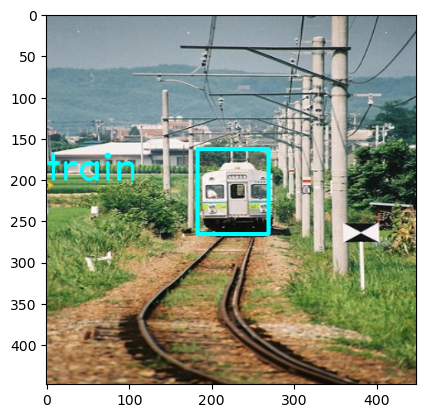

In [27]:
np_img = cv2.imread('./VOCdevkit_test/VOC2007/JPEGImages/000002.jpg')
resized_img = cv2.resize(np_img, (IMAGE_SIZE, IMAGE_SIZE))
np_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)
resized_img = np_img
np_img = np_img.astype(np.float32)
# np_img = tf.keras.applications.densenet.preprocess_input(np_img)

np_img = np_img / 255.0 * 2 - 1
np_img = np.reshape(np_img, (1, IMAGE_SIZE, IMAGE_SIZE, 3))


y_pred = final_model(np_img, training=False)
xmin, ymin, xmax, ymax, class_num, conf = process_outputs(y_pred)
class_name = classes_name[class_num]
cv2.rectangle(resized_img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 255), 3)
cv2.putText(resized_img, class_name, (0, 200), 2, 1.5, (0, 255, 255), 2)

plt.imshow(resized_img)
plt.show()

## InceptionResnetV2 + YOLO

In [34]:
class DatasetGenerator:
    """
    Load pascalVOC 2007 dataset and creates an input pipeline.
    - Reshapes images into 448 x 448
    - converts [0 1] to [-1 1]
    - shuffles the input
    - builds batches
    """

    def __init__(self):
        self.image_names = []
        self.record_list = []
        self.object_num_list = []
        # filling the record_list
        input_file = open(COM_DATA_PATH, 'r')

        for line in input_file:
            line = line.strip()
            ss = line.split(' ')
            self.image_names.append(ss[0])

            self.record_list.append([float(num) for num in ss[1:]])

            self.object_num_list.append(min(len(self.record_list[-1])//5, 
                                            MAX_OBJECTS_PER_IMAGE))
            if len(self.record_list[-1]) < MAX_OBJECTS_PER_IMAGE*5:
                # if there are objects less than MAX_OBJECTS_PER_IMAGE, pad the list
                self.record_list[-1] = self.record_list[-1] +\
                [0., 0., 0., 0., 0.]*\
                (MAX_OBJECTS_PER_IMAGE-len(self.record_list[-1])//5)
                
            elif len(self.record_list[-1]) > MAX_OBJECTS_PER_IMAGE*5:
               # if there are objects more than MAX_OBJECTS_PER_IMAGE, crop the list
                self.record_list[-1] = self.record_list[-1][:MAX_OBJECTS_PER_IMAGE*5]

    def _data_preprocess(self, image_name, raw_labels, object_num):
        image_file = tf.io.read_file(COM_IMAGE_DIR+image_name)
        image = tf.io.decode_jpeg(image_file, channels=3)

        h = tf.shape(image)[0]
        w = tf.shape(image)[1]

        width_ratio  = IMAGE_SIZE * 1.0 / tf.cast(w, tf.float32) 
        height_ratio = IMAGE_SIZE * 1.0 / tf.cast(h, tf.float32) 

        image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = (image/255) * 2 - 1

        raw_labels = tf.cast(tf.reshape(raw_labels, [-1, 5]), tf.float32)

        xmin = raw_labels[:, 0]
        ymin = raw_labels[:, 1]
        xmax = raw_labels[:, 2]
        ymax = raw_labels[:, 3]
        class_num = raw_labels[:, 4]

        xcenter = (xmin + xmax) * 1.0 / 2.0 * width_ratio
        ycenter = (ymin + ymax) * 1.0 / 2.0 * height_ratio

        box_w = (xmax - xmin) * width_ratio
        box_h = (ymax - ymin) * height_ratio

        labels = tf.stack([xcenter, ycenter, box_w, box_h, class_num], axis=1)

        return image, labels, tf.cast(object_num, tf.int32)

    def generate(self):
        dataset = tf.data.Dataset.from_tensor_slices((self.image_names, 
                                                      np.array(self.record_list), 
                                                      np.array(self.object_num_list)))
        dataset = dataset.shuffle(100000)
        dataset = dataset.map(self._data_preprocess, 
                              num_parallel_calls = tf.data.experimental.AUTOTUNE)
        dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
        dataset = dataset.prefetch(buffer_size=200)

        return dataset

In [35]:
img_inputs = keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

basemodel = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(include_top=False, weights='imagenet', input_tensor=img_inputs)
basemodel.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 448, 448, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_5 (Conv2D)              (None, 223, 223, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_5 (BatchNo  (None, 223, 223, 32  96         ['conv2d_5[0][0]']               
 rmalization)                   )                                               

                                                                                                  
 conv2d_15 (Conv2D)             (None, 53, 53, 96)   82944       ['activation_9[0][0]']           
                                                                                                  
 conv2d_16 (Conv2D)             (None, 53, 53, 64)   12288       ['average_pooling2d[0][0]']      
                                                                                                  
 batch_normalization_10 (BatchN  (None, 53, 53, 96)  288         ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_12 (BatchN  (None, 53, 53, 64)  192         ['conv2d_12[0][0]']              
 ormalization)                                                                                    
          

 conv2d_26 (Conv2D)             (None, 53, 53, 32)   10240       ['block35_1_ac[0][0]']           
                                                                                                  
 batch_normalization_26 (BatchN  (None, 53, 53, 32)  96          ['conv2d_26[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_21 (Activation)     (None, 53, 53, 32)   0           ['batch_normalization_26[0][0]'] 
                                                                                                  
 conv2d_24 (Conv2D)             (None, 53, 53, 32)   10240       ['block35_1_ac[0][0]']           
                                                                                                  
 conv2d_27 (Conv2D)             (None, 53, 53, 48)   13824       ['activation_21[0][0]']          
          

 batch_normalization_31 (BatchN  (None, 53, 53, 32)  96          ['conv2d_31[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_34 (BatchN  (None, 53, 53, 64)  192         ['conv2d_34[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_24 (Activation)     (None, 53, 53, 32)   0           ['batch_normalization_29[0][0]'] 
                                                                                                  
 activation_26 (Activation)     (None, 53, 53, 32)   0           ['batch_normalization_31[0][0]'] 
                                                                                                  
 activatio

 conv2d_42 (Conv2D)             (None, 53, 53, 32)   10240       ['block35_4_ac[0][0]']           
                                                                                                  
 conv2d_45 (Conv2D)             (None, 53, 53, 48)   13824       ['activation_39[0][0]']          
                                                                                                  
 batch_normalization_42 (BatchN  (None, 53, 53, 32)  96          ['conv2d_42[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_45 (BatchN  (None, 53, 53, 48)  144         ['conv2d_45[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

                                                                                                  
 activation_44 (Activation)     (None, 53, 53, 32)   0           ['batch_normalization_49[0][0]'] 
                                                                                                  
 activation_47 (Activation)     (None, 53, 53, 64)   0           ['batch_normalization_52[0][0]'] 
                                                                                                  
 block35_6_mixed (Concatenate)  (None, 53, 53, 128)  0           ['activation_42[0][0]',          
                                                                  'activation_44[0][0]',          
                                                                  'activation_47[0][0]']          
                                                                                                  
 block35_6_conv (Conv2D)        (None, 53, 53, 320)  41280       ['block35_6_mixed[0][0]']        
          

 batch_normalization_63 (BatchN  (None, 53, 53, 48)  144         ['conv2d_63[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_55 (Activation)     (None, 53, 53, 32)   0           ['batch_normalization_60[0][0]'] 
                                                                                                  
 activation_58 (Activation)     (None, 53, 53, 48)   0           ['batch_normalization_63[0][0]'] 
                                                                                                  
 conv2d_59 (Conv2D)             (None, 53, 53, 32)   10240       ['block35_7_ac[0][0]']           
                                                                                                  
 conv2d_61 (Conv2D)             (None, 53, 53, 32)   9216        ['activation_55[0][0]']          
          

                                                                  'activation_65[0][0]']          
                                                                                                  
 block35_9_conv (Conv2D)        (None, 53, 53, 320)  41280       ['block35_9_mixed[0][0]']        
                                                                                                  
 block35_9 (Lambda)             (None, 53, 53, 320)  0           ['block35_8_ac[0][0]',           
                                                                  'block35_9_conv[0][0]']         
                                                                                                  
 block35_9_ac (Activation)      (None, 53, 53, 320)  0           ['block35_9[0][0]']              
                                                                                                  
 conv2d_74 (Conv2D)             (None, 53, 53, 32)   10240       ['block35_9_ac[0][0]']           
          

 batch_normalization_80 (BatchN  (None, 26, 26, 384)  1152       ['conv2d_80[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_72 (Activation)     (None, 26, 26, 384)  0           ['batch_normalization_77[0][0]'] 
                                                                                                  
 activation_75 (Activation)     (None, 26, 26, 384)  0           ['batch_normalization_80[0][0]'] 
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 26, 26, 320)  0          ['block35_10_ac[0][0]']          
                                                                                                  
 mixed_6a (Concatenate)         (None, 26, 26, 1088  0           ['activation_72[0][0]',          
          

                                                                                                  
 block17_2_conv (Conv2D)        (None, 26, 26, 1088  418880      ['block17_2_mixed[0][0]']        
                                )                                                                 
                                                                                                  
 block17_2 (Lambda)             (None, 26, 26, 1088  0           ['block17_1_ac[0][0]',           
                                )                                 'block17_2_conv[0][0]']         
                                                                                                  
 block17_2_ac (Activation)      (None, 26, 26, 1088  0           ['block17_2[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_90

                                                                                                  
 block17_4 (Lambda)             (None, 26, 26, 1088  0           ['block17_3_ac[0][0]',           
                                )                                 'block17_4_conv[0][0]']         
                                                                                                  
 block17_4_ac (Activation)      (None, 26, 26, 1088  0           ['block17_4[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_98 (Conv2D)             (None, 26, 26, 128)  139264      ['block17_4_ac[0][0]']           
                                                                                                  
 batch_normalization_98 (BatchN  (None, 26, 26, 128)  384        ['conv2d_98[0][0]']              
 ormalizat

                                                                                                  
 block17_6_ac (Activation)      (None, 26, 26, 1088  0           ['block17_6[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_106 (Conv2D)            (None, 26, 26, 128)  139264      ['block17_6_ac[0][0]']           
                                                                                                  
 batch_normalization_106 (Batch  (None, 26, 26, 128)  384        ['conv2d_106[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_101 (Activation)    (None, 26, 26, 128)  0           ['batch_normalization_106[0][0]']
          

                                                                                                  
 conv2d_114 (Conv2D)            (None, 26, 26, 128)  139264      ['block17_8_ac[0][0]']           
                                                                                                  
 batch_normalization_114 (Batch  (None, 26, 26, 128)  384        ['conv2d_114[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_109 (Activation)    (None, 26, 26, 128)  0           ['batch_normalization_114[0][0]']
                                                                                                  
 conv2d_115 (Conv2D)            (None, 26, 26, 160)  143360      ['activation_109[0][0]']         
                                                                                                  
 batch_nor

 batch_normalization_122 (Batch  (None, 26, 26, 128)  384        ['conv2d_122[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_117 (Activation)    (None, 26, 26, 128)  0           ['batch_normalization_122[0][0]']
                                                                                                  
 conv2d_123 (Conv2D)            (None, 26, 26, 160)  143360      ['activation_117[0][0]']         
                                                                                                  
 batch_normalization_123 (Batch  (None, 26, 26, 160)  480        ['conv2d_123[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activatio

 activation_125 (Activation)    (None, 26, 26, 128)  0           ['batch_normalization_130[0][0]']
                                                                                                  
 conv2d_131 (Conv2D)            (None, 26, 26, 160)  143360      ['activation_125[0][0]']         
                                                                                                  
 batch_normalization_131 (Batch  (None, 26, 26, 160)  480        ['conv2d_131[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_126 (Activation)    (None, 26, 26, 160)  0           ['batch_normalization_131[0][0]']
                                                                                                  
 conv2d_129 (Conv2D)            (None, 26, 26, 192)  208896      ['block17_12_ac[0][0]']          
          

                                                                                                  
 batch_normalization_139 (Batch  (None, 26, 26, 160)  480        ['conv2d_139[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_134 (Activation)    (None, 26, 26, 160)  0           ['batch_normalization_139[0][0]']
                                                                                                  
 conv2d_137 (Conv2D)            (None, 26, 26, 192)  208896      ['block17_14_ac[0][0]']          
                                                                                                  
 conv2d_140 (Conv2D)            (None, 26, 26, 192)  215040      ['activation_134[0][0]']         
                                                                                                  
 batch_nor

                                                                                                  
 activation_142 (Activation)    (None, 26, 26, 160)  0           ['batch_normalization_147[0][0]']
                                                                                                  
 conv2d_145 (Conv2D)            (None, 26, 26, 192)  208896      ['block17_16_ac[0][0]']          
                                                                                                  
 conv2d_148 (Conv2D)            (None, 26, 26, 192)  215040      ['activation_142[0][0]']         
                                                                                                  
 batch_normalization_145 (Batch  (None, 26, 26, 192)  576        ['conv2d_145[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_nor

 conv2d_153 (Conv2D)            (None, 26, 26, 192)  208896      ['block17_18_ac[0][0]']          
                                                                                                  
 conv2d_156 (Conv2D)            (None, 26, 26, 192)  215040      ['activation_150[0][0]']         
                                                                                                  
 batch_normalization_153 (Batch  (None, 26, 26, 192)  576        ['conv2d_153[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_156 (Batch  (None, 26, 26, 192)  576        ['conv2d_156[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activatio

 Normalization)                                                                                   
                                                                                                  
 batch_normalization_166 (Batch  (None, 26, 26, 288)  864        ['conv2d_166[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_156 (Activation)    (None, 26, 26, 256)  0           ['batch_normalization_161[0][0]']
                                                                                                  
 activation_158 (Activation)    (None, 26, 26, 256)  0           ['batch_normalization_163[0][0]']
                                                                                                  
 activation_161 (Activation)    (None, 26, 26, 288)  0           ['batch_normalization_166[0][0]']
          

 Normalization)                                                                                   
                                                                                                  
 activation_168 (Activation)    (None, 12, 12, 192)  0           ['batch_normalization_173[0][0]']
                                                                                                  
 conv2d_174 (Conv2D)            (None, 12, 12, 224)  129024      ['activation_168[0][0]']         
                                                                                                  
 batch_normalization_174 (Batch  (None, 12, 12, 224)  672        ['conv2d_174[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_169 (Activation)    (None, 12, 12, 224)  0           ['batch_normalization_174[0][0]']
          

                                                                                                  
 conv2d_182 (Conv2D)            (None, 12, 12, 224)  129024      ['activation_176[0][0]']         
                                                                                                  
 batch_normalization_182 (Batch  (None, 12, 12, 224)  672        ['conv2d_182[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_177 (Activation)    (None, 12, 12, 224)  0           ['batch_normalization_182[0][0]']
                                                                                                  
 conv2d_180 (Conv2D)            (None, 12, 12, 192)  399360      ['block8_3_ac[0][0]']            
                                                                                                  
 conv2d_18

 batch_normalization_190 (Batch  (None, 12, 12, 224)  672        ['conv2d_190[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_185 (Activation)    (None, 12, 12, 224)  0           ['batch_normalization_190[0][0]']
                                                                                                  
 conv2d_188 (Conv2D)            (None, 12, 12, 192)  399360      ['block8_5_ac[0][0]']            
                                                                                                  
 conv2d_191 (Conv2D)            (None, 12, 12, 256)  172032      ['activation_185[0][0]']         
                                                                                                  
 batch_normalization_188 (Batch  (None, 12, 12, 192)  576        ['conv2d_188[0][0]']             
 Normaliza

 activation_193 (Activation)    (None, 12, 12, 224)  0           ['batch_normalization_198[0][0]']
                                                                                                  
 conv2d_196 (Conv2D)            (None, 12, 12, 192)  399360      ['block8_7_ac[0][0]']            
                                                                                                  
 conv2d_199 (Conv2D)            (None, 12, 12, 256)  172032      ['activation_193[0][0]']         
                                                                                                  
 batch_normalization_196 (Batch  (None, 12, 12, 192)  576        ['conv2d_196[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_199 (Batch  (None, 12, 12, 256)  768        ['conv2d_199[0][0]']             
 Normaliza

                                                                                                  
 conv2d_207 (Conv2D)            (None, 12, 12, 256)  172032      ['activation_201[0][0]']         
                                                                                                  
 batch_normalization_204 (Batch  (None, 12, 12, 192)  576        ['conv2d_204[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_207 (Batch  (None, 12, 12, 256)  768        ['conv2d_207[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_199 (Activation)    (None, 12, 12, 192)  0           ['batch_normalization_204[0][0]']
          

In [36]:
basemodel.trainable = False
x = conv_leaky_relu(basemodel.output, 1024, 3, 1)
x = conv_leaky_relu(x, 1024, 3, 1)
x = conv_leaky_relu(x, 1024, 3, 2)
x = conv_leaky_relu(x, 1024, 3, 1)
x = conv_leaky_relu(x, 1024, 3, 1)

x = layers.Flatten()(x)
x = layers.Dense(4096, kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01))(x)
x = layers.LeakyReLU(0.1)(x)
outputs = layers.Dense(1470, kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01))(x)

final_model = tf.keras.Model(inputs=img_inputs, outputs=outputs, name='InceptionResnetV2_YOLO')
final_model.summary()

Model: "InceptionResnetV2_YOLO"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 448, 448, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_5 (Conv2D)              (None, 223, 223, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_5 (BatchNo  (None, 223, 223, 32  96         ['conv2d_5[0][0]']               
 rmalization)                   )                                            

                                                                                                  
 conv2d_15 (Conv2D)             (None, 53, 53, 96)   82944       ['activation_9[0][0]']           
                                                                                                  
 conv2d_16 (Conv2D)             (None, 53, 53, 64)   12288       ['average_pooling2d[0][0]']      
                                                                                                  
 batch_normalization_10 (BatchN  (None, 53, 53, 96)  288         ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_12 (BatchN  (None, 53, 53, 64)  192         ['conv2d_12[0][0]']              
 ormalization)                                                                                    
          

 conv2d_26 (Conv2D)             (None, 53, 53, 32)   10240       ['block35_1_ac[0][0]']           
                                                                                                  
 batch_normalization_26 (BatchN  (None, 53, 53, 32)  96          ['conv2d_26[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_21 (Activation)     (None, 53, 53, 32)   0           ['batch_normalization_26[0][0]'] 
                                                                                                  
 conv2d_24 (Conv2D)             (None, 53, 53, 32)   10240       ['block35_1_ac[0][0]']           
                                                                                                  
 conv2d_27 (Conv2D)             (None, 53, 53, 48)   13824       ['activation_21[0][0]']          
          

 batch_normalization_31 (BatchN  (None, 53, 53, 32)  96          ['conv2d_31[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_34 (BatchN  (None, 53, 53, 64)  192         ['conv2d_34[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_24 (Activation)     (None, 53, 53, 32)   0           ['batch_normalization_29[0][0]'] 
                                                                                                  
 activation_26 (Activation)     (None, 53, 53, 32)   0           ['batch_normalization_31[0][0]'] 
                                                                                                  
 activatio

 conv2d_42 (Conv2D)             (None, 53, 53, 32)   10240       ['block35_4_ac[0][0]']           
                                                                                                  
 conv2d_45 (Conv2D)             (None, 53, 53, 48)   13824       ['activation_39[0][0]']          
                                                                                                  
 batch_normalization_42 (BatchN  (None, 53, 53, 32)  96          ['conv2d_42[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_45 (BatchN  (None, 53, 53, 48)  144         ['conv2d_45[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

                                                                                                  
 activation_44 (Activation)     (None, 53, 53, 32)   0           ['batch_normalization_49[0][0]'] 
                                                                                                  
 activation_47 (Activation)     (None, 53, 53, 64)   0           ['batch_normalization_52[0][0]'] 
                                                                                                  
 block35_6_mixed (Concatenate)  (None, 53, 53, 128)  0           ['activation_42[0][0]',          
                                                                  'activation_44[0][0]',          
                                                                  'activation_47[0][0]']          
                                                                                                  
 block35_6_conv (Conv2D)        (None, 53, 53, 320)  41280       ['block35_6_mixed[0][0]']        
          

 batch_normalization_63 (BatchN  (None, 53, 53, 48)  144         ['conv2d_63[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_55 (Activation)     (None, 53, 53, 32)   0           ['batch_normalization_60[0][0]'] 
                                                                                                  
 activation_58 (Activation)     (None, 53, 53, 48)   0           ['batch_normalization_63[0][0]'] 
                                                                                                  
 conv2d_59 (Conv2D)             (None, 53, 53, 32)   10240       ['block35_7_ac[0][0]']           
                                                                                                  
 conv2d_61 (Conv2D)             (None, 53, 53, 32)   9216        ['activation_55[0][0]']          
          

                                                                  'activation_65[0][0]']          
                                                                                                  
 block35_9_conv (Conv2D)        (None, 53, 53, 320)  41280       ['block35_9_mixed[0][0]']        
                                                                                                  
 block35_9 (Lambda)             (None, 53, 53, 320)  0           ['block35_8_ac[0][0]',           
                                                                  'block35_9_conv[0][0]']         
                                                                                                  
 block35_9_ac (Activation)      (None, 53, 53, 320)  0           ['block35_9[0][0]']              
                                                                                                  
 conv2d_74 (Conv2D)             (None, 53, 53, 32)   10240       ['block35_9_ac[0][0]']           
          

 batch_normalization_80 (BatchN  (None, 26, 26, 384)  1152       ['conv2d_80[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_72 (Activation)     (None, 26, 26, 384)  0           ['batch_normalization_77[0][0]'] 
                                                                                                  
 activation_75 (Activation)     (None, 26, 26, 384)  0           ['batch_normalization_80[0][0]'] 
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 26, 26, 320)  0          ['block35_10_ac[0][0]']          
                                                                                                  
 mixed_6a (Concatenate)         (None, 26, 26, 1088  0           ['activation_72[0][0]',          
          

                                                                                                  
 block17_2_conv (Conv2D)        (None, 26, 26, 1088  418880      ['block17_2_mixed[0][0]']        
                                )                                                                 
                                                                                                  
 block17_2 (Lambda)             (None, 26, 26, 1088  0           ['block17_1_ac[0][0]',           
                                )                                 'block17_2_conv[0][0]']         
                                                                                                  
 block17_2_ac (Activation)      (None, 26, 26, 1088  0           ['block17_2[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_90

                                                                                                  
 block17_4 (Lambda)             (None, 26, 26, 1088  0           ['block17_3_ac[0][0]',           
                                )                                 'block17_4_conv[0][0]']         
                                                                                                  
 block17_4_ac (Activation)      (None, 26, 26, 1088  0           ['block17_4[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_98 (Conv2D)             (None, 26, 26, 128)  139264      ['block17_4_ac[0][0]']           
                                                                                                  
 batch_normalization_98 (BatchN  (None, 26, 26, 128)  384        ['conv2d_98[0][0]']              
 ormalizat

                                                                                                  
 block17_6_ac (Activation)      (None, 26, 26, 1088  0           ['block17_6[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_106 (Conv2D)            (None, 26, 26, 128)  139264      ['block17_6_ac[0][0]']           
                                                                                                  
 batch_normalization_106 (Batch  (None, 26, 26, 128)  384        ['conv2d_106[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_101 (Activation)    (None, 26, 26, 128)  0           ['batch_normalization_106[0][0]']
          

                                                                                                  
 conv2d_114 (Conv2D)            (None, 26, 26, 128)  139264      ['block17_8_ac[0][0]']           
                                                                                                  
 batch_normalization_114 (Batch  (None, 26, 26, 128)  384        ['conv2d_114[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_109 (Activation)    (None, 26, 26, 128)  0           ['batch_normalization_114[0][0]']
                                                                                                  
 conv2d_115 (Conv2D)            (None, 26, 26, 160)  143360      ['activation_109[0][0]']         
                                                                                                  
 batch_nor

 batch_normalization_122 (Batch  (None, 26, 26, 128)  384        ['conv2d_122[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_117 (Activation)    (None, 26, 26, 128)  0           ['batch_normalization_122[0][0]']
                                                                                                  
 conv2d_123 (Conv2D)            (None, 26, 26, 160)  143360      ['activation_117[0][0]']         
                                                                                                  
 batch_normalization_123 (Batch  (None, 26, 26, 160)  480        ['conv2d_123[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activatio

 activation_125 (Activation)    (None, 26, 26, 128)  0           ['batch_normalization_130[0][0]']
                                                                                                  
 conv2d_131 (Conv2D)            (None, 26, 26, 160)  143360      ['activation_125[0][0]']         
                                                                                                  
 batch_normalization_131 (Batch  (None, 26, 26, 160)  480        ['conv2d_131[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_126 (Activation)    (None, 26, 26, 160)  0           ['batch_normalization_131[0][0]']
                                                                                                  
 conv2d_129 (Conv2D)            (None, 26, 26, 192)  208896      ['block17_12_ac[0][0]']          
          

                                                                                                  
 batch_normalization_139 (Batch  (None, 26, 26, 160)  480        ['conv2d_139[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_134 (Activation)    (None, 26, 26, 160)  0           ['batch_normalization_139[0][0]']
                                                                                                  
 conv2d_137 (Conv2D)            (None, 26, 26, 192)  208896      ['block17_14_ac[0][0]']          
                                                                                                  
 conv2d_140 (Conv2D)            (None, 26, 26, 192)  215040      ['activation_134[0][0]']         
                                                                                                  
 batch_nor

                                                                                                  
 activation_142 (Activation)    (None, 26, 26, 160)  0           ['batch_normalization_147[0][0]']
                                                                                                  
 conv2d_145 (Conv2D)            (None, 26, 26, 192)  208896      ['block17_16_ac[0][0]']          
                                                                                                  
 conv2d_148 (Conv2D)            (None, 26, 26, 192)  215040      ['activation_142[0][0]']         
                                                                                                  
 batch_normalization_145 (Batch  (None, 26, 26, 192)  576        ['conv2d_145[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_nor

 conv2d_153 (Conv2D)            (None, 26, 26, 192)  208896      ['block17_18_ac[0][0]']          
                                                                                                  
 conv2d_156 (Conv2D)            (None, 26, 26, 192)  215040      ['activation_150[0][0]']         
                                                                                                  
 batch_normalization_153 (Batch  (None, 26, 26, 192)  576        ['conv2d_153[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_156 (Batch  (None, 26, 26, 192)  576        ['conv2d_156[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activatio

 Normalization)                                                                                   
                                                                                                  
 batch_normalization_166 (Batch  (None, 26, 26, 288)  864        ['conv2d_166[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_156 (Activation)    (None, 26, 26, 256)  0           ['batch_normalization_161[0][0]']
                                                                                                  
 activation_158 (Activation)    (None, 26, 26, 256)  0           ['batch_normalization_163[0][0]']
                                                                                                  
 activation_161 (Activation)    (None, 26, 26, 288)  0           ['batch_normalization_166[0][0]']
          

 Normalization)                                                                                   
                                                                                                  
 activation_168 (Activation)    (None, 12, 12, 192)  0           ['batch_normalization_173[0][0]']
                                                                                                  
 conv2d_174 (Conv2D)            (None, 12, 12, 224)  129024      ['activation_168[0][0]']         
                                                                                                  
 batch_normalization_174 (Batch  (None, 12, 12, 224)  672        ['conv2d_174[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_169 (Activation)    (None, 12, 12, 224)  0           ['batch_normalization_174[0][0]']
          

                                                                                                  
 conv2d_182 (Conv2D)            (None, 12, 12, 224)  129024      ['activation_176[0][0]']         
                                                                                                  
 batch_normalization_182 (Batch  (None, 12, 12, 224)  672        ['conv2d_182[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_177 (Activation)    (None, 12, 12, 224)  0           ['batch_normalization_182[0][0]']
                                                                                                  
 conv2d_180 (Conv2D)            (None, 12, 12, 192)  399360      ['block8_3_ac[0][0]']            
                                                                                                  
 conv2d_18

 batch_normalization_190 (Batch  (None, 12, 12, 224)  672        ['conv2d_190[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_185 (Activation)    (None, 12, 12, 224)  0           ['batch_normalization_190[0][0]']
                                                                                                  
 conv2d_188 (Conv2D)            (None, 12, 12, 192)  399360      ['block8_5_ac[0][0]']            
                                                                                                  
 conv2d_191 (Conv2D)            (None, 12, 12, 256)  172032      ['activation_185[0][0]']         
                                                                                                  
 batch_normalization_188 (Batch  (None, 12, 12, 192)  576        ['conv2d_188[0][0]']             
 Normaliza

 activation_193 (Activation)    (None, 12, 12, 224)  0           ['batch_normalization_198[0][0]']
                                                                                                  
 conv2d_196 (Conv2D)            (None, 12, 12, 192)  399360      ['block8_7_ac[0][0]']            
                                                                                                  
 conv2d_199 (Conv2D)            (None, 12, 12, 256)  172032      ['activation_193[0][0]']         
                                                                                                  
 batch_normalization_196 (Batch  (None, 12, 12, 192)  576        ['conv2d_196[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_199 (Batch  (None, 12, 12, 256)  768        ['conv2d_199[0][0]']             
 Normaliza

                                                                                                  
 conv2d_207 (Conv2D)            (None, 12, 12, 256)  172032      ['activation_201[0][0]']         
                                                                                                  
 batch_normalization_204 (Batch  (None, 12, 12, 192)  576        ['conv2d_204[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_207 (Batch  (None, 12, 12, 256)  768        ['conv2d_207[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_199 (Activation)    (None, 12, 12, 192)  0           ['batch_normalization_204[0][0]']
          

In [37]:
# base boxes (for loss calculation)
base_boxes = np.zeros([CELL_SIZE, CELL_SIZE, 4])

# initializtion for each cell
for y in range(CELL_SIZE):
    for x in range(CELL_SIZE):
        base_boxes[y, x, :] = [IMAGE_SIZE / CELL_SIZE * x,
                               IMAGE_SIZE / CELL_SIZE * y, 0, 0]

base_boxes = np.resize(base_boxes, [CELL_SIZE, CELL_SIZE, 1, 4])
base_boxes = np.tile(base_boxes, [1, 1, BOXES_PER_CELL, 1])

In [38]:
dataset = DatasetGenerator().generate()

optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
train_loss_metric = tf.keras.metrics.Mean(name='loss')

ckpt = tf.train.Checkpoint(epoch=tf.Variable(0), net=final_model)
manager = tf.train.CheckpointManager(ckpt, './ckpts/InceptionResnetV2_YOLO', max_to_keep=3,
                                     checkpoint_name='InceptionResnetV2_YOLO')

In [39]:
@tf.function
def train_step(image, labels, objects_num):
    with tf.GradientTape() as tape:
        outputs = final_model(image)
        class_end = CELL_SIZE * CELL_SIZE * NUM_CLASSES
        conf_end = class_end + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
        class_probs = tf.reshape(outputs[:, 0:class_end], (-1, 7, 7, 20))
        confs = tf.reshape(outputs[:, class_end:conf_end], (-1, 7, 7, 2))
        boxes = tf.reshape(outputs[:, conf_end:], (-1, 7, 7, 2*4))
        predicts = tf.concat([class_probs, confs, boxes], 3)

        loss = yolo_loss(predicts, labels, objects_num)
        train_loss_metric(loss)

    grads = tape.gradient(loss, final_model.trainable_weights)
    optimizer.apply_gradients(zip(grads, final_model.trainable_weights))

In [40]:
print("{}, start training.".format(datetime.now()))
for i in range(EPOCHS):
    train_loss_metric.reset_states()
    ckpt.epoch.assign_add(1)

    for idx, (image, labels, objects_num) in enumerate(tqdm(dataset)):
        train_step(image, labels, objects_num)

    print("{}, Epoch {}: loss {:.2f}".format(datetime.now(), i+1, train_loss_metric.result()))

    save_path = manager.save()
    print("Saved checkpoint for epoch {}: {}".format(int(ckpt.epoch), save_path))

2023-11-21 02:42:23.244958, start training.


100%|██████████| 5482/5482 [06:10<00:00, 14.80it/s]


2023-11-21 02:48:33.667785, Epoch 1: loss 5.80
Saved checkpoint for epoch 1: ./ckpts/InceptionResnetV2_YOLO\InceptionResnetV2_YOLO-1


100%|██████████| 5482/5482 [06:04<00:00, 15.06it/s]


2023-11-21 02:54:39.550049, Epoch 2: loss 3.34
Saved checkpoint for epoch 2: ./ckpts/InceptionResnetV2_YOLO\InceptionResnetV2_YOLO-2


100%|██████████| 5482/5482 [06:03<00:00, 15.08it/s]


2023-11-21 03:00:45.053226, Epoch 3: loss 2.87
Saved checkpoint for epoch 3: ./ckpts/InceptionResnetV2_YOLO\InceptionResnetV2_YOLO-3


100%|██████████| 5482/5482 [06:04<00:00, 15.04it/s]


2023-11-21 03:06:51.804736, Epoch 4: loss 2.56
Saved checkpoint for epoch 4: ./ckpts/InceptionResnetV2_YOLO\InceptionResnetV2_YOLO-4


100%|██████████| 5482/5482 [06:03<00:00, 15.06it/s]


2023-11-21 03:12:57.736946, Epoch 5: loss 2.36
Saved checkpoint for epoch 5: ./ckpts/InceptionResnetV2_YOLO\InceptionResnetV2_YOLO-5


100%|██████████| 5482/5482 [06:03<00:00, 15.08it/s]


2023-11-21 03:19:03.291378, Epoch 6: loss 2.17
Saved checkpoint for epoch 6: ./ckpts/InceptionResnetV2_YOLO\InceptionResnetV2_YOLO-6


100%|██████████| 5482/5482 [06:03<00:00, 15.10it/s]


2023-11-21 03:25:08.441888, Epoch 7: loss 2.03
Saved checkpoint for epoch 7: ./ckpts/InceptionResnetV2_YOLO\InceptionResnetV2_YOLO-7


100%|██████████| 5482/5482 [06:04<00:00, 15.06it/s]


2023-11-21 03:31:14.405691, Epoch 8: loss 1.93
Saved checkpoint for epoch 8: ./ckpts/InceptionResnetV2_YOLO\InceptionResnetV2_YOLO-8


100%|██████████| 5482/5482 [06:03<00:00, 15.06it/s]


2023-11-21 03:37:20.236358, Epoch 9: loss 1.83
Saved checkpoint for epoch 9: ./ckpts/InceptionResnetV2_YOLO\InceptionResnetV2_YOLO-9


100%|██████████| 5482/5482 [06:03<00:00, 15.08it/s]


2023-11-21 03:43:25.505420, Epoch 10: loss 1.76
Saved checkpoint for epoch 10: ./ckpts/InceptionResnetV2_YOLO\InceptionResnetV2_YOLO-10


100%|██████████| 5482/5482 [06:04<00:00, 15.06it/s]


2023-11-21 03:49:31.414830, Epoch 11: loss 1.70
Saved checkpoint for epoch 11: ./ckpts/InceptionResnetV2_YOLO\InceptionResnetV2_YOLO-11


100%|██████████| 5482/5482 [06:04<00:00, 15.06it/s]


2023-11-21 03:55:37.478173, Epoch 12: loss 1.66
Saved checkpoint for epoch 12: ./ckpts/InceptionResnetV2_YOLO\InceptionResnetV2_YOLO-12


100%|██████████| 5482/5482 [06:03<00:00, 15.06it/s]


2023-11-21 04:01:43.292456, Epoch 13: loss 1.61
Saved checkpoint for epoch 13: ./ckpts/InceptionResnetV2_YOLO\InceptionResnetV2_YOLO-13


100%|██████████| 5482/5482 [06:04<00:00, 15.06it/s]


2023-11-21 04:07:49.225682, Epoch 14: loss 1.57
Saved checkpoint for epoch 14: ./ckpts/InceptionResnetV2_YOLO\InceptionResnetV2_YOLO-14


100%|██████████| 5482/5482 [06:03<00:00, 15.07it/s]


2023-11-21 04:13:54.851798, Epoch 15: loss 1.54
Saved checkpoint for epoch 15: ./ckpts/InceptionResnetV2_YOLO\InceptionResnetV2_YOLO-15


100%|██████████| 5482/5482 [06:04<00:00, 15.04it/s]


2023-11-21 04:20:01.179200, Epoch 16: loss 1.51
Saved checkpoint for epoch 16: ./ckpts/InceptionResnetV2_YOLO\InceptionResnetV2_YOLO-16


100%|██████████| 5482/5482 [06:03<00:00, 15.08it/s]


2023-11-21 04:26:06.805691, Epoch 17: loss 1.49
Saved checkpoint for epoch 17: ./ckpts/InceptionResnetV2_YOLO\InceptionResnetV2_YOLO-17


100%|██████████| 5482/5482 [06:03<00:00, 15.09it/s]


2023-11-21 04:32:11.886942, Epoch 18: loss 1.47
Saved checkpoint for epoch 18: ./ckpts/InceptionResnetV2_YOLO\InceptionResnetV2_YOLO-18


100%|██████████| 5482/5482 [06:04<00:00, 15.05it/s]


2023-11-21 04:38:18.213075, Epoch 19: loss 1.45
Saved checkpoint for epoch 19: ./ckpts/InceptionResnetV2_YOLO\InceptionResnetV2_YOLO-19


100%|██████████| 5482/5482 [06:04<00:00, 15.06it/s]


2023-11-21 04:44:24.129600, Epoch 20: loss 1.44
Saved checkpoint for epoch 20: ./ckpts/InceptionResnetV2_YOLO\InceptionResnetV2_YOLO-20


100%|██████████| 5482/5482 [06:03<00:00, 15.07it/s]


2023-11-21 04:50:29.747007, Epoch 21: loss 1.41
Saved checkpoint for epoch 21: ./ckpts/InceptionResnetV2_YOLO\InceptionResnetV2_YOLO-21


100%|██████████| 5482/5482 [06:03<00:00, 15.09it/s]


2023-11-21 04:56:34.982563, Epoch 22: loss 1.40
Saved checkpoint for epoch 22: ./ckpts/InceptionResnetV2_YOLO\InceptionResnetV2_YOLO-22


100%|██████████| 5482/5482 [06:03<00:00, 15.06it/s]


2023-11-21 05:02:40.862881, Epoch 23: loss 1.39
Saved checkpoint for epoch 23: ./ckpts/InceptionResnetV2_YOLO\InceptionResnetV2_YOLO-23


100%|██████████| 5482/5482 [06:03<00:00, 15.08it/s]


2023-11-21 05:08:46.382509, Epoch 24: loss 1.37
Saved checkpoint for epoch 24: ./ckpts/InceptionResnetV2_YOLO\InceptionResnetV2_YOLO-24


100%|██████████| 5482/5482 [06:03<00:00, 15.08it/s]


2023-11-21 05:14:51.858191, Epoch 25: loss 1.35
Saved checkpoint for epoch 25: ./ckpts/InceptionResnetV2_YOLO\InceptionResnetV2_YOLO-25


100%|██████████| 5482/5482 [06:03<00:00, 15.08it/s]


2023-11-21 05:20:57.389168, Epoch 26: loss 1.35
Saved checkpoint for epoch 26: ./ckpts/InceptionResnetV2_YOLO\InceptionResnetV2_YOLO-26


100%|██████████| 5482/5482 [06:04<00:00, 15.06it/s]


2023-11-21 05:27:03.396838, Epoch 27: loss 1.33
Saved checkpoint for epoch 27: ./ckpts/InceptionResnetV2_YOLO\InceptionResnetV2_YOLO-27


100%|██████████| 5482/5482 [06:04<00:00, 15.05it/s]


2023-11-21 05:33:09.542419, Epoch 28: loss 1.33
Saved checkpoint for epoch 28: ./ckpts/InceptionResnetV2_YOLO\InceptionResnetV2_YOLO-28


100%|██████████| 5482/5482 [06:03<00:00, 15.07it/s]


2023-11-21 05:39:15.089497, Epoch 29: loss 1.32
Saved checkpoint for epoch 29: ./ckpts/InceptionResnetV2_YOLO\InceptionResnetV2_YOLO-29


100%|██████████| 5482/5482 [06:04<00:00, 15.04it/s]


2023-11-21 05:45:21.497801, Epoch 30: loss 1.31
Saved checkpoint for epoch 30: ./ckpts/InceptionResnetV2_YOLO\InceptionResnetV2_YOLO-30


100%|██████████| 5482/5482 [06:03<00:00, 15.07it/s]


2023-11-21 05:51:27.088302, Epoch 31: loss 1.31
Saved checkpoint for epoch 31: ./ckpts/InceptionResnetV2_YOLO\InceptionResnetV2_YOLO-31


100%|██████████| 5482/5482 [06:03<00:00, 15.08it/s]


2023-11-21 05:57:32.407287, Epoch 32: loss 1.30
Saved checkpoint for epoch 32: ./ckpts/InceptionResnetV2_YOLO\InceptionResnetV2_YOLO-32


100%|██████████| 5482/5482 [06:03<00:00, 15.09it/s]


2023-11-21 06:03:37.661220, Epoch 33: loss 1.29
Saved checkpoint for epoch 33: ./ckpts/InceptionResnetV2_YOLO\InceptionResnetV2_YOLO-33


100%|██████████| 5482/5482 [06:03<00:00, 15.06it/s]


2023-11-21 06:09:43.473989, Epoch 34: loss 1.27
Saved checkpoint for epoch 34: ./ckpts/InceptionResnetV2_YOLO\InceptionResnetV2_YOLO-34


100%|██████████| 5482/5482 [06:03<00:00, 15.07it/s]


2023-11-21 06:15:49.136894, Epoch 35: loss 1.28
Saved checkpoint for epoch 35: ./ckpts/InceptionResnetV2_YOLO\InceptionResnetV2_YOLO-35


100%|██████████| 5482/5482 [06:03<00:00, 15.08it/s]


2023-11-21 06:21:54.665762, Epoch 36: loss 1.27
Saved checkpoint for epoch 36: ./ckpts/InceptionResnetV2_YOLO\InceptionResnetV2_YOLO-36


100%|██████████| 5482/5482 [06:04<00:00, 15.05it/s]


2023-11-21 06:28:00.827009, Epoch 37: loss 1.26
Saved checkpoint for epoch 37: ./ckpts/InceptionResnetV2_YOLO\InceptionResnetV2_YOLO-37


100%|██████████| 5482/5482 [06:04<00:00, 15.05it/s]


2023-11-21 06:34:06.964369, Epoch 38: loss 1.26
Saved checkpoint for epoch 38: ./ckpts/InceptionResnetV2_YOLO\InceptionResnetV2_YOLO-38


100%|██████████| 5482/5482 [06:03<00:00, 15.09it/s]


2023-11-21 06:40:12.086985, Epoch 39: loss 1.25
Saved checkpoint for epoch 39: ./ckpts/InceptionResnetV2_YOLO\InceptionResnetV2_YOLO-39


100%|██████████| 5482/5482 [06:03<00:00, 15.07it/s]


2023-11-21 06:46:17.971875, Epoch 40: loss 1.25
Saved checkpoint for epoch 40: ./ckpts/InceptionResnetV2_YOLO\InceptionResnetV2_YOLO-40


In [41]:
test_img_files = open('./pascal_voc_testing_data.txt')
test_img_dir = './VOCdevkit_test/VOC2007/JPEGImages/'
test_images = []

for line in test_img_files:
    line = line.strip()
    ss = line.split(' ')
    test_images.append(ss[0])

test_dataset = tf.data.Dataset.from_tensor_slices(test_images)

def load_img_data(image_name):
    image_file = tf.io.read_file(test_img_dir+image_name)
    image = tf.image.decode_jpeg(image_file, channels=3)

    h = tf.shape(image)[0]
    w = tf.shape(image)[1]

    image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
    image = (image/255) * 2 - 1

    return image_name, image, h, w

test_dataset = test_dataset.map(load_img_data, num_parallel_calls = tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(32)

In [42]:
ckpt = tf.train.Checkpoint(net=final_model)
ckpt.restore('./ckpts/InceptionResnetV2_YOLO/InceptionResnetV2_YOLO-40')

In [43]:
@tf.function
def prediction_step(img):
    return final_model(img, training=False)

In [44]:
output_file = open('./test_prediction.txt', 'w')

for img_name, test_img, img_h, img_w in test_dataset:
    batch_num = img_name.shape[0]
    for i in range(batch_num):
        xmin, ymin, xmax, ymax, class_num, conf = process_outputs(prediction_step(test_img[i:i+1]))
        xmin, ymin, xmax, ymax = xmin*(img_w[i:i+1]/IMAGE_SIZE), ymin*(img_h[i:i+1]/IMAGE_SIZE), xmax*(img_w[i:i+1]/IMAGE_SIZE), ymax*(img_h[i:i+1]/IMAGE_SIZE)

        #img filename, xmin, ymin, xmax, ymax, class, confidence
        output_file.write(img_name[i:i+1].numpy()[0].decode('ascii')+" %d %d %d %d %d %f\n" %(xmin, ymin, xmax, ymax, class_num, conf))

output_file.close()

In [67]:
import sys
sys.path.insert(0, './evaluate')

import evaluate
#evaluate.evaluate("input prediction file name", "desire output csv file name")
evaluate.evaluate('./test_prediction.txt', './output_file_InceptionResnetV2_YOLO.csv')

cap = pd.read_csv('./output_file_InceptionResnetV2_YOLO.csv')['packedCAP']
print('score: {:f}'.format(sum((1. - cap) ** 2) / len(cap)))

End Evalutation
score: 0.471578


## Xception + YOLO

In [46]:
class DatasetGenerator:
    """
    Load pascalVOC 2007 dataset and creates an input pipeline.
    - Reshapes images into 448 x 448
    - converts [0 1] to [-1 1]
    - shuffles the input
    - builds batches
    """

    def __init__(self):
        self.image_names = []
        self.record_list = []
        self.object_num_list = []
        # filling the record_list
        input_file = open(COM_DATA_PATH, 'r')

        for line in input_file:
            line = line.strip()
            ss = line.split(' ')
            self.image_names.append(ss[0])

            self.record_list.append([float(num) for num in ss[1:]])

            self.object_num_list.append(
                min(len(self.record_list[-1]) // 5, MAX_OBJECTS_PER_IMAGE))
            if len(self.record_list[-1]) < MAX_OBJECTS_PER_IMAGE * 5:
                # if there are objects less than MAX_OBJECTS_PER_IMAGE, pad the list
                self.record_list[-1] = self.record_list[-1] + \
                    [0., 0., 0., 0., 0.] * \
                    (MAX_OBJECTS_PER_IMAGE - len(self.record_list[-1]) // 5)

            elif len(self.record_list[-1]) > MAX_OBJECTS_PER_IMAGE * 5:
               # if there are objects more than MAX_OBJECTS_PER_IMAGE, crop the list
                self.record_list[-1] = self.record_list[-1][:MAX_OBJECTS_PER_IMAGE * 5]

    def _data_preprocess(self, image_name, raw_labels, object_num):
        image_file = tf.io.read_file(COM_IMAGE_DIR + image_name)
        image = tf.io.decode_jpeg(image_file, channels=3)

        h = tf.shape(image)[0]
        w = tf.shape(image)[1]

        width_ratio = IMAGE_SIZE * 1.0 / tf.cast(w, tf.float32)
        height_ratio = IMAGE_SIZE * 1.0 / tf.cast(h, tf.float32)

        image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = (image/255) * 2 - 1
#         image = tf.keras.applications.xception.preprocess_input(image)

        raw_labels = tf.cast(tf.reshape(raw_labels, [-1, 5]), tf.float32)

        xmin = raw_labels[:, 0]
        ymin = raw_labels[:, 1]
        xmax = raw_labels[:, 2]
        ymax = raw_labels[:, 3]
        class_num = raw_labels[:, 4]

        xcenter = (xmin + xmax) * 1.0 / 2.0 * width_ratio
        ycenter = (ymin + ymax) * 1.0 / 2.0 * height_ratio

        box_w = (xmax - xmin) * width_ratio
        box_h = (ymax - ymin) * height_ratio

        labels = tf.stack([xcenter, ycenter, box_w, box_h, class_num], axis=1)

        return image, labels, tf.cast(object_num, tf.int32)

    def generate(self):
        dataset = tf.data.Dataset.from_tensor_slices((self.image_names,
                                                      np.array(self.record_list),
                                                      np.array(self.object_num_list)))
        dataset = dataset.shuffle(100000)\
                         .map(self._data_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)\
                         .batch(BATCH_SIZE, drop_remainder=True)\
                         .prefetch(tf.data.experimental.AUTOTUNE)
        return dataset

In [47]:
img_inputs = keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

basemodel = tf.keras.applications.xception.Xception(include_top=False, weights='imagenet', input_tensor=img_inputs)
basemodel.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 448, 448, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 223, 223, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 223, 223, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

 2D)                                                                                              
                                                                                                  
 block4_sepconv1_bn (BatchNorma  (None, 56, 56, 728)  2912       ['block4_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block4_sepconv2_act (Activatio  (None, 56, 56, 728)  0          ['block4_sepconv1_bn[0][0]']     
 n)                                                                                               
                                                                                                  
 block4_sepconv2 (SeparableConv  (None, 56, 56, 728)  536536     ['block4_sepconv2_act[0][0]']    
 2D)                                                                                              
          

                                                                                                  
 block7_sepconv1_act (Activatio  (None, 28, 28, 728)  0          ['add_4[0][0]']                  
 n)                                                                                               
                                                                                                  
 block7_sepconv1 (SeparableConv  (None, 28, 28, 728)  536536     ['block7_sepconv1_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block7_sepconv1_bn (BatchNorma  (None, 28, 28, 728)  2912       ['block7_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block7_se

 2D)                                                                                              
                                                                                                  
 block9_sepconv3_bn (BatchNorma  (None, 28, 28, 728)  2912       ['block9_sepconv3[0][0]']        
 lization)                                                                                        
                                                                                                  
 add_7 (Add)                    (None, 28, 28, 728)  0           ['block9_sepconv3_bn[0][0]',     
                                                                  'add_6[0][0]']                  
                                                                                                  
 block10_sepconv1_act (Activati  (None, 28, 28, 728)  0          ['add_7[0][0]']                  
 on)                                                                                              
          

 block12_sepconv2_bn (BatchNorm  (None, 28, 28, 728)  2912       ['block12_sepconv2[0][0]']       
 alization)                                                                                       
                                                                                                  
 block12_sepconv3_act (Activati  (None, 28, 28, 728)  0          ['block12_sepconv2_bn[0][0]']    
 on)                                                                                              
                                                                                                  
 block12_sepconv3 (SeparableCon  (None, 28, 28, 728)  536536     ['block12_sepconv3_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block12_sepconv3_bn (BatchNorm  (None, 28, 28, 728)  2912       ['block12_sepconv3[0][0]']       
 alization

In [48]:
basemodel.trainable = False
x = conv_leaky_relu(basemodel.output, 1024, 3, 1)
x = conv_leaky_relu(x, 1024, 3, 1)
x = conv_leaky_relu(x, 1024, 3, 2)
x = conv_leaky_relu(x, 1024, 3, 1)
x = conv_leaky_relu(x, 1024, 3, 1)

x = layers.Flatten()(x)
x = layers.Dense(4096, kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01))(x)
x = layers.LeakyReLU(0.1)(x)
outputs = layers.Dense(1470, kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01))(x)

final_model = tf.keras.Model(inputs=img_inputs, outputs=outputs, name='Xception_YOLO')
final_model.summary()

Model: "Xception_YOLO"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 448, 448, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 223, 223, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 223, 223, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                     

 2D)                                                                                              
                                                                                                  
 block4_sepconv1_bn (BatchNorma  (None, 56, 56, 728)  2912       ['block4_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block4_sepconv2_act (Activatio  (None, 56, 56, 728)  0          ['block4_sepconv1_bn[0][0]']     
 n)                                                                                               
                                                                                                  
 block4_sepconv2 (SeparableConv  (None, 56, 56, 728)  536536     ['block4_sepconv2_act[0][0]']    
 2D)                                                                                              
          

                                                                                                  
 block7_sepconv1_act (Activatio  (None, 28, 28, 728)  0          ['add_4[0][0]']                  
 n)                                                                                               
                                                                                                  
 block7_sepconv1 (SeparableConv  (None, 28, 28, 728)  536536     ['block7_sepconv1_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block7_sepconv1_bn (BatchNorma  (None, 28, 28, 728)  2912       ['block7_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block7_se

 2D)                                                                                              
                                                                                                  
 block9_sepconv3_bn (BatchNorma  (None, 28, 28, 728)  2912       ['block9_sepconv3[0][0]']        
 lization)                                                                                        
                                                                                                  
 add_7 (Add)                    (None, 28, 28, 728)  0           ['block9_sepconv3_bn[0][0]',     
                                                                  'add_6[0][0]']                  
                                                                                                  
 block10_sepconv1_act (Activati  (None, 28, 28, 728)  0          ['add_7[0][0]']                  
 on)                                                                                              
          

 block12_sepconv2_bn (BatchNorm  (None, 28, 28, 728)  2912       ['block12_sepconv2[0][0]']       
 alization)                                                                                       
                                                                                                  
 block12_sepconv3_act (Activati  (None, 28, 28, 728)  0          ['block12_sepconv2_bn[0][0]']    
 on)                                                                                              
                                                                                                  
 block12_sepconv3 (SeparableCon  (None, 28, 28, 728)  536536     ['block12_sepconv3_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block12_sepconv3_bn (BatchNorm  (None, 28, 28, 728)  2912       ['block12_sepconv3[0][0]']       
 alization

 batch_normalization_219 (Batch  (None, 7, 7, 1024)  4096        ['conv2d_219[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 leaky_re_lu_14 (LeakyReLU)     (None, 7, 7, 1024)   0           ['batch_normalization_219[0][0]']
                                                                                                  
 conv2d_220 (Conv2D)            (None, 7, 7, 1024)   9438208     ['leaky_re_lu_14[0][0]']         
                                                                                                  
 batch_normalization_220 (Batch  (None, 7, 7, 1024)  4096        ['conv2d_220[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 leaky_re_

In [49]:
# base boxes (for loss calculation)
base_boxes = np.zeros([CELL_SIZE, CELL_SIZE, 4])

# initializtion for each cell
for y in range(CELL_SIZE):
    for x in range(CELL_SIZE):
        base_boxes[y, x, :] = [IMAGE_SIZE / CELL_SIZE * x,
                               IMAGE_SIZE / CELL_SIZE * y, 0, 0]

base_boxes = np.resize(base_boxes, [CELL_SIZE, CELL_SIZE, 1, 4])
base_boxes = np.tile(base_boxes, [1, 1, BOXES_PER_CELL, 1])

In [50]:
dataset = DatasetGenerator().generate()

optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
train_loss_metric = tf.keras.metrics.Mean(name='loss')

ckpt = tf.train.Checkpoint(epoch=tf.Variable(0), net=final_model)
manager = tf.train.CheckpointManager(ckpt, './ckpts/Xception_YOLO', max_to_keep=3,
                                     checkpoint_name='Xception_YOLO')

In [51]:
@tf.function
def train_step(image, labels, objects_num):
    with tf.GradientTape() as tape:
        outputs = final_model(image)
        class_end = CELL_SIZE * CELL_SIZE * NUM_CLASSES
        conf_end = class_end + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
        class_probs = tf.reshape(outputs[:, 0:class_end], (-1, 7, 7, 20))
        confs = tf.reshape(outputs[:, class_end:conf_end], (-1, 7, 7, 2))
        boxes = tf.reshape(outputs[:, conf_end:], (-1, 7, 7, 2*4))
        predicts = tf.concat([class_probs, confs, boxes], 3)

        loss = yolo_loss(predicts, labels, objects_num)
        train_loss_metric(loss)

    grads = tape.gradient(loss, final_model.trainable_weights)
    optimizer.apply_gradients(zip(grads, final_model.trainable_weights))

In [52]:
print("{}, start training.".format(datetime.now()))
for i in range(EPOCHS):
    train_loss_metric.reset_states()
    ckpt.epoch.assign_add(1)

    for idx, (image, labels, objects_num) in enumerate(tqdm(dataset)):
        train_step(image, labels, objects_num)

    print("{}, Epoch {}: loss {:.2f}".format(datetime.now(), i+1, train_loss_metric.result()))

    save_path = manager.save()
    print("Saved checkpoint for epoch {}: {}".format(int(ckpt.epoch), save_path))

2023-11-21 06:48:15.632983, start training.


100%|██████████| 5482/5482 [06:30<00:00, 14.06it/s]


2023-11-21 06:54:45.663912, Epoch 1: loss 5.64
Saved checkpoint for epoch 1: ./ckpts/Xception_YOLO\Xception_YOLO-1


100%|██████████| 5482/5482 [06:27<00:00, 14.13it/s]


2023-11-21 07:01:15.255137, Epoch 2: loss 3.25
Saved checkpoint for epoch 2: ./ckpts/Xception_YOLO\Xception_YOLO-2


100%|██████████| 5482/5482 [06:26<00:00, 14.17it/s]


2023-11-21 07:07:43.692098, Epoch 3: loss 2.78
Saved checkpoint for epoch 3: ./ckpts/Xception_YOLO\Xception_YOLO-3


100%|██████████| 5482/5482 [06:26<00:00, 14.17it/s]


2023-11-21 07:14:12.325182, Epoch 4: loss 2.50
Saved checkpoint for epoch 4: ./ckpts/Xception_YOLO\Xception_YOLO-4


100%|██████████| 5482/5482 [06:26<00:00, 14.17it/s]


2023-11-21 07:20:41.080037, Epoch 5: loss 2.31
Saved checkpoint for epoch 5: ./ckpts/Xception_YOLO\Xception_YOLO-5


100%|██████████| 5482/5482 [06:27<00:00, 14.16it/s]


2023-11-21 07:27:10.107490, Epoch 6: loss 2.15
Saved checkpoint for epoch 6: ./ckpts/Xception_YOLO\Xception_YOLO-6


100%|██████████| 5482/5482 [06:27<00:00, 14.15it/s]


2023-11-21 07:33:39.477098, Epoch 7: loss 2.02
Saved checkpoint for epoch 7: ./ckpts/Xception_YOLO\Xception_YOLO-7


100%|██████████| 5482/5482 [06:27<00:00, 14.15it/s]


2023-11-21 07:40:08.606430, Epoch 8: loss 1.92
Saved checkpoint for epoch 8: ./ckpts/Xception_YOLO\Xception_YOLO-8


100%|██████████| 5482/5482 [06:26<00:00, 14.17it/s]


2023-11-21 07:46:37.257267, Epoch 9: loss 1.83
Saved checkpoint for epoch 9: ./ckpts/Xception_YOLO\Xception_YOLO-9


100%|██████████| 5482/5482 [06:27<00:00, 14.15it/s]


2023-11-21 07:53:06.563028, Epoch 10: loss 1.76
Saved checkpoint for epoch 10: ./ckpts/Xception_YOLO\Xception_YOLO-10


100%|██████████| 5482/5482 [06:27<00:00, 14.16it/s]


2023-11-21 07:59:35.619402, Epoch 11: loss 1.70
Saved checkpoint for epoch 11: ./ckpts/Xception_YOLO\Xception_YOLO-11


100%|██████████| 5482/5482 [06:27<00:00, 14.14it/s]


2023-11-21 08:06:05.112116, Epoch 12: loss 1.66
Saved checkpoint for epoch 12: ./ckpts/Xception_YOLO\Xception_YOLO-12


100%|██████████| 5482/5482 [06:27<00:00, 14.16it/s]


2023-11-21 08:12:33.942910, Epoch 13: loss 1.62
Saved checkpoint for epoch 13: ./ckpts/Xception_YOLO\Xception_YOLO-13


100%|██████████| 5482/5482 [06:27<00:00, 14.16it/s]


2023-11-21 08:19:02.889867, Epoch 14: loss 1.59
Saved checkpoint for epoch 14: ./ckpts/Xception_YOLO\Xception_YOLO-14


100%|██████████| 5482/5482 [06:27<00:00, 14.15it/s]


2023-11-21 08:25:32.224213, Epoch 15: loss 1.54
Saved checkpoint for epoch 15: ./ckpts/Xception_YOLO\Xception_YOLO-15


100%|██████████| 5482/5482 [06:27<00:00, 14.14it/s]


2023-11-21 08:32:01.677990, Epoch 16: loss 1.52
Saved checkpoint for epoch 16: ./ckpts/Xception_YOLO\Xception_YOLO-16


100%|██████████| 5482/5482 [06:27<00:00, 14.15it/s]


2023-11-21 08:38:30.933212, Epoch 17: loss 1.51
Saved checkpoint for epoch 17: ./ckpts/Xception_YOLO\Xception_YOLO-17


100%|██████████| 5482/5482 [06:27<00:00, 14.15it/s]


2023-11-21 08:45:00.022161, Epoch 18: loss 1.48
Saved checkpoint for epoch 18: ./ckpts/Xception_YOLO\Xception_YOLO-18


100%|██████████| 5482/5482 [06:27<00:00, 14.14it/s]


2023-11-21 08:51:29.599493, Epoch 19: loss 1.45
Saved checkpoint for epoch 19: ./ckpts/Xception_YOLO\Xception_YOLO-19


100%|██████████| 5482/5482 [06:26<00:00, 14.17it/s]


2023-11-21 08:57:58.409291, Epoch 20: loss 1.43
Saved checkpoint for epoch 20: ./ckpts/Xception_YOLO\Xception_YOLO-20


100%|██████████| 5482/5482 [06:27<00:00, 14.14it/s]


2023-11-21 09:04:27.793586, Epoch 21: loss 1.42
Saved checkpoint for epoch 21: ./ckpts/Xception_YOLO\Xception_YOLO-21


100%|██████████| 5482/5482 [06:28<00:00, 14.13it/s]


2023-11-21 09:10:57.655419, Epoch 22: loss 1.41
Saved checkpoint for epoch 22: ./ckpts/Xception_YOLO\Xception_YOLO-22


100%|██████████| 5482/5482 [06:27<00:00, 14.15it/s]


2023-11-21 09:17:26.977917, Epoch 23: loss 1.40
Saved checkpoint for epoch 23: ./ckpts/Xception_YOLO\Xception_YOLO-23


100%|██████████| 5482/5482 [06:27<00:00, 14.16it/s]


2023-11-21 09:23:56.051690, Epoch 24: loss 1.38
Saved checkpoint for epoch 24: ./ckpts/Xception_YOLO\Xception_YOLO-24


100%|██████████| 5482/5482 [06:27<00:00, 14.14it/s]


2023-11-21 09:30:25.666400, Epoch 25: loss 1.36
Saved checkpoint for epoch 25: ./ckpts/Xception_YOLO\Xception_YOLO-25


100%|██████████| 5482/5482 [06:27<00:00, 14.15it/s]


2023-11-21 09:36:54.920872, Epoch 26: loss 1.35
Saved checkpoint for epoch 26: ./ckpts/Xception_YOLO\Xception_YOLO-26


100%|██████████| 5482/5482 [06:27<00:00, 14.14it/s]


2023-11-21 09:43:24.466723, Epoch 27: loss 1.35
Saved checkpoint for epoch 27: ./ckpts/Xception_YOLO\Xception_YOLO-27


100%|██████████| 5482/5482 [06:27<00:00, 14.15it/s]


2023-11-21 09:49:53.862391, Epoch 28: loss 1.34
Saved checkpoint for epoch 28: ./ckpts/Xception_YOLO\Xception_YOLO-28


100%|██████████| 5482/5482 [06:27<00:00, 14.14it/s]


2023-11-21 09:56:23.414332, Epoch 29: loss 1.33
Saved checkpoint for epoch 29: ./ckpts/Xception_YOLO\Xception_YOLO-29


100%|██████████| 5482/5482 [06:27<00:00, 14.15it/s]


2023-11-21 10:02:52.618114, Epoch 30: loss 1.32
Saved checkpoint for epoch 30: ./ckpts/Xception_YOLO\Xception_YOLO-30


100%|██████████| 5482/5482 [06:27<00:00, 14.14it/s]


2023-11-21 10:09:22.132828, Epoch 31: loss 1.32
Saved checkpoint for epoch 31: ./ckpts/Xception_YOLO\Xception_YOLO-31


100%|██████████| 5482/5482 [06:27<00:00, 14.14it/s]


2023-11-21 10:15:51.606111, Epoch 32: loss 1.31
Saved checkpoint for epoch 32: ./ckpts/Xception_YOLO\Xception_YOLO-32


100%|██████████| 5482/5482 [06:27<00:00, 14.14it/s]


2023-11-21 10:22:21.269255, Epoch 33: loss 1.30
Saved checkpoint for epoch 33: ./ckpts/Xception_YOLO\Xception_YOLO-33


100%|██████████| 5482/5482 [06:27<00:00, 14.15it/s]


2023-11-21 10:28:50.402210, Epoch 34: loss 1.29
Saved checkpoint for epoch 34: ./ckpts/Xception_YOLO\Xception_YOLO-34


100%|██████████| 5482/5482 [06:27<00:00, 14.15it/s]


2023-11-21 10:35:19.524869, Epoch 35: loss 1.29
Saved checkpoint for epoch 35: ./ckpts/Xception_YOLO\Xception_YOLO-35


100%|██████████| 5482/5482 [06:27<00:00, 14.15it/s]


2023-11-21 10:41:48.729897, Epoch 36: loss 1.28
Saved checkpoint for epoch 36: ./ckpts/Xception_YOLO\Xception_YOLO-36


100%|██████████| 5482/5482 [06:27<00:00, 14.16it/s]


2023-11-21 10:48:17.602173, Epoch 37: loss 1.27
Saved checkpoint for epoch 37: ./ckpts/Xception_YOLO\Xception_YOLO-37


100%|██████████| 5482/5482 [06:27<00:00, 14.15it/s]


2023-11-21 10:54:46.949593, Epoch 38: loss 1.27
Saved checkpoint for epoch 38: ./ckpts/Xception_YOLO\Xception_YOLO-38


100%|██████████| 5482/5482 [06:27<00:00, 14.15it/s]


2023-11-21 11:01:16.244541, Epoch 39: loss 1.26
Saved checkpoint for epoch 39: ./ckpts/Xception_YOLO\Xception_YOLO-39


100%|██████████| 5482/5482 [06:27<00:00, 14.14it/s]


2023-11-21 11:07:45.698174, Epoch 40: loss 1.25
Saved checkpoint for epoch 40: ./ckpts/Xception_YOLO\Xception_YOLO-40


In [53]:
test_img_files = open('./pascal_voc_testing_data.txt')
test_img_dir = './VOCdevkit_test/VOC2007/JPEGImages/'
test_images = []

for line in test_img_files:
    line = line.strip()
    ss = line.split(' ')
    test_images.append(ss[0])

test_dataset = tf.data.Dataset.from_tensor_slices(test_images)

def load_img_data(image_name):
    image_file = tf.io.read_file(test_img_dir+image_name)
    image = tf.image.decode_jpeg(image_file, channels=3)

    h = tf.shape(image)[0]
    w = tf.shape(image)[1]

    image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
    image = (image/255) * 2 - 1

    return image_name, image, h, w

test_dataset = test_dataset.map(load_img_data, num_parallel_calls = tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(32)

In [54]:
ckpt = tf.train.Checkpoint(net=final_model)
ckpt.restore('./ckpts/Xception_YOLO/Xception_YOLO-40')

In [55]:
output_file = open('./test_prediction.txt', 'w')

for img_name, test_img, img_h, img_w in test_dataset:
    batch_num = img_name.shape[0]
    for i in range(batch_num):
        xmin, ymin, xmax, ymax, class_num, conf = process_outputs(prediction_step(test_img[i:i+1]))
        xmin, ymin, xmax, ymax = xmin*(img_w[i:i+1]/IMAGE_SIZE), ymin*(img_h[i:i+1]/IMAGE_SIZE), xmax*(img_w[i:i+1]/IMAGE_SIZE), ymax*(img_h[i:i+1]/IMAGE_SIZE)

        #img filename, xmin, ymin, xmax, ymax, class, confidence
        output_file.write(img_name[i:i+1].numpy()[0].decode('ascii')+" %d %d %d %d %d %f\n" %(xmin, ymin, xmax, ymax, class_num, conf))

output_file.close()

In [65]:
import sys
sys.path.insert(0, './evaluate')

import evaluate
#evaluate.evaluate("input prediction file name", "desire output csv file name")
evaluate.evaluate('./test_prediction.txt', './output_file_Xception.csv')

import pandas as pd
cap = pd.read_csv('./output_file_Xception.csv')['packedCAP']
print('score: {:f}'.format(sum((1. - cap) ** 2) / len(cap)))

End Evalutation
score: 0.471578


## ResNet50V2 + YOLO

In [57]:
class DatasetGenerator:
    """
    Load pascalVOC 2007 dataset and creates an input pipeline.
    - Reshapes images into 448 x 448
    - converts [0 1] to [-1 1]
    - shuffles the input
    - builds batches
    """

    def __init__(self):
        self.image_names = []
        self.record_list = []
        self.object_num_list = []
        # filling the record_list
        input_file = open(COM_DATA_PATH, 'r')

        for line in input_file:
            line = line.strip()
            ss = line.split(' ')
            self.image_names.append(ss[0])

            self.record_list.append([float(num) for num in ss[1:]])

            self.object_num_list.append(
                min(len(self.record_list[-1]) // 5, MAX_OBJECTS_PER_IMAGE))
            if len(self.record_list[-1]) < MAX_OBJECTS_PER_IMAGE * 5:
                # if there are objects less than MAX_OBJECTS_PER_IMAGE, pad the list
                self.record_list[-1] = self.record_list[-1] + \
                    [0., 0., 0., 0., 0.] * \
                    (MAX_OBJECTS_PER_IMAGE - len(self.record_list[-1]) // 5)

            elif len(self.record_list[-1]) > MAX_OBJECTS_PER_IMAGE * 5:
               # if there are objects more than MAX_OBJECTS_PER_IMAGE, crop the list
                self.record_list[-1] = self.record_list[-1][:MAX_OBJECTS_PER_IMAGE * 5]

    def _data_preprocess(self, image_name, raw_labels, object_num):
        image_file = tf.io.read_file(COM_IMAGE_DIR + image_name)
        image = tf.io.decode_jpeg(image_file, channels=3)

        h = tf.shape(image)[0]
        w = tf.shape(image)[1]

        width_ratio = IMAGE_SIZE * 1.0 / tf.cast(w, tf.float32)
        height_ratio = IMAGE_SIZE * 1.0 / tf.cast(h, tf.float32)

        image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
        # image = (image/255) * 2 - 1
        image = tf.keras.applications.xception.preprocess_input(image)

        raw_labels = tf.cast(tf.reshape(raw_labels, [-1, 5]), tf.float32)

        xmin = raw_labels[:, 0]
        ymin = raw_labels[:, 1]
        xmax = raw_labels[:, 2]
        ymax = raw_labels[:, 3]
        class_num = raw_labels[:, 4]

        xcenter = (xmin + xmax) * 1.0 / 2.0 * width_ratio
        ycenter = (ymin + ymax) * 1.0 / 2.0 * height_ratio

        box_w = (xmax - xmin) * width_ratio
        box_h = (ymax - ymin) * height_ratio

        labels = tf.stack([xcenter, ycenter, box_w, box_h, class_num], axis=1)

        return image, labels, tf.cast(object_num, tf.int32)

    def generate(self):
        dataset = tf.data.Dataset.from_tensor_slices((self.image_names,
                                                      np.array(self.record_list),
                                                      np.array(self.object_num_list)))
        dataset = dataset.shuffle(100000)\
                         .map(self._data_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)\
                         .batch(BATCH_SIZE, drop_remainder=True)\
                         .prefetch(tf.data.experimental.AUTOTUNE)
        return dataset

In [58]:
img_inputs = keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
basemodel = tf.keras.applications.resnet_v2.ResNet50V2(include_top=False, weights='imagenet', input_tensor=img_inputs)
basemodel.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 448, 448, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 454, 454, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 224, 224, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                         

 conv2_block2_out (Add)         (None, 112, 112, 25  0           ['conv2_block1_out[0][0]',       
                                6)                                'conv2_block2_3_conv[0][0]']    
                                                                                                  
 conv2_block3_preact_bn (BatchN  (None, 112, 112, 25  1024       ['conv2_block2_out[0][0]']       
 ormalization)                  6)                                                                
                                                                                                  
 conv2_block3_preact_relu (Acti  (None, 112, 112, 25  0          ['conv2_block3_preact_bn[0][0]'] 
 vation)                        6)                                                                
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, 112, 112, 64  16384       ['conv2_block3_preact_relu[0][0]'
          

 n)                                                                                               
                                                                                                  
 conv3_block2_2_pad (ZeroPaddin  (None, 58, 58, 128)  0          ['conv3_block2_1_relu[0][0]']    
 g2D)                                                                                             
                                                                                                  
 conv3_block2_2_conv (Conv2D)   (None, 56, 56, 128)  147456      ['conv3_block2_2_pad[0][0]']     
                                                                                                  
 conv3_block2_2_bn (BatchNormal  (None, 56, 56, 128)  512        ['conv3_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_blo

 ormalization)                                                                                    
                                                                                                  
 conv4_block1_preact_relu (Acti  (None, 28, 28, 512)  0          ['conv4_block1_preact_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 conv4_block1_1_conv (Conv2D)   (None, 28, 28, 256)  131072      ['conv4_block1_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv4_block1_1_bn (BatchNormal  (None, 28, 28, 256)  1024       ['conv4_block1_1_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 conv4_block3_2_conv (Conv2D)   (None, 28, 28, 256)  589824      ['conv4_block3_2_pad[0][0]']     
                                                                                                  
 conv4_block3_2_bn (BatchNormal  (None, 28, 28, 256)  1024       ['conv4_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_2_relu (Activatio  (None, 28, 28, 256)  0          ['conv4_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_3_conv (Conv2D)   (None, 28, 28, 1024  263168      ['conv4_block3_2_relu[0][0]']    
          

 vation)                        )                                                                 
                                                                                                  
 conv4_block6_1_conv (Conv2D)   (None, 28, 28, 256)  262144      ['conv4_block6_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv4_block6_1_bn (BatchNormal  (None, 28, 28, 256)  1024       ['conv4_block6_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block6_1_relu (Activatio  (None, 28, 28, 256)  0          ['conv4_block6_1_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv5_block2_2_conv (Conv2D)   (None, 14, 14, 512)  2359296     ['conv5_block2_2_pad[0][0]']     
                                                                                                  
 conv5_block2_2_bn (BatchNormal  (None, 14, 14, 512)  2048       ['conv5_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_2_relu (Activatio  (None, 14, 14, 512)  0          ['conv5_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block2_3_conv (Conv2D)   (None, 14, 14, 2048  1050624     ['conv5_block2_2_relu[0][0]']    
          

In [59]:
basemodel.trainable = False
x = conv_leaky_relu(basemodel.output, 1024, 3, 1)
x = conv_leaky_relu(x, 1024, 3, 1)
x = conv_leaky_relu(x, 1024, 3, 2)
x = conv_leaky_relu(x, 1024, 3, 1)
x = conv_leaky_relu(x, 1024, 3, 1)

x = layers.Flatten()(x)
x = layers.Dense(4096, kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01))(x)
x = layers.LeakyReLU(0.1)(x)
outputs = layers.Dense(1470, kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01))(x)

final_model = tf.keras.Model(inputs=img_inputs, outputs=outputs, name='ResNet50V2_YOLO')
final_model.summary()

Model: "ResNet50V2_YOLO"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 448, 448, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 454, 454, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 224, 224, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                    

 conv2_block2_out (Add)         (None, 112, 112, 25  0           ['conv2_block1_out[0][0]',       
                                6)                                'conv2_block2_3_conv[0][0]']    
                                                                                                  
 conv2_block3_preact_bn (BatchN  (None, 112, 112, 25  1024       ['conv2_block2_out[0][0]']       
 ormalization)                  6)                                                                
                                                                                                  
 conv2_block3_preact_relu (Acti  (None, 112, 112, 25  0          ['conv2_block3_preact_bn[0][0]'] 
 vation)                        6)                                                                
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, 112, 112, 64  16384       ['conv2_block3_preact_relu[0][0]'
          

 n)                                                                                               
                                                                                                  
 conv3_block2_2_pad (ZeroPaddin  (None, 58, 58, 128)  0          ['conv3_block2_1_relu[0][0]']    
 g2D)                                                                                             
                                                                                                  
 conv3_block2_2_conv (Conv2D)   (None, 56, 56, 128)  147456      ['conv3_block2_2_pad[0][0]']     
                                                                                                  
 conv3_block2_2_bn (BatchNormal  (None, 56, 56, 128)  512        ['conv3_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_blo

 ormalization)                                                                                    
                                                                                                  
 conv4_block1_preact_relu (Acti  (None, 28, 28, 512)  0          ['conv4_block1_preact_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 conv4_block1_1_conv (Conv2D)   (None, 28, 28, 256)  131072      ['conv4_block1_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv4_block1_1_bn (BatchNormal  (None, 28, 28, 256)  1024       ['conv4_block1_1_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 conv4_block3_2_conv (Conv2D)   (None, 28, 28, 256)  589824      ['conv4_block3_2_pad[0][0]']     
                                                                                                  
 conv4_block3_2_bn (BatchNormal  (None, 28, 28, 256)  1024       ['conv4_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_2_relu (Activatio  (None, 28, 28, 256)  0          ['conv4_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_3_conv (Conv2D)   (None, 28, 28, 1024  263168      ['conv4_block3_2_relu[0][0]']    
          

 vation)                        )                                                                 
                                                                                                  
 conv4_block6_1_conv (Conv2D)   (None, 28, 28, 256)  262144      ['conv4_block6_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv4_block6_1_bn (BatchNormal  (None, 28, 28, 256)  1024       ['conv4_block6_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block6_1_relu (Activatio  (None, 28, 28, 256)  0          ['conv4_block6_1_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv5_block2_2_conv (Conv2D)   (None, 14, 14, 512)  2359296     ['conv5_block2_2_pad[0][0]']     
                                                                                                  
 conv5_block2_2_bn (BatchNormal  (None, 14, 14, 512)  2048       ['conv5_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_2_relu (Activatio  (None, 14, 14, 512)  0          ['conv5_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block2_3_conv (Conv2D)   (None, 14, 14, 2048  1050624     ['conv5_block2_2_relu[0][0]']    
          

 leaky_re_lu_21 (LeakyReLU)     (None, 7, 7, 1024)   0           ['batch_normalization_225[0][0]']
                                                                                                  
 conv2d_226 (Conv2D)            (None, 7, 7, 1024)   9438208     ['leaky_re_lu_21[0][0]']         
                                                                                                  
 batch_normalization_226 (Batch  (None, 7, 7, 1024)  4096        ['conv2d_226[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 leaky_re_lu_22 (LeakyReLU)     (None, 7, 7, 1024)   0           ['batch_normalization_226[0][0]']
                                                                                                  
 flatten_3 (Flatten)            (None, 50176)        0           ['leaky_re_lu_22[0][0]']         
          

In [60]:
# base boxes (for loss calculation)
base_boxes = np.zeros([CELL_SIZE, CELL_SIZE, 4])

# initializtion for each cell
for y in range(CELL_SIZE):
    for x in range(CELL_SIZE):
        base_boxes[y, x, :] = [IMAGE_SIZE / CELL_SIZE * x,
                               IMAGE_SIZE / CELL_SIZE * y, 0, 0]

base_boxes = np.resize(base_boxes, [CELL_SIZE, CELL_SIZE, 1, 4])
base_boxes = np.tile(base_boxes, [1, 1, BOXES_PER_CELL, 1])

In [61]:
dataset = DatasetGenerator().generate()

optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
train_loss_metric = tf.keras.metrics.Mean(name='loss')

ckpt = tf.train.Checkpoint(epoch=tf.Variable(0), net=final_model)
manager = tf.train.CheckpointManager(ckpt, './ckpts/ResNet50V2_YOLO', max_to_keep=3,
                                     checkpoint_name='ResNet50V2_YOLO')

In [62]:
@tf.function
def train_step(image, labels, objects_num):
    with tf.GradientTape() as tape:
        outputs = final_model(image)
        class_end = CELL_SIZE * CELL_SIZE * NUM_CLASSES
        conf_end = class_end + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
        class_probs = tf.reshape(outputs[:, 0:class_end], (-1, 7, 7, 20))
        confs = tf.reshape(outputs[:, class_end:conf_end], (-1, 7, 7, 2))
        boxes = tf.reshape(outputs[:, conf_end:], (-1, 7, 7, 2*4))
        predicts = tf.concat([class_probs, confs, boxes], 3)

        loss = yolo_loss(predicts, labels, objects_num)
        train_loss_metric(loss)

    grads = tape.gradient(loss, final_model.trainable_weights)
    optimizer.apply_gradients(zip(grads, final_model.trainable_weights))

In [68]:
print("{}, start training.".format(datetime.now()))
for i in range(EPOCHS):
    train_loss_metric.reset_states()
    ckpt.epoch.assign_add(1)

    for idx, (image, labels, objects_num) in enumerate(tqdm(dataset)):
        train_step(image, labels, objects_num)

    print("{}, Epoch {}: loss {:.2f}".format(datetime.now(), i+1, train_loss_metric.result()))

    save_path = manager.save()
    print("Saved checkpoint for epoch {}: {}".format(int(ckpt.epoch), save_path))

2023-11-21 11:35:43.905197, start training.


100%|██████████| 5482/5482 [06:05<00:00, 14.99it/s]


2023-11-21 11:41:49.653276, Epoch 1: loss 3.25
Saved checkpoint for epoch 3: ./ckpts/ResNet50V2_YOLO\ResNet50V2_YOLO-2


100%|██████████| 5482/5482 [06:28<00:00, 14.10it/s]


2023-11-21 11:48:20.310026, Epoch 2: loss 2.67
Saved checkpoint for epoch 4: ./ckpts/ResNet50V2_YOLO\ResNet50V2_YOLO-3


100%|██████████| 5482/5482 [06:06<00:00, 14.97it/s]


2023-11-21 11:54:28.421856, Epoch 3: loss 2.35
Saved checkpoint for epoch 5: ./ckpts/ResNet50V2_YOLO\ResNet50V2_YOLO-4


100%|██████████| 5482/5482 [06:10<00:00, 14.81it/s]


2023-11-21 12:00:40.402872, Epoch 4: loss 2.12
Saved checkpoint for epoch 6: ./ckpts/ResNet50V2_YOLO\ResNet50V2_YOLO-5


100%|██████████| 5482/5482 [06:06<00:00, 14.96it/s]


2023-11-21 12:06:48.911889, Epoch 5: loss 1.97
Saved checkpoint for epoch 7: ./ckpts/ResNet50V2_YOLO\ResNet50V2_YOLO-6


100%|██████████| 5482/5482 [06:06<00:00, 14.96it/s]


2023-11-21 12:12:57.198485, Epoch 6: loss 1.85
Saved checkpoint for epoch 8: ./ckpts/ResNet50V2_YOLO\ResNet50V2_YOLO-7


100%|██████████| 5482/5482 [06:06<00:00, 14.97it/s]


2023-11-21 12:19:05.178716, Epoch 7: loss 1.76
Saved checkpoint for epoch 9: ./ckpts/ResNet50V2_YOLO\ResNet50V2_YOLO-8


100%|██████████| 5482/5482 [06:07<00:00, 14.93it/s]


2023-11-21 12:25:14.282376, Epoch 8: loss 1.72
Saved checkpoint for epoch 10: ./ckpts/ResNet50V2_YOLO\ResNet50V2_YOLO-9


100%|██████████| 5482/5482 [06:05<00:00, 15.00it/s]


2023-11-21 12:31:21.766647, Epoch 9: loss 1.66
Saved checkpoint for epoch 11: ./ckpts/ResNet50V2_YOLO\ResNet50V2_YOLO-10


100%|██████████| 5482/5482 [06:11<00:00, 14.74it/s]


2023-11-21 12:37:35.617345, Epoch 10: loss 1.61
Saved checkpoint for epoch 12: ./ckpts/ResNet50V2_YOLO\ResNet50V2_YOLO-11


100%|██████████| 5482/5482 [06:58<00:00, 13.09it/s]


2023-11-21 12:44:36.388310, Epoch 11: loss 1.57
Saved checkpoint for epoch 13: ./ckpts/ResNet50V2_YOLO\ResNet50V2_YOLO-12


100%|██████████| 5482/5482 [06:20<00:00, 14.41it/s]


2023-11-21 12:50:58.768556, Epoch 12: loss 1.55
Saved checkpoint for epoch 14: ./ckpts/ResNet50V2_YOLO\ResNet50V2_YOLO-13


100%|██████████| 5482/5482 [06:07<00:00, 14.93it/s]


2023-11-21 12:57:07.899935, Epoch 13: loss 1.51
Saved checkpoint for epoch 15: ./ckpts/ResNet50V2_YOLO\ResNet50V2_YOLO-14


100%|██████████| 5482/5482 [06:03<00:00, 15.09it/s]


2023-11-21 13:03:13.187905, Epoch 14: loss 1.48
Saved checkpoint for epoch 16: ./ckpts/ResNet50V2_YOLO\ResNet50V2_YOLO-15


100%|██████████| 5482/5482 [06:34<00:00, 13.89it/s]


2023-11-21 13:09:49.905370, Epoch 15: loss 1.46
Saved checkpoint for epoch 17: ./ckpts/ResNet50V2_YOLO\ResNet50V2_YOLO-16


100%|██████████| 5482/5482 [06:29<00:00, 14.06it/s]


2023-11-21 13:16:21.754758, Epoch 16: loss 1.45
Saved checkpoint for epoch 18: ./ckpts/ResNet50V2_YOLO\ResNet50V2_YOLO-17


100%|██████████| 5482/5482 [06:03<00:00, 15.09it/s]


2023-11-21 13:22:26.910339, Epoch 17: loss 1.43
Saved checkpoint for epoch 19: ./ckpts/ResNet50V2_YOLO\ResNet50V2_YOLO-18


100%|██████████| 5482/5482 [06:03<00:00, 15.08it/s]


2023-11-21 13:28:32.417006, Epoch 18: loss 1.41
Saved checkpoint for epoch 20: ./ckpts/ResNet50V2_YOLO\ResNet50V2_YOLO-19


100%|██████████| 5482/5482 [06:03<00:00, 15.08it/s]


2023-11-21 13:34:37.736557, Epoch 19: loss 1.39
Saved checkpoint for epoch 21: ./ckpts/ResNet50V2_YOLO\ResNet50V2_YOLO-20


100%|██████████| 5482/5482 [06:03<00:00, 15.10it/s]


2023-11-21 13:40:42.730928, Epoch 20: loss 1.39
Saved checkpoint for epoch 22: ./ckpts/ResNet50V2_YOLO\ResNet50V2_YOLO-21


100%|██████████| 5482/5482 [06:03<00:00, 15.08it/s]


2023-11-21 13:46:48.182019, Epoch 21: loss 1.36
Saved checkpoint for epoch 23: ./ckpts/ResNet50V2_YOLO\ResNet50V2_YOLO-22


100%|██████████| 5482/5482 [06:02<00:00, 15.11it/s]


2023-11-21 13:52:52.798888, Epoch 22: loss 1.36
Saved checkpoint for epoch 24: ./ckpts/ResNet50V2_YOLO\ResNet50V2_YOLO-23


100%|██████████| 5482/5482 [06:38<00:00, 13.75it/s]


2023-11-21 13:59:33.258803, Epoch 23: loss 1.35
Saved checkpoint for epoch 25: ./ckpts/ResNet50V2_YOLO\ResNet50V2_YOLO-24


100%|██████████| 5482/5482 [06:59<00:00, 13.07it/s]


2023-11-21 14:06:34.437082, Epoch 24: loss 1.33
Saved checkpoint for epoch 26: ./ckpts/ResNet50V2_YOLO\ResNet50V2_YOLO-25


100%|██████████| 5482/5482 [06:52<00:00, 13.31it/s]


2023-11-21 14:13:28.370825, Epoch 25: loss 1.31
Saved checkpoint for epoch 27: ./ckpts/ResNet50V2_YOLO\ResNet50V2_YOLO-26


100%|██████████| 5482/5482 [06:59<00:00, 13.06it/s]


2023-11-21 14:20:29.824898, Epoch 26: loss 1.32
Saved checkpoint for epoch 28: ./ckpts/ResNet50V2_YOLO\ResNet50V2_YOLO-27


100%|██████████| 5482/5482 [06:41<00:00, 13.65it/s]


2023-11-21 14:27:13.243852, Epoch 27: loss 1.31
Saved checkpoint for epoch 29: ./ckpts/ResNet50V2_YOLO\ResNet50V2_YOLO-28


100%|██████████| 5482/5482 [06:05<00:00, 14.99it/s]


2023-11-21 14:33:20.917336, Epoch 28: loss 1.30
Saved checkpoint for epoch 30: ./ckpts/ResNet50V2_YOLO\ResNet50V2_YOLO-29


100%|██████████| 5482/5482 [06:04<00:00, 15.03it/s]


2023-11-21 14:39:27.509286, Epoch 29: loss 1.29
Saved checkpoint for epoch 31: ./ckpts/ResNet50V2_YOLO\ResNet50V2_YOLO-30


100%|██████████| 5482/5482 [06:03<00:00, 15.09it/s]


2023-11-21 14:45:32.575925, Epoch 30: loss 1.28
Saved checkpoint for epoch 32: ./ckpts/ResNet50V2_YOLO\ResNet50V2_YOLO-31


100%|██████████| 5482/5482 [06:04<00:00, 15.05it/s]


2023-11-21 14:51:38.863323, Epoch 31: loss 1.27
Saved checkpoint for epoch 33: ./ckpts/ResNet50V2_YOLO\ResNet50V2_YOLO-32


100%|██████████| 5482/5482 [06:03<00:00, 15.07it/s]


2023-11-21 14:57:44.562783, Epoch 32: loss 1.29
Saved checkpoint for epoch 34: ./ckpts/ResNet50V2_YOLO\ResNet50V2_YOLO-33


100%|██████████| 5482/5482 [06:03<00:00, 15.08it/s]


2023-11-21 15:03:49.794848, Epoch 33: loss 1.27
Saved checkpoint for epoch 35: ./ckpts/ResNet50V2_YOLO\ResNet50V2_YOLO-34


100%|██████████| 5482/5482 [06:06<00:00, 14.96it/s]


2023-11-21 15:09:58.190569, Epoch 34: loss 1.27
Saved checkpoint for epoch 36: ./ckpts/ResNet50V2_YOLO\ResNet50V2_YOLO-35


100%|██████████| 5482/5482 [06:07<00:00, 14.93it/s]


2023-11-21 15:16:07.109397, Epoch 35: loss 1.26
Saved checkpoint for epoch 37: ./ckpts/ResNet50V2_YOLO\ResNet50V2_YOLO-36


100%|██████████| 5482/5482 [06:07<00:00, 14.93it/s]


2023-11-21 15:22:16.151587, Epoch 36: loss 1.26
Saved checkpoint for epoch 38: ./ckpts/ResNet50V2_YOLO\ResNet50V2_YOLO-37


100%|██████████| 5482/5482 [06:03<00:00, 15.09it/s]


2023-11-21 15:28:21.546705, Epoch 37: loss 1.26
Saved checkpoint for epoch 39: ./ckpts/ResNet50V2_YOLO\ResNet50V2_YOLO-38


100%|██████████| 5482/5482 [06:03<00:00, 15.09it/s]


2023-11-21 15:34:26.698059, Epoch 38: loss 1.25
Saved checkpoint for epoch 40: ./ckpts/ResNet50V2_YOLO\ResNet50V2_YOLO-39


100%|██████████| 5482/5482 [06:03<00:00, 15.08it/s]


2023-11-21 15:40:32.016432, Epoch 39: loss 1.24
Saved checkpoint for epoch 41: ./ckpts/ResNet50V2_YOLO\ResNet50V2_YOLO-40


100%|██████████| 5482/5482 [06:03<00:00, 15.09it/s]


2023-11-21 15:46:37.122609, Epoch 40: loss 1.24
Saved checkpoint for epoch 42: ./ckpts/ResNet50V2_YOLO\ResNet50V2_YOLO-41


In [69]:
test_img_files = open('./pascal_voc_testing_data.txt')
test_img_dir = './VOCdevkit_test/VOC2007/JPEGImages/'
test_images = []

for line in test_img_files:
    line = line.strip()
    ss = line.split(' ')
    test_images.append(ss[0])

test_dataset = tf.data.Dataset.from_tensor_slices(test_images)

def load_img_data(image_name):
    image_file = tf.io.read_file(test_img_dir+image_name)
    image = tf.image.decode_jpeg(image_file, channels=3)

    h = tf.shape(image)[0]
    w = tf.shape(image)[1]

    image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
    image = (image/255) * 2 - 1

    return image_name, image, h, w

test_dataset = test_dataset.map(load_img_data, num_parallel_calls = tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(32)

In [70]:
ckpt = tf.train.Checkpoint(net=final_model)
ckpt.restore('./ckpts/ResNet50V2_YOLO/ResNet50V2_YOLO-40')

In [71]:
output_file = open('./test_prediction.txt', 'w')

for img_name, test_img, img_h, img_w in test_dataset:
    batch_num = img_name.shape[0]
    for i in range(batch_num):
        xmin, ymin, xmax, ymax, class_num, conf = process_outputs(prediction_step(test_img[i:i+1]))
        xmin, ymin, xmax, ymax = xmin*(img_w[i:i+1]/IMAGE_SIZE), ymin*(img_h[i:i+1]/IMAGE_SIZE), xmax*(img_w[i:i+1]/IMAGE_SIZE), ymax*(img_h[i:i+1]/IMAGE_SIZE)

        #img filename, xmin, ymin, xmax, ymax, class, confidence
        output_file.write(img_name[i:i+1].numpy()[0].decode('ascii')+" %d %d %d %d %d %f\n" %(xmin, ymin, xmax, ymax, class_num, conf))

output_file.close()

In [72]:
import sys
sys.path.insert(0, './evaluate')

import evaluate
#evaluate.evaluate("input prediction file name", "desire output csv file name")
evaluate.evaluate('./test_prediction.txt', './output_file_ResNet50V2.csv')

cap = pd.read_csv('./output_file_ResNet50V2.csv')['packedCAP']
print('score: {:f}'.format(sum((1. - cap) ** 2) / len(cap)))

End Evalutation
score: 0.471578


## NASNetLarge + YOLO

In [9]:
class DatasetGenerator:
    """
    Load pascalVOC 2007 dataset and creates an input pipeline.
    - Reshapes images into 448 x 448
    - converts [0 1] to [-1 1]
    - shuffles the input
    - builds batches
    """

    def __init__(self):
        self.image_names = []
        self.record_list = []
        self.object_num_list = []
        # filling the record_list
        input_file = open(COM_DATA_PATH, 'r')

        for line in input_file:
            line = line.strip()
            ss = line.split(' ')
            self.image_names.append(ss[0])

            self.record_list.append([float(num) for num in ss[1:]])

            self.object_num_list.append(
                min(len(self.record_list[-1]) // 5, MAX_OBJECTS_PER_IMAGE))
            if len(self.record_list[-1]) < MAX_OBJECTS_PER_IMAGE * 5:
                # if there are objects less than MAX_OBJECTS_PER_IMAGE, pad the list
                self.record_list[-1] = self.record_list[-1] + \
                    [0., 0., 0., 0., 0.] * \
                    (MAX_OBJECTS_PER_IMAGE - len(self.record_list[-1]) // 5)

            elif len(self.record_list[-1]) > MAX_OBJECTS_PER_IMAGE * 5:
               # if there are objects more than MAX_OBJECTS_PER_IMAGE, crop the list
                self.record_list[-1] = self.record_list[-1][:MAX_OBJECTS_PER_IMAGE * 5]

    def _data_preprocess(self, image_name, raw_labels, object_num):
        image_file = tf.io.read_file(COM_IMAGE_DIR + image_name)
        image = tf.io.decode_jpeg(image_file, channels=3)

        h = tf.shape(image)[0]
        w = tf.shape(image)[1]

        width_ratio = IMAGE_SIZE * 1.0 / tf.cast(w, tf.float32)
        height_ratio = IMAGE_SIZE * 1.0 / tf.cast(h, tf.float32)

        image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
        # image = (image/255) * 2 - 1
        image = tf.keras.applications.nasnet.preprocess_input(image)

        raw_labels = tf.cast(tf.reshape(raw_labels, [-1, 5]), tf.float32)

        xmin = raw_labels[:, 0]
        ymin = raw_labels[:, 1]
        xmax = raw_labels[:, 2]
        ymax = raw_labels[:, 3]
        class_num = raw_labels[:, 4]

        xcenter = (xmin + xmax) * 1.0 / 2.0 * width_ratio
        ycenter = (ymin + ymax) * 1.0 / 2.0 * height_ratio

        box_w = (xmax - xmin) * width_ratio
        box_h = (ymax - ymin) * height_ratio

        labels = tf.stack([xcenter, ycenter, box_w, box_h, class_num], axis=1)

        return image, labels, tf.cast(object_num, tf.int32)

    def generate(self):
        dataset = tf.data.Dataset.from_tensor_slices((self.image_names,
                                                      np.array(self.record_list),
                                                      np.array(self.object_num_list)))
        dataset = dataset.shuffle(100000)\
                         .map(self._data_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)\
                         .batch(BATCH_SIZE, drop_remainder=True)\
                         .prefetch(tf.data.experimental.AUTOTUNE)
        return dataset

In [10]:
img_inputs = keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
basemodel = tf.keras.applications.nasnet.NASNetLarge(include_top=False, weights='imagenet', input_tensor=img_inputs)
basemodel.summary()

Model: "NASNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 448, 448, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv1 (Conv2D)            (None, 223, 223, 96  2592        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn1 (BatchNormalization)  (None, 223, 223, 96  384         ['stem_conv1[0][0]']             
                                )                                                            

                                                                                                  
 separable_conv_1_pad_reduction  (None, 227, 227, 96  0          ['activation_7[0][0]']           
 _right3_stem_1 (ZeroPadding2D)  )                                                                
                                                                                                  
 activation_9 (Activation)      (None, 112, 112, 42  0           ['reduction_add_1_stem_1[0][0]'] 
                                )                                                                 
                                                                                                  
 separable_conv_1_bn_reduction_  (None, 112, 112, 42  168        ['separable_conv_1_reduction_righ
 right2_stem_1 (BatchNormalizat  )                               t2_stem_1[0][0]']                
 ion)                                                                                             
          

                                                                                                  
 add (Add)                      (None, 112, 112, 42  0           ['reduction_add_2_stem_1[0][0]', 
                                )                                 'reduction_left4_stem_1[0][0]'] 
                                                                                                  
 reduction_add4_stem_1 (Add)    (None, 112, 112, 42  0           ['separable_conv_2_bn_reduction_l
                                )                                eft4_stem_1[0][0]',              
                                                                  'reduction_right5_stem_1[0][0]']
                                                                                                  
 cropping2d (Cropping2D)        (None, 223, 223, 96  0           ['zero_padding2d[0][0]']         
                                )                                                                 
          

                                                                                                  
 separable_conv_2_bn_reduction_  (None, 56, 56, 84)  336         ['separable_conv_2_reduction_left
 left1_stem_2 (BatchNormalizati                                  1_stem_2[0][0]']                 
 on)                                                                                              
                                                                                                  
 separable_conv_2_bn_reduction_  (None, 56, 56, 84)  336         ['separable_conv_2_reduction_righ
 right1_stem_2 (BatchNormalizat                                  t1_stem_2[0][0]']                
 ion)                                                                                             
                                                                                                  
 separable_conv_1_pad_reduction  (None, 117, 117, 84  0          ['activation_16[0][0]']          
 _right2_s

                                                                                                  
 separable_conv_2_bn_reduction_  (None, 56, 56, 84)  336         ['separable_conv_2_reduction_righ
 right3_stem_2 (BatchNormalizat                                  t3_stem_2[0][0]']                
 ion)                                                                                             
                                                                                                  
 reduction_left4_stem_2 (Averag  (None, 56, 56, 84)  0           ['reduction_add_1_stem_2[0][0]'] 
 ePooling2D)                                                                                      
                                                                                                  
 separable_conv_2_bn_reduction_  (None, 56, 56, 84)  336         ['separable_conv_2_reduction_left
 left4_stem_2 (BatchNormalizati                                  4_stem_2[0][0]']                 
 on)      

 0 (SeparableConv2D)                                                                              
                                                                                                  
 separable_conv_1_bn_normal_lef  (None, 56, 56, 168)  672        ['separable_conv_1_normal_left1_0
 t1_0 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 separable_conv_1_bn_normal_rig  (None, 56, 56, 168)  672        ['separable_conv_1_normal_right1_
 ht1_0 (BatchNormalization)                                      0[0][0]']                        
                                                                                                  
 separable_conv_1_bn_normal_lef  (None, 56, 56, 168)  672        ['separable_conv_1_normal_left2_0
 t2_0 (BatchNormalization)                                       [0][0]']                         
          

                                                                                                  
 normal_add_4_0 (Add)           (None, 56, 56, 168)  0           ['normal_left4_0[0][0]',         
                                                                  'normal_right4_0[0][0]']        
                                                                                                  
 normal_add_5_0 (Add)           (None, 56, 56, 168)  0           ['separable_conv_2_bn_normal_left
                                                                 5_0[0][0]',                      
                                                                  'normal_bn_1_0[0][0]']          
                                                                                                  
 normal_concat_0 (Concatenate)  (None, 56, 56, 1008  0           ['adjust_bn_0[0][0]',            
                                )                                 'normal_add_1_0[0][0]',         
          

 activation_44 (Activation)     (None, 56, 56, 168)  0           ['separable_conv_1_bn_normal_left
                                                                 5_1[0][0]']                      
                                                                                                  
 separable_conv_2_normal_left1_  (None, 56, 56, 168)  32424      ['activation_36[0][0]']          
 1 (SeparableConv2D)                                                                              
                                                                                                  
 separable_conv_2_normal_right1  (None, 56, 56, 168)  29736      ['activation_38[0][0]']          
 _1 (SeparableConv2D)                                                                             
                                                                                                  
 separable_conv_2_normal_left2_  (None, 56, 56, 168)  32424      ['activation_40[0][0]']          
 1 (Separa

 normal_bn_1_2 (BatchNormalizat  (None, 56, 56, 168)  672        ['normal_conv_1_2[0][0]']        
 ion)                                                                                             
                                                                                                  
 activation_47 (Activation)     (None, 56, 56, 168)  0           ['normal_bn_1_2[0][0]']          
                                                                                                  
 activation_49 (Activation)     (None, 56, 56, 168)  0           ['adjust_bn_2[0][0]']            
                                                                                                  
 activation_51 (Activation)     (None, 56, 56, 168)  0           ['adjust_bn_2[0][0]']            
                                                                                                  
 activation_53 (Activation)     (None, 56, 56, 168)  0           ['adjust_bn_2[0][0]']            
          

 ht2_2 (BatchNormalization)                                      2[0][0]']                        
                                                                                                  
 normal_left3_2 (AveragePooling  (None, 56, 56, 168)  0          ['normal_bn_1_2[0][0]']          
 2D)                                                                                              
                                                                                                  
 normal_left4_2 (AveragePooling  (None, 56, 56, 168)  0          ['adjust_bn_2[0][0]']            
 2D)                                                                                              
                                                                                                  
 normal_right4_2 (AveragePoolin  (None, 56, 56, 168)  0          ['adjust_bn_2[0][0]']            
 g2D)                                                                                             
          

 separable_conv_1_bn_normal_lef  (None, 56, 56, 168)  672        ['separable_conv_1_normal_left1_3
 t1_3 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 separable_conv_1_bn_normal_rig  (None, 56, 56, 168)  672        ['separable_conv_1_normal_right1_
 ht1_3 (BatchNormalization)                                      3[0][0]']                        
                                                                                                  
 separable_conv_1_bn_normal_lef  (None, 56, 56, 168)  672        ['separable_conv_1_normal_left2_3
 t2_3 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 separable_conv_1_bn_normal_rig  (None, 56, 56, 168)  672        ['separable_conv_1_normal_right2_
 ht2_3 (Ba

                                                                  'normal_right4_3[0][0]']        
                                                                                                  
 normal_add_5_3 (Add)           (None, 56, 56, 168)  0           ['separable_conv_2_bn_normal_left
                                                                 5_3[0][0]',                      
                                                                  'normal_bn_1_3[0][0]']          
                                                                                                  
 normal_concat_3 (Concatenate)  (None, 56, 56, 1008  0           ['adjust_bn_3[0][0]',            
                                )                                 'normal_add_1_3[0][0]',         
                                                                  'normal_add_2_3[0][0]',         
                                                                  'normal_add_3_3[0][0]',         
          

                                                                 5_4[0][0]']                      
                                                                                                  
 separable_conv_2_normal_left1_  (None, 56, 56, 168)  32424      ['activation_72[0][0]']          
 4 (SeparableConv2D)                                                                              
                                                                                                  
 separable_conv_2_normal_right1  (None, 56, 56, 168)  29736      ['activation_74[0][0]']          
 _4 (SeparableConv2D)                                                                             
                                                                                                  
 separable_conv_2_normal_left2_  (None, 56, 56, 168)  32424      ['activation_76[0][0]']          
 4 (SeparableConv2D)                                                                              
          

 ion)                                                                                             
                                                                                                  
 activation_83 (Activation)     (None, 56, 56, 168)  0           ['normal_bn_1_5[0][0]']          
                                                                                                  
 activation_85 (Activation)     (None, 56, 56, 168)  0           ['adjust_bn_5[0][0]']            
                                                                                                  
 activation_87 (Activation)     (None, 56, 56, 168)  0           ['adjust_bn_5[0][0]']            
                                                                                                  
 activation_89 (Activation)     (None, 56, 56, 168)  0           ['adjust_bn_5[0][0]']            
                                                                                                  
 activatio

                                                                                                  
 normal_left3_5 (AveragePooling  (None, 56, 56, 168)  0          ['normal_bn_1_5[0][0]']          
 2D)                                                                                              
                                                                                                  
 normal_left4_5 (AveragePooling  (None, 56, 56, 168)  0          ['adjust_bn_5[0][0]']            
 2D)                                                                                              
                                                                                                  
 normal_right4_5 (AveragePoolin  (None, 56, 56, 168)  0          ['adjust_bn_5[0][0]']            
 g2D)                                                                                             
                                                                                                  
 separable

                                                                                                  
 activation_96 (Activation)     (None, 28, 28, 336)  0           ['separable_conv_1_bn_reduction_l
                                                                 eft1_reduce_6[0][0]']            
                                                                                                  
 activation_98 (Activation)     (None, 28, 28, 336)  0           ['separable_conv_1_bn_reduction_r
                                                                 ight1_reduce_6[0][0]']           
                                                                                                  
 separable_conv_2_reduction_lef  (None, 28, 28, 336)  121296     ['activation_96[0][0]']          
 t1_reduce_6 (SeparableConv2D)                                                                    
                                                                                                  
 separable

                                                                                                  
 separable_conv_2_reduction_rig  (None, 28, 28, 336)  121296     ['activation_102[0][0]']         
 ht3_reduce_6 (SeparableConv2D)                                                                   
                                                                                                  
 separable_conv_2_reduction_lef  (None, 28, 28, 336)  115920     ['activation_104[0][0]']         
 t4_reduce_6 (SeparableConv2D)                                                                    
                                                                                                  
 adjust_relu_1_7 (Activation)   (None, 56, 56, 1008  0           ['normal_concat_4[0][0]']        
                                )                                                                 
                                                                                                  
 reduction

 activation_110 (Activation)    (None, 28, 28, 336)  0           ['adjust_bn_7[0][0]']            
                                                                                                  
 activation_112 (Activation)    (None, 28, 28, 336)  0           ['adjust_bn_7[0][0]']            
                                                                                                  
 activation_114 (Activation)    (None, 28, 28, 336)  0           ['normal_bn_1_7[0][0]']          
                                                                                                  
 separable_conv_1_normal_left1_  (None, 28, 28, 336)  121296     ['activation_106[0][0]']         
 7 (SeparableConv2D)                                                                              
                                                                                                  
 separable_conv_1_normal_right1  (None, 28, 28, 336)  115920     ['activation_108[0][0]']         
 _7 (Separ

                                                                                                  
 normal_right4_7 (AveragePoolin  (None, 28, 28, 336)  0          ['adjust_bn_7[0][0]']            
 g2D)                                                                                             
                                                                                                  
 separable_conv_2_bn_normal_lef  (None, 28, 28, 336)  1344       ['separable_conv_2_normal_left5_7
 t5_7 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 normal_add_1_7 (Add)           (None, 28, 28, 336)  0           ['separable_conv_2_bn_normal_left
                                                                 1_7[0][0]',                      
                                                                  'separable_conv_2_bn_normal_righ
          

 t2_8 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 separable_conv_1_bn_normal_rig  (None, 28, 28, 336)  1344       ['separable_conv_1_normal_right2_
 ht2_8 (BatchNormalization)                                      8[0][0]']                        
                                                                                                  
 separable_conv_1_bn_normal_lef  (None, 28, 28, 336)  1344       ['separable_conv_1_normal_left5_8
 t5_8 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 activation_119 (Activation)    (None, 28, 28, 336)  0           ['separable_conv_1_bn_normal_left
                                                                 1_8[0][0]']                      
          

                                )                                 'normal_add_1_8[0][0]',         
                                                                  'normal_add_2_8[0][0]',         
                                                                  'normal_add_3_8[0][0]',         
                                                                  'normal_add_4_8[0][0]',         
                                                                  'normal_add_5_8[0][0]']         
                                                                                                  
 activation_128 (Activation)    (None, 28, 28, 2016  0           ['normal_concat_7[0][0]']        
                                )                                                                 
                                                                                                  
 activation_129 (Activation)    (None, 28, 28, 2016  0           ['normal_concat_8[0][0]']        
          

                                                                                                  
 separable_conv_2_normal_left2_  (None, 28, 28, 336)  121296     ['activation_135[0][0]']         
 9 (SeparableConv2D)                                                                              
                                                                                                  
 separable_conv_2_normal_right2  (None, 28, 28, 336)  115920     ['activation_137[0][0]']         
 _9 (SeparableConv2D)                                                                             
                                                                                                  
 separable_conv_2_normal_left5_  (None, 28, 28, 336)  115920     ['activation_139[0][0]']         
 9 (SeparableConv2D)                                                                              
                                                                                                  
 separable

                                                                                                  
 activation_148 (Activation)    (None, 28, 28, 336)  0           ['adjust_bn_10[0][0]']           
                                                                                                  
 activation_150 (Activation)    (None, 28, 28, 336)  0           ['normal_bn_1_10[0][0]']         
                                                                                                  
 separable_conv_1_normal_left1_  (None, 28, 28, 336)  121296     ['activation_142[0][0]']         
 10 (SeparableConv2D)                                                                             
                                                                                                  
 separable_conv_1_normal_right1  (None, 28, 28, 336)  115920     ['activation_144[0][0]']         
 _10 (SeparableConv2D)                                                                            
          

 normal_right4_10 (AveragePooli  (None, 28, 28, 336)  0          ['adjust_bn_10[0][0]']           
 ng2D)                                                                                            
                                                                                                  
 separable_conv_2_bn_normal_lef  (None, 28, 28, 336)  1344       ['separable_conv_2_normal_left5_1
 t5_10 (BatchNormalization)                                      0[0][0]']                        
                                                                                                  
 normal_add_1_10 (Add)          (None, 28, 28, 336)  0           ['separable_conv_2_bn_normal_left
                                                                 1_10[0][0]',                     
                                                                  'separable_conv_2_bn_normal_righ
                                                                 t1_10[0][0]']                    
          

                                                                                                  
 separable_conv_1_bn_normal_rig  (None, 28, 28, 336)  1344       ['separable_conv_1_normal_right2_
 ht2_11 (BatchNormalization)                                     11[0][0]']                       
                                                                                                  
 separable_conv_1_bn_normal_lef  (None, 28, 28, 336)  1344       ['separable_conv_1_normal_left5_1
 t5_11 (BatchNormalization)                                      1[0][0]']                        
                                                                                                  
 activation_155 (Activation)    (None, 28, 28, 336)  0           ['separable_conv_1_bn_normal_left
                                                                 1_11[0][0]']                     
                                                                                                  
 activatio

                                                                  'normal_add_2_11[0][0]',        
                                                                  'normal_add_3_11[0][0]',        
                                                                  'normal_add_4_11[0][0]',        
                                                                  'normal_add_5_11[0][0]']        
                                                                                                  
 activation_164 (Activation)    (None, 28, 28, 2016  0           ['normal_concat_10[0][0]']       
                                )                                                                 
                                                                                                  
 activation_165 (Activation)    (None, 28, 28, 2016  0           ['normal_concat_11[0][0]']       
                                )                                                                 
          

 separable_conv_2_normal_left2_  (None, 28, 28, 336)  121296     ['activation_171[0][0]']         
 12 (SeparableConv2D)                                                                             
                                                                                                  
 separable_conv_2_normal_right2  (None, 28, 28, 336)  115920     ['activation_173[0][0]']         
 _12 (SeparableConv2D)                                                                            
                                                                                                  
 separable_conv_2_normal_left5_  (None, 28, 28, 336)  115920     ['activation_175[0][0]']         
 12 (SeparableConv2D)                                                                             
                                                                                                  
 separable_conv_2_bn_normal_lef  (None, 28, 28, 336)  1344       ['separable_conv_2_normal_left1_1
 t1_12 (Ba

 separable_conv_1_pad_reduction  (None, 31, 31, 672)  0          ['activation_178[0][0]']         
 _left1_reduce_12 (ZeroPadding2                                                                   
 D)                                                                                               
                                                                                                  
 separable_conv_1_pad_reduction  (None, 33, 33, 672)  0          ['activation_180[0][0]']         
 _right1_reduce_12 (ZeroPadding                                                                   
 2D)                                                                                              
                                                                                                  
 separable_conv_1_reduction_lef  (None, 14, 14, 672)  468384     ['separable_conv_1_pad_reduction_
 t1_reduce_12 (SeparableConv2D)                                  left1_reduce_12[0][0]']          
          

 right3_reduce_12 (BatchNormali                                  t3_reduce_12[0][0]']             
 zation)                                                                                          
                                                                                                  
 separable_conv_1_bn_reduction_  (None, 14, 14, 672)  2688       ['separable_conv_1_reduction_left
 left4_reduce_12 (BatchNormaliz                                  4_reduce_12[0][0]']              
 ation)                                                                                           
                                                                                                  
 reduction_pad_1_reduce_12 (Zer  (None, 29, 29, 672)  0          ['reduction_bn_1_reduce_12[0][0]'
 oPadding2D)                                                     ]                                
                                                                                                  
 separable

                                                                 , 'add_3[0][0]',                 
                                                                  'reduction_add4_reduce_12[0][0]'
                                                                 ]                                
                                                                                                  
 adjust_avg_pool_1_13 (AverageP  (None, 14, 14, 2016  0          ['adjust_relu_1_13[0][0]']       
 ooling2D)                      )                                                                 
                                                                                                  
 adjust_avg_pool_2_13 (AverageP  (None, 14, 14, 2016  0          ['cropping2d_3[0][0]']           
 ooling2D)                      )                                                                 
                                                                                                  
 adjust_co

 separable_conv_2_normal_left1_  (None, 14, 14, 672)  468384     ['activation_190[0][0]']         
 13 (SeparableConv2D)                                                                             
                                                                                                  
 separable_conv_2_normal_right1  (None, 14, 14, 672)  457632     ['activation_192[0][0]']         
 _13 (SeparableConv2D)                                                                            
                                                                                                  
 separable_conv_2_normal_left2_  (None, 14, 14, 672)  468384     ['activation_194[0][0]']         
 13 (SeparableConv2D)                                                                             
                                                                                                  
 separable_conv_2_normal_right2  (None, 14, 14, 672)  457632     ['activation_196[0][0]']         
 _13 (Sepa

 activation_201 (Activation)    (None, 14, 14, 672)  0           ['normal_bn_1_14[0][0]']         
                                                                                                  
 activation_203 (Activation)    (None, 14, 14, 672)  0           ['adjust_bn_14[0][0]']           
                                                                                                  
 activation_205 (Activation)    (None, 14, 14, 672)  0           ['adjust_bn_14[0][0]']           
                                                                                                  
 activation_207 (Activation)    (None, 14, 14, 672)  0           ['adjust_bn_14[0][0]']           
                                                                                                  
 activation_209 (Activation)    (None, 14, 14, 672)  0           ['normal_bn_1_14[0][0]']         
                                                                                                  
 separable

 g2D)                                                                                             
                                                                                                  
 normal_left4_14 (AveragePoolin  (None, 14, 14, 672)  0          ['adjust_bn_14[0][0]']           
 g2D)                                                                                             
                                                                                                  
 normal_right4_14 (AveragePooli  (None, 14, 14, 672)  0          ['adjust_bn_14[0][0]']           
 ng2D)                                                                                            
                                                                                                  
 separable_conv_2_bn_normal_lef  (None, 14, 14, 672)  2688       ['separable_conv_2_normal_left5_1
 t5_14 (BatchNormalization)                                      4[0][0]']                        
          

 separable_conv_1_bn_normal_rig  (None, 14, 14, 672)  2688       ['separable_conv_1_normal_right1_
 ht1_15 (BatchNormalization)                                     15[0][0]']                       
                                                                                                  
 separable_conv_1_bn_normal_lef  (None, 14, 14, 672)  2688       ['separable_conv_1_normal_left2_1
 t2_15 (BatchNormalization)                                      5[0][0]']                        
                                                                                                  
 separable_conv_1_bn_normal_rig  (None, 14, 14, 672)  2688       ['separable_conv_1_normal_right2_
 ht2_15 (BatchNormalization)                                     15[0][0]']                       
                                                                                                  
 separable_conv_1_bn_normal_lef  (None, 14, 14, 672)  2688       ['separable_conv_1_normal_left5_1
 t5_15 (Ba

                                                                 5_15[0][0]',                     
                                                                  'normal_bn_1_15[0][0]']         
                                                                                                  
 normal_concat_15 (Concatenate)  (None, 14, 14, 4032  0          ['adjust_bn_15[0][0]',           
                                )                                 'normal_add_1_15[0][0]',        
                                                                  'normal_add_2_15[0][0]',        
                                                                  'normal_add_3_15[0][0]',        
                                                                  'normal_add_4_15[0][0]',        
                                                                  'normal_add_5_15[0][0]']        
                                                                                                  
 activatio

 16 (SeparableConv2D)                                                                             
                                                                                                  
 separable_conv_2_normal_right1  (None, 14, 14, 672)  457632     ['activation_228[0][0]']         
 _16 (SeparableConv2D)                                                                            
                                                                                                  
 separable_conv_2_normal_left2_  (None, 14, 14, 672)  468384     ['activation_230[0][0]']         
 16 (SeparableConv2D)                                                                             
                                                                                                  
 separable_conv_2_normal_right2  (None, 14, 14, 672)  457632     ['activation_232[0][0]']         
 _16 (SeparableConv2D)                                                                            
          

                                                                                                  
 activation_239 (Activation)    (None, 14, 14, 672)  0           ['adjust_bn_17[0][0]']           
                                                                                                  
 activation_241 (Activation)    (None, 14, 14, 672)  0           ['adjust_bn_17[0][0]']           
                                                                                                  
 activation_243 (Activation)    (None, 14, 14, 672)  0           ['adjust_bn_17[0][0]']           
                                                                                                  
 activation_245 (Activation)    (None, 14, 14, 672)  0           ['normal_bn_1_17[0][0]']         
                                                                                                  
 separable_conv_1_normal_left1_  (None, 14, 14, 672)  468384     ['activation_237[0][0]']         
 17 (Separ

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [17]:
basemodel.trainable = False
x = conv_leaky_relu(basemodel.output, 1024, 3, 1)
x = conv_leaky_relu(x, 1024, 3, 1)
x = conv_leaky_relu(x, 1024, 3, 2)
x = conv_leaky_relu(x, 1024, 3, 1)
x = conv_leaky_relu(x, 1024, 3, 1)

x = layers.Flatten()(x)
x = layers.Dense(4096, kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01))(x)
x = layers.LeakyReLU(0.1)(x)
outputs = layers.Dense(1470, kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01))(x)

final_model = tf.keras.Model(inputs=img_inputs, outputs=outputs, name='NASNetLarge_YOLO')
final_model.summary()

Model: "NASNetLarge_YOLO"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 448, 448, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv1 (Conv2D)            (None, 223, 223, 96  2592        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn1 (BatchNormalization)  (None, 223, 223, 96  384         ['stem_conv1[0][0]']             
                                )                                                  

                                                                                                  
 separable_conv_1_pad_reduction  (None, 227, 227, 96  0          ['activation_7[0][0]']           
 _right3_stem_1 (ZeroPadding2D)  )                                                                
                                                                                                  
 activation_9 (Activation)      (None, 112, 112, 42  0           ['reduction_add_1_stem_1[0][0]'] 
                                )                                                                 
                                                                                                  
 separable_conv_1_bn_reduction_  (None, 112, 112, 42  168        ['separable_conv_1_reduction_righ
 right2_stem_1 (BatchNormalizat  )                               t2_stem_1[0][0]']                
 ion)                                                                                             
          

                                                                                                  
 add (Add)                      (None, 112, 112, 42  0           ['reduction_add_2_stem_1[0][0]', 
                                )                                 'reduction_left4_stem_1[0][0]'] 
                                                                                                  
 reduction_add4_stem_1 (Add)    (None, 112, 112, 42  0           ['separable_conv_2_bn_reduction_l
                                )                                eft4_stem_1[0][0]',              
                                                                  'reduction_right5_stem_1[0][0]']
                                                                                                  
 cropping2d (Cropping2D)        (None, 223, 223, 96  0           ['zero_padding2d[0][0]']         
                                )                                                                 
          

                                                                                                  
 separable_conv_2_bn_reduction_  (None, 56, 56, 84)  336         ['separable_conv_2_reduction_left
 left1_stem_2 (BatchNormalizati                                  1_stem_2[0][0]']                 
 on)                                                                                              
                                                                                                  
 separable_conv_2_bn_reduction_  (None, 56, 56, 84)  336         ['separable_conv_2_reduction_righ
 right1_stem_2 (BatchNormalizat                                  t1_stem_2[0][0]']                
 ion)                                                                                             
                                                                                                  
 separable_conv_1_pad_reduction  (None, 117, 117, 84  0          ['activation_16[0][0]']          
 _right2_s

                                                                                                  
 separable_conv_2_bn_reduction_  (None, 56, 56, 84)  336         ['separable_conv_2_reduction_righ
 right3_stem_2 (BatchNormalizat                                  t3_stem_2[0][0]']                
 ion)                                                                                             
                                                                                                  
 reduction_left4_stem_2 (Averag  (None, 56, 56, 84)  0           ['reduction_add_1_stem_2[0][0]'] 
 ePooling2D)                                                                                      
                                                                                                  
 separable_conv_2_bn_reduction_  (None, 56, 56, 84)  336         ['separable_conv_2_reduction_left
 left4_stem_2 (BatchNormalizati                                  4_stem_2[0][0]']                 
 on)      

 0 (SeparableConv2D)                                                                              
                                                                                                  
 separable_conv_1_bn_normal_lef  (None, 56, 56, 168)  672        ['separable_conv_1_normal_left1_0
 t1_0 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 separable_conv_1_bn_normal_rig  (None, 56, 56, 168)  672        ['separable_conv_1_normal_right1_
 ht1_0 (BatchNormalization)                                      0[0][0]']                        
                                                                                                  
 separable_conv_1_bn_normal_lef  (None, 56, 56, 168)  672        ['separable_conv_1_normal_left2_0
 t2_0 (BatchNormalization)                                       [0][0]']                         
          

                                                                                                  
 normal_add_4_0 (Add)           (None, 56, 56, 168)  0           ['normal_left4_0[0][0]',         
                                                                  'normal_right4_0[0][0]']        
                                                                                                  
 normal_add_5_0 (Add)           (None, 56, 56, 168)  0           ['separable_conv_2_bn_normal_left
                                                                 5_0[0][0]',                      
                                                                  'normal_bn_1_0[0][0]']          
                                                                                                  
 normal_concat_0 (Concatenate)  (None, 56, 56, 1008  0           ['adjust_bn_0[0][0]',            
                                )                                 'normal_add_1_0[0][0]',         
          

 activation_44 (Activation)     (None, 56, 56, 168)  0           ['separable_conv_1_bn_normal_left
                                                                 5_1[0][0]']                      
                                                                                                  
 separable_conv_2_normal_left1_  (None, 56, 56, 168)  32424      ['activation_36[0][0]']          
 1 (SeparableConv2D)                                                                              
                                                                                                  
 separable_conv_2_normal_right1  (None, 56, 56, 168)  29736      ['activation_38[0][0]']          
 _1 (SeparableConv2D)                                                                             
                                                                                                  
 separable_conv_2_normal_left2_  (None, 56, 56, 168)  32424      ['activation_40[0][0]']          
 1 (Separa

 normal_bn_1_2 (BatchNormalizat  (None, 56, 56, 168)  672        ['normal_conv_1_2[0][0]']        
 ion)                                                                                             
                                                                                                  
 activation_47 (Activation)     (None, 56, 56, 168)  0           ['normal_bn_1_2[0][0]']          
                                                                                                  
 activation_49 (Activation)     (None, 56, 56, 168)  0           ['adjust_bn_2[0][0]']            
                                                                                                  
 activation_51 (Activation)     (None, 56, 56, 168)  0           ['adjust_bn_2[0][0]']            
                                                                                                  
 activation_53 (Activation)     (None, 56, 56, 168)  0           ['adjust_bn_2[0][0]']            
          

 ht2_2 (BatchNormalization)                                      2[0][0]']                        
                                                                                                  
 normal_left3_2 (AveragePooling  (None, 56, 56, 168)  0          ['normal_bn_1_2[0][0]']          
 2D)                                                                                              
                                                                                                  
 normal_left4_2 (AveragePooling  (None, 56, 56, 168)  0          ['adjust_bn_2[0][0]']            
 2D)                                                                                              
                                                                                                  
 normal_right4_2 (AveragePoolin  (None, 56, 56, 168)  0          ['adjust_bn_2[0][0]']            
 g2D)                                                                                             
          

 separable_conv_1_bn_normal_lef  (None, 56, 56, 168)  672        ['separable_conv_1_normal_left1_3
 t1_3 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 separable_conv_1_bn_normal_rig  (None, 56, 56, 168)  672        ['separable_conv_1_normal_right1_
 ht1_3 (BatchNormalization)                                      3[0][0]']                        
                                                                                                  
 separable_conv_1_bn_normal_lef  (None, 56, 56, 168)  672        ['separable_conv_1_normal_left2_3
 t2_3 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 separable_conv_1_bn_normal_rig  (None, 56, 56, 168)  672        ['separable_conv_1_normal_right2_
 ht2_3 (Ba

                                                                  'normal_right4_3[0][0]']        
                                                                                                  
 normal_add_5_3 (Add)           (None, 56, 56, 168)  0           ['separable_conv_2_bn_normal_left
                                                                 5_3[0][0]',                      
                                                                  'normal_bn_1_3[0][0]']          
                                                                                                  
 normal_concat_3 (Concatenate)  (None, 56, 56, 1008  0           ['adjust_bn_3[0][0]',            
                                )                                 'normal_add_1_3[0][0]',         
                                                                  'normal_add_2_3[0][0]',         
                                                                  'normal_add_3_3[0][0]',         
          

                                                                 5_4[0][0]']                      
                                                                                                  
 separable_conv_2_normal_left1_  (None, 56, 56, 168)  32424      ['activation_72[0][0]']          
 4 (SeparableConv2D)                                                                              
                                                                                                  
 separable_conv_2_normal_right1  (None, 56, 56, 168)  29736      ['activation_74[0][0]']          
 _4 (SeparableConv2D)                                                                             
                                                                                                  
 separable_conv_2_normal_left2_  (None, 56, 56, 168)  32424      ['activation_76[0][0]']          
 4 (SeparableConv2D)                                                                              
          

 ion)                                                                                             
                                                                                                  
 activation_83 (Activation)     (None, 56, 56, 168)  0           ['normal_bn_1_5[0][0]']          
                                                                                                  
 activation_85 (Activation)     (None, 56, 56, 168)  0           ['adjust_bn_5[0][0]']            
                                                                                                  
 activation_87 (Activation)     (None, 56, 56, 168)  0           ['adjust_bn_5[0][0]']            
                                                                                                  
 activation_89 (Activation)     (None, 56, 56, 168)  0           ['adjust_bn_5[0][0]']            
                                                                                                  
 activatio

                                                                                                  
 normal_left3_5 (AveragePooling  (None, 56, 56, 168)  0          ['normal_bn_1_5[0][0]']          
 2D)                                                                                              
                                                                                                  
 normal_left4_5 (AveragePooling  (None, 56, 56, 168)  0          ['adjust_bn_5[0][0]']            
 2D)                                                                                              
                                                                                                  
 normal_right4_5 (AveragePoolin  (None, 56, 56, 168)  0          ['adjust_bn_5[0][0]']            
 g2D)                                                                                             
                                                                                                  
 separable

                                                                                                  
 activation_96 (Activation)     (None, 28, 28, 336)  0           ['separable_conv_1_bn_reduction_l
                                                                 eft1_reduce_6[0][0]']            
                                                                                                  
 activation_98 (Activation)     (None, 28, 28, 336)  0           ['separable_conv_1_bn_reduction_r
                                                                 ight1_reduce_6[0][0]']           
                                                                                                  
 separable_conv_2_reduction_lef  (None, 28, 28, 336)  121296     ['activation_96[0][0]']          
 t1_reduce_6 (SeparableConv2D)                                                                    
                                                                                                  
 separable

                                                                                                  
 separable_conv_2_reduction_rig  (None, 28, 28, 336)  121296     ['activation_102[0][0]']         
 ht3_reduce_6 (SeparableConv2D)                                                                   
                                                                                                  
 separable_conv_2_reduction_lef  (None, 28, 28, 336)  115920     ['activation_104[0][0]']         
 t4_reduce_6 (SeparableConv2D)                                                                    
                                                                                                  
 adjust_relu_1_7 (Activation)   (None, 56, 56, 1008  0           ['normal_concat_4[0][0]']        
                                )                                                                 
                                                                                                  
 reduction

 activation_110 (Activation)    (None, 28, 28, 336)  0           ['adjust_bn_7[0][0]']            
                                                                                                  
 activation_112 (Activation)    (None, 28, 28, 336)  0           ['adjust_bn_7[0][0]']            
                                                                                                  
 activation_114 (Activation)    (None, 28, 28, 336)  0           ['normal_bn_1_7[0][0]']          
                                                                                                  
 separable_conv_1_normal_left1_  (None, 28, 28, 336)  121296     ['activation_106[0][0]']         
 7 (SeparableConv2D)                                                                              
                                                                                                  
 separable_conv_1_normal_right1  (None, 28, 28, 336)  115920     ['activation_108[0][0]']         
 _7 (Separ

                                                                                                  
 normal_right4_7 (AveragePoolin  (None, 28, 28, 336)  0          ['adjust_bn_7[0][0]']            
 g2D)                                                                                             
                                                                                                  
 separable_conv_2_bn_normal_lef  (None, 28, 28, 336)  1344       ['separable_conv_2_normal_left5_7
 t5_7 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 normal_add_1_7 (Add)           (None, 28, 28, 336)  0           ['separable_conv_2_bn_normal_left
                                                                 1_7[0][0]',                      
                                                                  'separable_conv_2_bn_normal_righ
          

 t2_8 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 separable_conv_1_bn_normal_rig  (None, 28, 28, 336)  1344       ['separable_conv_1_normal_right2_
 ht2_8 (BatchNormalization)                                      8[0][0]']                        
                                                                                                  
 separable_conv_1_bn_normal_lef  (None, 28, 28, 336)  1344       ['separable_conv_1_normal_left5_8
 t5_8 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 activation_119 (Activation)    (None, 28, 28, 336)  0           ['separable_conv_1_bn_normal_left
                                                                 1_8[0][0]']                      
          

                                )                                 'normal_add_1_8[0][0]',         
                                                                  'normal_add_2_8[0][0]',         
                                                                  'normal_add_3_8[0][0]',         
                                                                  'normal_add_4_8[0][0]',         
                                                                  'normal_add_5_8[0][0]']         
                                                                                                  
 activation_128 (Activation)    (None, 28, 28, 2016  0           ['normal_concat_7[0][0]']        
                                )                                                                 
                                                                                                  
 activation_129 (Activation)    (None, 28, 28, 2016  0           ['normal_concat_8[0][0]']        
          

                                                                                                  
 separable_conv_2_normal_left2_  (None, 28, 28, 336)  121296     ['activation_135[0][0]']         
 9 (SeparableConv2D)                                                                              
                                                                                                  
 separable_conv_2_normal_right2  (None, 28, 28, 336)  115920     ['activation_137[0][0]']         
 _9 (SeparableConv2D)                                                                             
                                                                                                  
 separable_conv_2_normal_left5_  (None, 28, 28, 336)  115920     ['activation_139[0][0]']         
 9 (SeparableConv2D)                                                                              
                                                                                                  
 separable

                                                                                                  
 activation_148 (Activation)    (None, 28, 28, 336)  0           ['adjust_bn_10[0][0]']           
                                                                                                  
 activation_150 (Activation)    (None, 28, 28, 336)  0           ['normal_bn_1_10[0][0]']         
                                                                                                  
 separable_conv_1_normal_left1_  (None, 28, 28, 336)  121296     ['activation_142[0][0]']         
 10 (SeparableConv2D)                                                                             
                                                                                                  
 separable_conv_1_normal_right1  (None, 28, 28, 336)  115920     ['activation_144[0][0]']         
 _10 (SeparableConv2D)                                                                            
          

 normal_right4_10 (AveragePooli  (None, 28, 28, 336)  0          ['adjust_bn_10[0][0]']           
 ng2D)                                                                                            
                                                                                                  
 separable_conv_2_bn_normal_lef  (None, 28, 28, 336)  1344       ['separable_conv_2_normal_left5_1
 t5_10 (BatchNormalization)                                      0[0][0]']                        
                                                                                                  
 normal_add_1_10 (Add)          (None, 28, 28, 336)  0           ['separable_conv_2_bn_normal_left
                                                                 1_10[0][0]',                     
                                                                  'separable_conv_2_bn_normal_righ
                                                                 t1_10[0][0]']                    
          

                                                                                                  
 separable_conv_1_bn_normal_rig  (None, 28, 28, 336)  1344       ['separable_conv_1_normal_right2_
 ht2_11 (BatchNormalization)                                     11[0][0]']                       
                                                                                                  
 separable_conv_1_bn_normal_lef  (None, 28, 28, 336)  1344       ['separable_conv_1_normal_left5_1
 t5_11 (BatchNormalization)                                      1[0][0]']                        
                                                                                                  
 activation_155 (Activation)    (None, 28, 28, 336)  0           ['separable_conv_1_bn_normal_left
                                                                 1_11[0][0]']                     
                                                                                                  
 activatio

                                                                  'normal_add_2_11[0][0]',        
                                                                  'normal_add_3_11[0][0]',        
                                                                  'normal_add_4_11[0][0]',        
                                                                  'normal_add_5_11[0][0]']        
                                                                                                  
 activation_164 (Activation)    (None, 28, 28, 2016  0           ['normal_concat_10[0][0]']       
                                )                                                                 
                                                                                                  
 activation_165 (Activation)    (None, 28, 28, 2016  0           ['normal_concat_11[0][0]']       
                                )                                                                 
          

 separable_conv_2_normal_left2_  (None, 28, 28, 336)  121296     ['activation_171[0][0]']         
 12 (SeparableConv2D)                                                                             
                                                                                                  
 separable_conv_2_normal_right2  (None, 28, 28, 336)  115920     ['activation_173[0][0]']         
 _12 (SeparableConv2D)                                                                            
                                                                                                  
 separable_conv_2_normal_left5_  (None, 28, 28, 336)  115920     ['activation_175[0][0]']         
 12 (SeparableConv2D)                                                                             
                                                                                                  
 separable_conv_2_bn_normal_lef  (None, 28, 28, 336)  1344       ['separable_conv_2_normal_left1_1
 t1_12 (Ba

 separable_conv_1_pad_reduction  (None, 31, 31, 672)  0          ['activation_178[0][0]']         
 _left1_reduce_12 (ZeroPadding2                                                                   
 D)                                                                                               
                                                                                                  
 separable_conv_1_pad_reduction  (None, 33, 33, 672)  0          ['activation_180[0][0]']         
 _right1_reduce_12 (ZeroPadding                                                                   
 2D)                                                                                              
                                                                                                  
 separable_conv_1_reduction_lef  (None, 14, 14, 672)  468384     ['separable_conv_1_pad_reduction_
 t1_reduce_12 (SeparableConv2D)                                  left1_reduce_12[0][0]']          
          

 right3_reduce_12 (BatchNormali                                  t3_reduce_12[0][0]']             
 zation)                                                                                          
                                                                                                  
 separable_conv_1_bn_reduction_  (None, 14, 14, 672)  2688       ['separable_conv_1_reduction_left
 left4_reduce_12 (BatchNormaliz                                  4_reduce_12[0][0]']              
 ation)                                                                                           
                                                                                                  
 reduction_pad_1_reduce_12 (Zer  (None, 29, 29, 672)  0          ['reduction_bn_1_reduce_12[0][0]'
 oPadding2D)                                                     ]                                
                                                                                                  
 separable

                                                                 , 'add_3[0][0]',                 
                                                                  'reduction_add4_reduce_12[0][0]'
                                                                 ]                                
                                                                                                  
 adjust_avg_pool_1_13 (AverageP  (None, 14, 14, 2016  0          ['adjust_relu_1_13[0][0]']       
 ooling2D)                      )                                                                 
                                                                                                  
 adjust_avg_pool_2_13 (AverageP  (None, 14, 14, 2016  0          ['cropping2d_3[0][0]']           
 ooling2D)                      )                                                                 
                                                                                                  
 adjust_co

 separable_conv_2_normal_left1_  (None, 14, 14, 672)  468384     ['activation_190[0][0]']         
 13 (SeparableConv2D)                                                                             
                                                                                                  
 separable_conv_2_normal_right1  (None, 14, 14, 672)  457632     ['activation_192[0][0]']         
 _13 (SeparableConv2D)                                                                            
                                                                                                  
 separable_conv_2_normal_left2_  (None, 14, 14, 672)  468384     ['activation_194[0][0]']         
 13 (SeparableConv2D)                                                                             
                                                                                                  
 separable_conv_2_normal_right2  (None, 14, 14, 672)  457632     ['activation_196[0][0]']         
 _13 (Sepa

 activation_201 (Activation)    (None, 14, 14, 672)  0           ['normal_bn_1_14[0][0]']         
                                                                                                  
 activation_203 (Activation)    (None, 14, 14, 672)  0           ['adjust_bn_14[0][0]']           
                                                                                                  
 activation_205 (Activation)    (None, 14, 14, 672)  0           ['adjust_bn_14[0][0]']           
                                                                                                  
 activation_207 (Activation)    (None, 14, 14, 672)  0           ['adjust_bn_14[0][0]']           
                                                                                                  
 activation_209 (Activation)    (None, 14, 14, 672)  0           ['normal_bn_1_14[0][0]']         
                                                                                                  
 separable

 g2D)                                                                                             
                                                                                                  
 normal_left4_14 (AveragePoolin  (None, 14, 14, 672)  0          ['adjust_bn_14[0][0]']           
 g2D)                                                                                             
                                                                                                  
 normal_right4_14 (AveragePooli  (None, 14, 14, 672)  0          ['adjust_bn_14[0][0]']           
 ng2D)                                                                                            
                                                                                                  
 separable_conv_2_bn_normal_lef  (None, 14, 14, 672)  2688       ['separable_conv_2_normal_left5_1
 t5_14 (BatchNormalization)                                      4[0][0]']                        
          

 separable_conv_1_bn_normal_rig  (None, 14, 14, 672)  2688       ['separable_conv_1_normal_right1_
 ht1_15 (BatchNormalization)                                     15[0][0]']                       
                                                                                                  
 separable_conv_1_bn_normal_lef  (None, 14, 14, 672)  2688       ['separable_conv_1_normal_left2_1
 t2_15 (BatchNormalization)                                      5[0][0]']                        
                                                                                                  
 separable_conv_1_bn_normal_rig  (None, 14, 14, 672)  2688       ['separable_conv_1_normal_right2_
 ht2_15 (BatchNormalization)                                     15[0][0]']                       
                                                                                                  
 separable_conv_1_bn_normal_lef  (None, 14, 14, 672)  2688       ['separable_conv_1_normal_left5_1
 t5_15 (Ba

                                                                 5_15[0][0]',                     
                                                                  'normal_bn_1_15[0][0]']         
                                                                                                  
 normal_concat_15 (Concatenate)  (None, 14, 14, 4032  0          ['adjust_bn_15[0][0]',           
                                )                                 'normal_add_1_15[0][0]',        
                                                                  'normal_add_2_15[0][0]',        
                                                                  'normal_add_3_15[0][0]',        
                                                                  'normal_add_4_15[0][0]',        
                                                                  'normal_add_5_15[0][0]']        
                                                                                                  
 activatio

 16 (SeparableConv2D)                                                                             
                                                                                                  
 separable_conv_2_normal_right1  (None, 14, 14, 672)  457632     ['activation_228[0][0]']         
 _16 (SeparableConv2D)                                                                            
                                                                                                  
 separable_conv_2_normal_left2_  (None, 14, 14, 672)  468384     ['activation_230[0][0]']         
 16 (SeparableConv2D)                                                                             
                                                                                                  
 separable_conv_2_normal_right2  (None, 14, 14, 672)  457632     ['activation_232[0][0]']         
 _16 (SeparableConv2D)                                                                            
          

                                                                                                  
 activation_239 (Activation)    (None, 14, 14, 672)  0           ['adjust_bn_17[0][0]']           
                                                                                                  
 activation_241 (Activation)    (None, 14, 14, 672)  0           ['adjust_bn_17[0][0]']           
                                                                                                  
 activation_243 (Activation)    (None, 14, 14, 672)  0           ['adjust_bn_17[0][0]']           
                                                                                                  
 activation_245 (Activation)    (None, 14, 14, 672)  0           ['normal_bn_1_17[0][0]']         
                                                                                                  
 separable_conv_1_normal_left1_  (None, 14, 14, 672)  468384     ['activation_237[0][0]']         
 17 (Separ

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [18]:
# base boxes (for loss calculation)
base_boxes = np.zeros([CELL_SIZE, CELL_SIZE, 4])

# initializtion for each cell
for y in range(CELL_SIZE):
    for x in range(CELL_SIZE):
        base_boxes[y, x, :] = [IMAGE_SIZE / CELL_SIZE * x,
                               IMAGE_SIZE / CELL_SIZE * y, 0, 0]

base_boxes = np.resize(base_boxes, [CELL_SIZE, CELL_SIZE, 1, 4])
base_boxes = np.tile(base_boxes, [1, 1, BOXES_PER_CELL, 1])

In [19]:
dataset = DatasetGenerator().generate()

optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
train_loss_metric = tf.keras.metrics.Mean(name='loss')

ckpt = tf.train.Checkpoint(epoch=tf.Variable(0), net=final_model)
manager = tf.train.CheckpointManager(ckpt, './ckpts/NASNetLarge_YOLO', max_to_keep=3,
                                     checkpoint_name='NASNetLarge_YOLO')

In [20]:
@tf.function
def train_step(image, labels, objects_num):
    with tf.GradientTape() as tape:
        outputs = final_model(image)
        class_end = CELL_SIZE * CELL_SIZE * NUM_CLASSES
        conf_end = class_end + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
        class_probs = tf.reshape(outputs[:, 0:class_end], (-1, 7, 7, 20))
        confs = tf.reshape(outputs[:, class_end:conf_end], (-1, 7, 7, 2))
        boxes = tf.reshape(outputs[:, conf_end:], (-1, 7, 7, 2*4))
        predicts = tf.concat([class_probs, confs, boxes], 3)

        loss = yolo_loss(predicts, labels, objects_num)
        train_loss_metric(loss)

    grads = tape.gradient(loss, final_model.trainable_weights)
    optimizer.apply_gradients(zip(grads, final_model.trainable_weights))

In [21]:
print("{}, start training.".format(datetime.now()))
for i in range(EPOCHS):
    train_loss_metric.reset_states()
    ckpt.epoch.assign_add(1)

    for idx, (image, labels, objects_num) in enumerate(tqdm(dataset)):
        train_step(image, labels, objects_num)

    print("{}, Epoch {}: loss {:.2f}".format(datetime.now(), i+1, train_loss_metric.result()))

    save_path = manager.save()
    print("Saved checkpoint for epoch {}: {}".format(int(ckpt.epoch), save_path))

2023-11-21 20:01:57.775959, start training.


100%|██████████| 5482/5482 [10:42<00:00,  8.53it/s]


2023-11-21 20:12:40.428500, Epoch 1: loss 5.66
Saved checkpoint for epoch 1: ./ckpts/NASNetLarge_YOLO\NASNetLarge_YOLO-1


100%|██████████| 5482/5482 [10:35<00:00,  8.62it/s]


2023-11-21 20:23:19.004585, Epoch 2: loss 3.10
Saved checkpoint for epoch 2: ./ckpts/NASNetLarge_YOLO\NASNetLarge_YOLO-2


100%|██████████| 5482/5482 [11:07<00:00,  8.22it/s]


2023-11-21 20:34:29.058439, Epoch 3: loss 2.62
Saved checkpoint for epoch 3: ./ckpts/NASNetLarge_YOLO\NASNetLarge_YOLO-3


100%|██████████| 5482/5482 [10:50<00:00,  8.43it/s]


2023-11-21 20:45:22.116697, Epoch 4: loss 2.34
Saved checkpoint for epoch 4: ./ckpts/NASNetLarge_YOLO\NASNetLarge_YOLO-4


100%|██████████| 5482/5482 [10:50<00:00,  8.43it/s]


2023-11-21 20:56:15.263973, Epoch 5: loss 2.13
Saved checkpoint for epoch 5: ./ckpts/NASNetLarge_YOLO\NASNetLarge_YOLO-5


100%|██████████| 5482/5482 [10:53<00:00,  8.39it/s]


2023-11-21 21:07:11.673144, Epoch 6: loss 1.98
Saved checkpoint for epoch 6: ./ckpts/NASNetLarge_YOLO\NASNetLarge_YOLO-6


100%|██████████| 5482/5482 [11:04<00:00,  8.26it/s]


2023-11-21 21:18:18.652431, Epoch 7: loss 1.87
Saved checkpoint for epoch 7: ./ckpts/NASNetLarge_YOLO\NASNetLarge_YOLO-7


100%|██████████| 5482/5482 [12:13<00:00,  7.47it/s]


2023-11-21 21:30:35.352509, Epoch 8: loss 1.79
Saved checkpoint for epoch 8: ./ckpts/NASNetLarge_YOLO\NASNetLarge_YOLO-8


100%|██████████| 5482/5482 [10:33<00:00,  8.65it/s]


2023-11-21 21:41:12.061821, Epoch 9: loss 1.72
Saved checkpoint for epoch 9: ./ckpts/NASNetLarge_YOLO\NASNetLarge_YOLO-9


100%|██████████| 5482/5482 [10:43<00:00,  8.52it/s]


2023-11-21 21:51:58.443035, Epoch 10: loss 1.67
Saved checkpoint for epoch 10: ./ckpts/NASNetLarge_YOLO\NASNetLarge_YOLO-10


100%|██████████| 5482/5482 [13:34<00:00,  6.73it/s]


2023-11-21 22:05:35.913839, Epoch 11: loss 1.62
Saved checkpoint for epoch 11: ./ckpts/NASNetLarge_YOLO\NASNetLarge_YOLO-11


100%|██████████| 5482/5482 [13:50<00:00,  6.60it/s]


2023-11-21 22:19:29.605715, Epoch 12: loss 1.59
Saved checkpoint for epoch 12: ./ckpts/NASNetLarge_YOLO\NASNetLarge_YOLO-12


100%|██████████| 5482/5482 [18:42<00:00,  4.88it/s]


2023-11-21 22:38:14.682888, Epoch 13: loss 1.56
Saved checkpoint for epoch 13: ./ckpts/NASNetLarge_YOLO\NASNetLarge_YOLO-13


100%|██████████| 5482/5482 [11:04<00:00,  8.25it/s]


2023-11-21 22:49:21.825296, Epoch 14: loss 1.52
Saved checkpoint for epoch 14: ./ckpts/NASNetLarge_YOLO\NASNetLarge_YOLO-14


100%|██████████| 5482/5482 [10:44<00:00,  8.50it/s]


2023-11-21 23:00:09.773283, Epoch 15: loss 1.49
Saved checkpoint for epoch 15: ./ckpts/NASNetLarge_YOLO\NASNetLarge_YOLO-15


100%|██████████| 5482/5482 [10:43<00:00,  8.52it/s]


2023-11-21 23:10:56.327804, Epoch 16: loss 1.47
Saved checkpoint for epoch 16: ./ckpts/NASNetLarge_YOLO\NASNetLarge_YOLO-16


100%|██████████| 5482/5482 [10:49<00:00,  8.44it/s]


2023-11-21 23:21:48.438087, Epoch 17: loss 1.44
Saved checkpoint for epoch 17: ./ckpts/NASNetLarge_YOLO\NASNetLarge_YOLO-17


100%|██████████| 5482/5482 [10:50<00:00,  8.43it/s]


2023-11-21 23:32:42.003527, Epoch 18: loss 1.43
Saved checkpoint for epoch 18: ./ckpts/NASNetLarge_YOLO\NASNetLarge_YOLO-18


100%|██████████| 5482/5482 [10:55<00:00,  8.37it/s]


2023-11-21 23:43:41.126530, Epoch 19: loss 1.42
Saved checkpoint for epoch 19: ./ckpts/NASNetLarge_YOLO\NASNetLarge_YOLO-19


100%|██████████| 5482/5482 [10:49<00:00,  8.44it/s]


2023-11-21 23:54:33.421741, Epoch 20: loss 1.40
Saved checkpoint for epoch 20: ./ckpts/NASNetLarge_YOLO\NASNetLarge_YOLO-20


100%|██████████| 5482/5482 [10:48<00:00,  8.45it/s]


2023-11-22 00:05:24.873089, Epoch 21: loss 1.39
Saved checkpoint for epoch 21: ./ckpts/NASNetLarge_YOLO\NASNetLarge_YOLO-21


100%|██████████| 5482/5482 [10:48<00:00,  8.46it/s]


2023-11-22 00:16:16.013124, Epoch 22: loss 1.37
Saved checkpoint for epoch 22: ./ckpts/NASNetLarge_YOLO\NASNetLarge_YOLO-22


100%|██████████| 5482/5482 [10:52<00:00,  8.41it/s]


2023-11-22 00:27:11.035435, Epoch 23: loss 1.37
Saved checkpoint for epoch 23: ./ckpts/NASNetLarge_YOLO\NASNetLarge_YOLO-23


100%|██████████| 5482/5482 [10:45<00:00,  8.49it/s]


2023-11-22 00:37:59.582948, Epoch 24: loss 1.35
Saved checkpoint for epoch 24: ./ckpts/NASNetLarge_YOLO\NASNetLarge_YOLO-24


100%|██████████| 5482/5482 [11:15<00:00,  8.11it/s]


2023-11-22 00:49:18.450550, Epoch 25: loss 1.33
Saved checkpoint for epoch 25: ./ckpts/NASNetLarge_YOLO\NASNetLarge_YOLO-25


100%|██████████| 5482/5482 [10:50<00:00,  8.43it/s]


2023-11-22 01:00:12.905450, Epoch 26: loss 1.33
Saved checkpoint for epoch 26: ./ckpts/NASNetLarge_YOLO\NASNetLarge_YOLO-26


100%|██████████| 5482/5482 [10:43<00:00,  8.52it/s]


2023-11-22 01:10:59.193482, Epoch 27: loss 1.33
Saved checkpoint for epoch 27: ./ckpts/NASNetLarge_YOLO\NASNetLarge_YOLO-27


100%|██████████| 5482/5482 [10:47<00:00,  8.47it/s]


2023-11-22 01:21:49.711455, Epoch 28: loss 1.31
Saved checkpoint for epoch 28: ./ckpts/NASNetLarge_YOLO\NASNetLarge_YOLO-28


100%|██████████| 5482/5482 [10:34<00:00,  8.64it/s]


2023-11-22 01:32:27.176678, Epoch 29: loss 1.31
Saved checkpoint for epoch 29: ./ckpts/NASNetLarge_YOLO\NASNetLarge_YOLO-29


100%|██████████| 5482/5482 [10:32<00:00,  8.67it/s]


2023-11-22 01:43:02.463559, Epoch 30: loss 1.30
Saved checkpoint for epoch 30: ./ckpts/NASNetLarge_YOLO\NASNetLarge_YOLO-30


100%|██████████| 5482/5482 [10:31<00:00,  8.69it/s]


2023-11-22 01:53:36.313294, Epoch 31: loss 1.29
Saved checkpoint for epoch 31: ./ckpts/NASNetLarge_YOLO\NASNetLarge_YOLO-31


100%|██████████| 5482/5482 [10:34<00:00,  8.64it/s]


2023-11-22 02:04:14.030205, Epoch 32: loss 1.28
Saved checkpoint for epoch 32: ./ckpts/NASNetLarge_YOLO\NASNetLarge_YOLO-32


100%|██████████| 5482/5482 [10:36<00:00,  8.61it/s]


2023-11-22 02:14:53.464007, Epoch 33: loss 1.27
Saved checkpoint for epoch 33: ./ckpts/NASNetLarge_YOLO\NASNetLarge_YOLO-33


100%|██████████| 5482/5482 [10:36<00:00,  8.62it/s]


2023-11-22 02:25:32.595630, Epoch 34: loss 1.27
Saved checkpoint for epoch 34: ./ckpts/NASNetLarge_YOLO\NASNetLarge_YOLO-34


100%|██████████| 5482/5482 [10:35<00:00,  8.62it/s]


2023-11-22 02:36:11.188256, Epoch 35: loss 1.26
Saved checkpoint for epoch 35: ./ckpts/NASNetLarge_YOLO\NASNetLarge_YOLO-35


100%|██████████| 5482/5482 [10:35<00:00,  8.62it/s]


2023-11-22 02:46:49.711106, Epoch 36: loss 1.26
Saved checkpoint for epoch 36: ./ckpts/NASNetLarge_YOLO\NASNetLarge_YOLO-36


100%|██████████| 5482/5482 [10:35<00:00,  8.62it/s]


2023-11-22 02:57:28.497757, Epoch 37: loss 1.25
Saved checkpoint for epoch 37: ./ckpts/NASNetLarge_YOLO\NASNetLarge_YOLO-37


100%|██████████| 5482/5482 [10:36<00:00,  8.62it/s]


2023-11-22 03:08:07.572913, Epoch 38: loss 1.25
Saved checkpoint for epoch 38: ./ckpts/NASNetLarge_YOLO\NASNetLarge_YOLO-38


100%|██████████| 5482/5482 [10:35<00:00,  8.62it/s]


2023-11-22 03:18:45.959765, Epoch 39: loss 1.26
Saved checkpoint for epoch 39: ./ckpts/NASNetLarge_YOLO\NASNetLarge_YOLO-39


100%|██████████| 5482/5482 [10:35<00:00,  8.62it/s]


2023-11-22 03:29:24.658743, Epoch 40: loss 1.24
Saved checkpoint for epoch 40: ./ckpts/NASNetLarge_YOLO\NASNetLarge_YOLO-40


In [22]:
test_img_files = open('./pascal_voc_testing_data.txt')
test_img_dir = './VOCdevkit_test/VOC2007/JPEGImages/'
test_images = []

for line in test_img_files:
    line = line.strip()
    ss = line.split(' ')
    test_images.append(ss[0])

test_dataset = tf.data.Dataset.from_tensor_slices(test_images)

def load_img_data(image_name):
    image_file = tf.io.read_file(test_img_dir+image_name)
    image = tf.image.decode_jpeg(image_file, channels=3)

    h = tf.shape(image)[0]
    w = tf.shape(image)[1]

    image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
    image = (image/255) * 2 - 1

    return image_name, image, h, w

test_dataset = test_dataset.map(load_img_data, num_parallel_calls = tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(32)

In [23]:
ckpt = tf.train.Checkpoint(net=final_model)
ckpt.restore('./ckpts/NASNetLarge_YOLO/NASNetLarge_YOLO-40')

In [24]:
output_file = open('./test_prediction.txt', 'w')

for img_name, test_img, img_h, img_w in test_dataset:
    batch_num = img_name.shape[0]
    for i in range(batch_num):
        xmin, ymin, xmax, ymax, class_num, conf = process_outputs(prediction_step(test_img[i:i+1]))
        xmin, ymin, xmax, ymax = xmin*(img_w[i:i+1]/IMAGE_SIZE), ymin*(img_h[i:i+1]/IMAGE_SIZE), xmax*(img_w[i:i+1]/IMAGE_SIZE), ymax*(img_h[i:i+1]/IMAGE_SIZE)

        #img filename, xmin, ymin, xmax, ymax, class, confidence
        output_file.write(img_name[i:i+1].numpy()[0].decode('ascii')+" %d %d %d %d %d %f\n" %(xmin, ymin, xmax, ymax, class_num, conf))

output_file.close()

In [26]:
import sys
sys.path.insert(0, './evaluate')

import evaluate
#evaluate.evaluate("input prediction file name", "desire output csv file name")
evaluate.evaluate('./test_prediction.txt', './output_file_NASNetLarge.csv')

import pandas as pd
cap = pd.read_csv('./output_file_NASNetLarge.csv')['packedCAP']
print('score: {:f}'.format(sum((1. - cap) ** 2) / len(cap)))

End Evalutation
score: 0.485389


## EfficientNetV2B3 + YOLO

In [ ]:
class DatasetGenerator:
    """
    Load pascalVOC 2007 dataset and creates an input pipeline.
    - Reshapes images into 448 x 448
    - converts [0 1] to [-1 1]
    - shuffles the input
    - builds batches
    """

    def __init__(self):
        self.image_names = []
        self.record_list = []
        self.object_num_list = []
        # filling the record_list
        input_file = open(COM_DATA_PATH, 'r')

        for line in input_file:
            line = line.strip()
            ss = line.split(' ')
            self.image_names.append(ss[0])

            self.record_list.append([float(num) for num in ss[1:]])

            self.object_num_list.append(
                min(len(self.record_list[-1]) // 5, MAX_OBJECTS_PER_IMAGE))
            if len(self.record_list[-1]) < MAX_OBJECTS_PER_IMAGE * 5:
                # if there are objects less than MAX_OBJECTS_PER_IMAGE, pad the list
                self.record_list[-1] = self.record_list[-1] + \
                    [0., 0., 0., 0., 0.] * \
                    (MAX_OBJECTS_PER_IMAGE - len(self.record_list[-1]) // 5)

            elif len(self.record_list[-1]) > MAX_OBJECTS_PER_IMAGE * 5:
               # if there are objects more than MAX_OBJECTS_PER_IMAGE, crop the list
                self.record_list[-1] = self.record_list[-1][:MAX_OBJECTS_PER_IMAGE * 5]

    def _data_preprocess(self, image_name, raw_labels, object_num):
        image_file = tf.io.read_file(COM_IMAGE_DIR + image_name)
        image = tf.io.decode_jpeg(image_file, channels=3)

        h = tf.shape(image)[0]
        w = tf.shape(image)[1]

        width_ratio = IMAGE_SIZE * 1.0 / tf.cast(w, tf.float32)
        height_ratio = IMAGE_SIZE * 1.0 / tf.cast(h, tf.float32)

        image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = (image/255) * 2 - 1
        image =  tf.keras.applications.efficientnet_v2.preprocess_input(image)

        raw_labels = tf.cast(tf.reshape(raw_labels, [-1, 5]), tf.float32)

        xmin = raw_labels[:, 0]
        ymin = raw_labels[:, 1]
        xmax = raw_labels[:, 2]
        ymax = raw_labels[:, 3]
        class_num = raw_labels[:, 4]

        xcenter = (xmin + xmax) * 1.0 / 2.0 * width_ratio
        ycenter = (ymin + ymax) * 1.0 / 2.0 * height_ratio

        box_w = (xmax - xmin) * width_ratio
        box_h = (ymax - ymin) * height_ratio

        labels = tf.stack([xcenter, ycenter, box_w, box_h, class_num], axis=1)

        return image, labels, tf.cast(object_num, tf.int32)

    def generate(self):
        dataset = tf.data.Dataset.from_tensor_slices((self.image_names,
                                                      np.array(self.record_list),
                                                      np.array(self.object_num_list)))
        dataset = dataset.shuffle(100000)\
                         .map(self._data_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)\
                         .batch(BATCH_SIZE, drop_remainder=True)\
                         .prefetch(tf.data.experimental.AUTOTUNE)
        return dataset

In [ ]:
img_inputs = keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
basemodel = tf.keras.applications.efficientnet_v2.EfficientNetV2B3(include_top=False, 
                                                                   weights='imagenet', 
                                                                   input_tensor=img_inputs,
                                                                   include_preprocessing=False)
basemodel.summary()

In [ ]:
basemodel.trainable = False
x = conv_leaky_relu(basemodel.output, 1024, 3, 1)
x = conv_leaky_relu(x, 1024, 3, 2)
x = conv_leaky_relu(x, 1024, 3, 1)
x = conv_leaky_relu(x, 1024, 3, 1)

x = layers.Flatten()(x)
x = layers.Dense(4096, kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01))(x)
x = layers.LeakyReLU(0.1)(x)
outputs = layers.Dense(1470, kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01))(x)

In [ ]:
final_model = tf.keras.Model(inputs=img_inputs, outputs=outputs, name='EfficientNetV2B3_YOLO')
final_model.summary()

In [ ]:
# base boxes (for loss calculation)
base_boxes = np.zeros([CELL_SIZE, CELL_SIZE, 4])

# initializtion for each cell
for y in range(CELL_SIZE):
    for x in range(CELL_SIZE):
        base_boxes[y, x, :] = [IMAGE_SIZE / CELL_SIZE * x,
                               IMAGE_SIZE / CELL_SIZE * y, 0, 0]

base_boxes = np.resize(base_boxes, [CELL_SIZE, CELL_SIZE, 1, 4])
base_boxes = np.tile(base_boxes, [1, 1, BOXES_PER_CELL, 1])

In [ ]:
dataset = DatasetGenerator().generate()

optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
train_loss_metric = tf.keras.metrics.Mean(name='loss')

ckpt = tf.train.Checkpoint(epoch=tf.Variable(0), net=final_model)
manager = tf.train.CheckpointManager(ckpt, './ckpts/EfficientNetV2B3_YOLO', max_to_keep=3,
                                     checkpoint_name='EfficientNetV2B3_YOLO')

In [ ]:
@tf.function
def train_step(image, labels, objects_num):
    with tf.GradientTape() as tape:
        outputs = final_model(image)
        class_end = CELL_SIZE * CELL_SIZE * NUM_CLASSES
        conf_end = class_end + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
        class_probs = tf.reshape(outputs[:, 0:class_end], (-1, 7, 7, 20))
        confs = tf.reshape(outputs[:, class_end:conf_end], (-1, 7, 7, 2))
        boxes = tf.reshape(outputs[:, conf_end:], (-1, 7, 7, 2*4))
        predicts = tf.concat([class_probs, confs, boxes], 3)

        loss = yolo_loss(predicts, labels, objects_num)
        train_loss_metric(loss)

    grads = tape.gradient(loss, final_model.trainable_weights)
    optimizer.apply_gradients(zip(grads, final_model.trainable_weights))

In [ ]:
print("{}, start training.".format(datetime.now()))
for i in range(EPOCHS):
    train_loss_metric.reset_states()
    ckpt.epoch.assign_add(1)

    for idx, (image, labels, objects_num) in enumerate(tqdm(dataset)):
        train_step(image, labels, objects_num)

    print("{}, Epoch {}: loss {:.2f}".format(datetime.now(), i+1, train_loss_metric.result()))

    save_path = manager.save()
    print("Saved checkpoint for epoch {}: {}".format(int(ckpt.epoch), save_path))

In [ ]:
test_img_files = open('./pascal_voc_testing_data.txt')
test_img_dir = './VOCdevkit_test/VOC2007/JPEGImages/'
test_images = []

for line in test_img_files:
    line = line.strip()
    ss = line.split(' ')
    test_images.append(ss[0])

test_dataset = tf.data.Dataset.from_tensor_slices(test_images)

def load_img_data(image_name):
    image_file = tf.io.read_file(test_img_dir+image_name)
    image = tf.image.decode_jpeg(image_file, channels=3)

    h = tf.shape(image)[0]
    w = tf.shape(image)[1]

    image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
    image = (image/255) * 2 - 1

    return image_name, image, h, w

test_dataset = test_dataset.map(load_img_data, num_parallel_calls = tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(32)

In [ ]:
ckpt = tf.train.Checkpoint(net=final_model)
ckpt.restore('./ckpts/EfficientNetV2B3_YOLO/EfficientNetV2B3_YOLO-40')

In [ ]:
output_file = open('./test_prediction.txt', 'w')

for img_name, test_img, img_h, img_w in test_dataset:
    batch_num = img_name.shape[0]
    for i in range(batch_num):
        xmin, ymin, xmax, ymax, class_num, conf = process_outputs(prediction_step(test_img[i:i+1]))
        xmin, ymin, xmax, ymax = xmin*(img_w[i:i+1]/IMAGE_SIZE), ymin*(img_h[i:i+1]/IMAGE_SIZE), xmax*(img_w[i:i+1]/IMAGE_SIZE), ymax*(img_h[i:i+1]/IMAGE_SIZE)

        #img filename, xmin, ymin, xmax, ymax, class, confidence
        output_file.write(img_name[i:i+1].numpy()[0].decode('ascii')+" %d %d %d %d %d %f\n" %(xmin, ymin, xmax, ymax, class_num, conf))

output_file.close()

In [ ]:
import sys
sys.path.insert(0, './evaluate')

import evaluate
#evaluate.evaluate("input prediction file name", "desire output csv file name")
evaluate.evaluate('./test_prediction.txt', './output_file_EfficientNetV2B3.csv')

cap = pd.read_csv('./output_file_output_file_EfficientNetV2B3.csv')['packedCAP']
print('score: {:f}'.format(sum((1. - cap) ** 2) / len(cap)))